# 1 - Setup

## 1.1 Imports and Settings

In [2]:
# Imports

import pandas as pd
import urllib.request
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import re
from tqdm import tqdm
import os
import warnings
import requests
from multiprocessing.pool import ThreadPool, Pool
from scipy import stats
import colorcet as cc
import statsmodels.api as sm

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

Note: This notebook is intended to be used with jupyter nbextension's table of contents features. Consider running the below from terminal if not already active. This extension package is part of the exported env yaml file. 

$ jupyter nbextension enable toc2/main

$ jupyter nbextension enable collapsible_headings/main


## 1.2 Acquiring Data

Noting that the brief mentioned only 2018-2020 reports. I will assume that this is an older document and it is appropriate to include the 2021 report. The years used can be adjusted using the "yr_range" parameter below. 

In [3]:
# Setting up download addresses and directories for storing

yr_range = range(2018, 2022)
base_url = "https://mrv.emsa.europa.eu/api/public-emission-report/reporting-period-document/binary/"
cwd = os.getcwd()

In [4]:
# Looping through urls and saving in the current directory, set True to download
# these files if these they are not in the current working 

dowload_xlsx_to_cwd = False

if dowload_xlsx_to_cwd == True:
    for yr in tqdm(yr_range):
        full_path = os.path.join(cwd, f"mrv_{yr}.xlsx")
        url = base_url + str(yr) + "?"
        urllib.request.urlretrieve(url, full_path)

In [5]:
# Loading xlsx as pd.df

with warnings.catch_warnings(record=True):
    warnings.simplefilter("always")
    mrv_df_dict = {
        yr: pd.read_excel(os.path.join(cwd, f"mrv_{yr}.xlsx"), skiprows=2)
        for yr in yr_range
    }
keys = sorted(mrv_df_dict.keys())
for key in keys:
    mrv_df_dict[key].name = str(key)
mrv_df_list = [mrv_df_dict[key] for key in keys]
keys, [df.name for df in mrv_df_list]

([2018, 2019, 2020, 2021], ['2018', '2019', '2020', '2021'])

In [6]:
# Checking shapes for concatenating

for df in mrv_df_list:
    print(f"{df.name}: shape={df.shape},  unique_cols={df.columns.nunique()}")

2018: shape=(12256, 61),  unique_cols=61
2019: shape=(12394, 61),  unique_cols=61
2020: shape=(12041, 61),  unique_cols=61
2021: shape=(12129, 61),  unique_cols=61


In [7]:
# Checking for column compatibility

different = False
for df in mrv_df_list[:-1]:
    baseline = mrv_df_list[-1].columns
    for col_index in range(len(baseline)):
        if baseline[col_index] != df.columns[col_index]:
            different = True
            print(
                f"Column {col_index} for {baseline.name} reads: {baseline[col_index]} BUT {df.name} reads: {df.columns[col_index]}"
            )
if not different:
    print("No differences found")

Column 31 for None reads: Annual Time spent at sea [hours] BUT 2018 reads: Annual Total time spent at sea [hours]
Column 45 for None reads: Time spent at sea [hours] BUT 2018 reads: Total time spent at sea [hours]
Column 31 for None reads: Annual Time spent at sea [hours] BUT 2019 reads: Annual Total time spent at sea [hours]
Column 45 for None reads: Time spent at sea [hours] BUT 2019 reads: Total time spent at sea [hours]


There appears to be minor differences in columns between the dfs, likely superficial. Investigating below. 

In [8]:
# Comparing columns in question in terms of mean

for df in mrv_df_list:
    print(
        f"{df.name}: col 31 mean={df.iloc[:,31].mean()} col 45 mean={df.iloc[:,45].mean()}"
    )

2018: col 31 mean=2608.5292273172327 col 45 mean=2608.5292273172327
2019: col 31 mean=51330.682815878645 col 45 mean=51330.682815878645
2020: col 31 mean=2237.8215065193917 col 45 mean=2237.8215065193917
2021: col 31 mean=2124.677829994229 col 45 mean=2124.677829994229


2019 is substantially higher than the other dfs, could be an outlier issue.

In [9]:
# Comparing columns in question in terms of median

for df in mrv_df_list:
    print(
        f"{df.name}: col 31 median={df.iloc[:,31].median()} col 45 median={df.iloc[:,45].median()}"
    )

2018: col 31 median=2133.6 col 45 median=2133.6
2019: col 31 median=2223.05 col 45 median=2223.05
2020: col 31 median=1861.02 col 45 median=1861.02
2021: col 31 median=1714.24 col 45 median=1714.24


As such it seems reasonable that the columns are equivalent.

In [10]:
# Set all to latest nameing, also replace whitespace with _

mrv_df_list[-1].columns = mrv_df_list[-1].columns.str.replace(' ', '_')

for df in mrv_df_list[:-1]:
    df.columns = mrv_df_list[-1].columns

In [11]:
# Concat dfs

mrv_df = pd.concat(mrv_df_list[::-1]).reset_index(drop=True)
mrv_df.name = 'All_years'
mrv_df.head(20)

IMO_Number           Name         Ship_type  Reporting_Period  \
0      6703343       EQUALITY  Other ship types              2021   
1      7037806    IONIAN STAR       Ro-pax ship              2021   
2      7043843          TALOS        Ro-ro ship              2021   
3      7128332       SEA WIND       Ro-pax ship              2021   
4      7226952     FJARDVAGEN        Ro-ro ship              2021   
5      7230599     MARKO POLO       Ro-pax ship              2021   
6      7310507       FIDELITY  Other ship types              2021   
7      7325095      LAMPEDUSA       Ro-pax ship              2021   
8      7346221  SUPERFERRY II       Ro-pax ship              2021   
9      7350090      MOBY NIKI       Ro-pax ship              2021   
10     7358755      MOBY KISS       Ro-pax ship              2021   
11     7360605   MOBY VINCENT       Ro-pax ship              2021   
12     7360681  MOBY BABY TWO       Ro-pax ship              2021   
13     7361312      MOBY DREA       Ro-pax ship              2021   
14     7361324      MOBY OTTA       Ro-pax ship              2021   
15     7382378    GIUSEPPE SA       Ro-pax ship              2021   
16     7407324      ELEVATION  Other ship types              2021   
17     7422881    YEOMAN BANK      Bulk carrier              2021   
18     7426045      KEFALONIA       Ro-pax ship              2021   
19     7504598      BADER III  Other ship types              2021   

     Technical_efficiency Port_of_Registry          Home_Port Ice_Class  \
0   EIV (57.84 gCO₂/t·nm)           Beirut                NaN       NaN   
1    EIV (19.4 gCO₂/t·nm)           PANAMA             PANAMA       NaN   
2   EIV (48.71 gCO₂/t·nm)          Piraeus            Piraeus       NaN   
3    EIV (9.29 gCO₂/t·nm)          Tallinn            Tallinn        IB   
4      EIV (43 gCO₂/t·nm)        Mariehamn          Mariehamn        IA   
5      EIV (45 gCO₂/t·nm)           Rijeka                NaN       NaN   
6   EIV (31.13 gCO₂/t·nm)           Beirut                NaN       NaN   
7   EIV (35.34 gCO₂/t·nm)          Catania            Catania       NaN   
8   EIV (44.89 gCO₂/t·nm)     PIRAEUS 9939             RAFINA       NaN   
9    EIV (7.61 gCO₂/t·nm)           Napoli                NaN       NaN   
10   EIV (7.31 gCO₂/t·nm)           Napoli                NaN       NaN   
11  EIV (10.47 gCO₂/t·nm)           Napoli                NaN       NaN   
12  EIV (18.19 gCO₂/t·nm)           Napoli                NaN       NaN   
13   EIV (5.93 gCO₂/t·nm)           Napoli                NaN        IC   
14   EIV (5.56 gCO₂/t·nm)           Napoli                NaN        IC   
15   EIV (13.3 gCO₂/t·nm)         Cagliari                NaN       NaN   
16  EIV (42.41 gCO₂/t·nm)           Beirut                NaN       NaN   
17   EIV (8.54 gCO₂/t·nm)         Monrovia                NaN       NaN   
18  EIV (49.69 gCO₂/t·nm)          Piraeus  Poros, Cephalonia       NaN   
19  EIV (35.82 gCO₂/t·nm)           Nassau             Nassau       NaN   

   DoC_issue_date DoC_expiry_date Verifier_Number  \
0      01/06/2022      30/06/2023             NaN   
1      29/04/2022      30/06/2023             NaN   
2      28/04/2022      30/06/2023             NaN   
3      20/04/2022      30/06/2023             NaN   
4      28/04/2022      30/06/2023             NaN   
5      06/03/2022      30/06/2023             NaN   
6      02/06/2022      30/06/2023             NaN   
7      20/05/2022      30/06/2023             NaN   
8      28/04/2022      30/06/2023             NaN   
9      24/05/2022      30/06/2023             NaN   
10     24/05/2022      30/06/2023             NaN   
11     24/05/2022      30/06/2023             NaN   
12     24/05/2022      30/06/2023             NaN   
13     24/05/2022      30/06/2023             NaN   
14     24/05/2022      30/06/2023             NaN   
15     24/05/2022      30/06/2023             NaN   
16     13/07/2022      30/06/2023             NaN   
17     24/03/2022      3

In [12]:
# Showing columns and respective dtypes

mrv_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48820 entries, 0 to 48819
Data columns (total 61 columns):
 #   Column                                                                                                                   Non-Null Count  Dtype  
---  ------                                                                                                                   --------------  -----  
 0   IMO_Number                                                                                                               48820 non-null  int64  
 1   Name                                                                                                                     48820 non-null  object 
 2   Ship_type                                                                                                                48820 non-null  object 
 3   Reporting_Period                                                                                                         48820 non-null 

Above info suggests there are non numeric values in columns that should contain floats from columns index 32-56. Below lists what these non numeric entries are.

In [13]:
non_float_entires = []
all_mrv_df_list = mrv_df_list + [mrv_df]

for df in all_mrv_df_list:
    for colind in range(32, 57):
        col = df.iloc[:, colind]
        if col.dtype != float:

            for cell in col:
                if type(cell) not in [float, int] and (df.name, colind,
                                            cell) not in non_float_entires:
                    non_float_entires.append((df.name, colind, cell))
non_float_entires

[('2018', 32, 'Division by zero!'),
 ('2018', 33, 'Division by zero!'),
 ('2018', 34, 'Division by zero!'),
 ('2018', 35, 'Division by zero!'),
 ('2018', 36, 'Division by zero!'),
 ('2018', 37, 'Division by zero!'),
 ('2018', 38, 'Division by zero!'),
 ('2018', 39, 'Division by zero!'),
 ('2018', 40, 'Division by zero!'),
 ('2018', 41, 'Division by zero!'),
 ('2018', 42, 'Division by zero!'),
 ('2018', 43, 'Division by zero!'),
 ('2018', 47, 'Division by zero!'),
 ('2018', 48, 'Division by zero!'),
 ('2018', 49, 'Division by zero!'),
 ('2018', 50, 'Division by zero!'),
 ('2018', 53, 'Division by zero!'),
 ('2018', 54, 'Division by zero!'),
 ('2018', 55, 'Division by zero!'),
 ('2018', 56, 'Division by zero!'),
 ('2019', 32, 'Division by zero!'),
 ('2019', 33, 'Division by zero!'),
 ('2019', 34, 'Division by zero!'),
 ('2019', 35, 'Division by zero!'),
 ('2019', 36, 'Division by zero!'),
 ('2019', 37, 'Division by zero!'),
 ('2019', 38, 'Division by zero!'),
 ('2019', 39, 'Division by z

All issues are around the entry of a 'Division by zero' string.

In [14]:
# recasting as floats

for df in all_mrv_df_list:
    cols_to_apply = []
    col_idxs = []
    
    for colind in range(32,57):
        col = df.iloc[:,colind]
        if col.dtype != float:   
            cols_to_apply.append(col.name)
            col_idxs.append(colind)

    print(f"changing {df.name} cols {col_idxs}")
    df[cols_to_apply] = df[cols_to_apply].apply(pd.to_numeric, errors='coerce')

changing 2018 cols [32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 47, 48, 49, 50, 53, 54, 55, 56]
changing 2019 cols [32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 47, 48, 50, 53, 54, 56]
changing 2020 cols [32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 47, 48, 50, 53, 54, 56]
changing 2021 cols [32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 47, 48, 50, 53, 54, 56]
changing All_years cols [32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 47, 48, 49, 50, 53, 54, 55, 56]


In [15]:
# Recasting Reporting_period as int

mrv_df.Reporting_Period = mrv_df.Reporting_Period.astype("int16")
for df in mrv_df_list:
    df.Reporting_Period = df.Reporting_Period.astype("int16")

In [16]:
# .describe

mrv_df.describe()

IMO_Number  Reporting_Period  Total_fuel_consumption_[m_tonnes]  \
count  4.882000e+04      48820.000000                       48820.000000   
mean   9.453073e+06       2019.492483                        3581.406451   
std    2.870155e+05          1.117562                        4536.557640   
min    5.383304e+06       2018.000000                           0.000000   
25%    9.307836e+06       2018.000000                        1046.480000   
50%    9.451713e+06       2019.000000                        2061.115000   
75%    9.662423e+06       2020.000000                        4084.142500   
max    9.924912e+06       2021.000000                       98465.200000   

       Fuel_consumptions_assigned_to_On_laden_[m_tonnes]  \
count                                        5831.000000   
mean                                         3076.262888   
std                                          4384.807840   
min                                             0.000000   
25%                                           755.400000   
50%                                          1453.300000   
75%                                          2991.355000   
max                                         44715.460000   

       Total_CO₂_emissions_[m_tonnes]  \
count                    48820.000000   
mean                     11176.278986   
std                      14047.000414   
min                          0.000000   
25%                       3284.085000   
50%                       6474.060000   
75%                      12824.767500   
max                     315478.510000   

       CO₂_emissions_from_all_voyages_between_ports_under_a_MS_jurisdiction_[m_tonnes]  \
count                                       4.882000e+04                                 
mean                                        3.406690e+03                                 
std                                         1.166878e+04                                 
min                                         0.000000e+00                                 
25%                                         0.000000e+00                                 
50%                                         5.629000e+02                                 
75%                                         2.478142e+03                                 
max                                         1.672576e+06                                 

       CO₂_emissions_from_all_voyages_which_departed_from_ports_under_a_MS_jurisdiction_[m_tonnes]  \
count                                       48820.000000                                             
mean                                         3403.023150                                             
std                                          5087.517731                                             
min                                             0.000000                                             
25%                                           696.455000                                             
50%                                          1845.335000                                             
75%                                          3830.925000                                             
max                                        170643.000000                                             

       CO₂_emissions_from_all_voyages_to_ports_under_a_MS_jurisdiction_[m_tonnes]  \
count                                       48820.000000                            
mean                                         3720.729581                            
std                                          5644.134325                            
min                                             0.000000                            
25%                                           857.082500                            
50%                                          2112.085000                            
75%                                          4201.040000                            
max

# 2 - How many of each ship type are there? 

## 2.1 Working and Exploration

Below investigate how ships are identified, whether names are unique and whether there are any multiple entries of a given ship in a year.

In [17]:
# checking relationship between IMO and Name

IMO_Name_df = mrv_df[["IMO_Number", "Name"]].copy()
IMO_Name_df["IMO_Name"] = mrv_df["IMO_Number"].astype(
    str) + "_" + mrv_df["Name"]
IMO_Name_df

IMO_Number                Name                    IMO_Name
0         6703343            EQUALITY            6703343_EQUALITY
1         7037806         IONIAN STAR         7037806_IONIAN STAR
2         7043843               TALOS               7043843_TALOS
3         7128332            SEA WIND            7128332_SEA WIND
4         7226952          FJARDVAGEN          7226952_FJARDVAGEN
...           ...                 ...                         ...
48815     9838199        BALT FLOT 18        9838199_BALT FLOT 18
48816     9839064        INFINITY SKY        9839064_INFINITY SKY
48817     9840790          DARYA RAMA          9840790_DARYA RAMA
48818     9847140  CHEMICAL CONTENDER  9847140_CHEMICAL CONTENDER
48819     9848467          ALF POLLAK          9848467_ALF POLLAK

[48820 rows x 3 columns]

In [18]:
IMO_Name_df.nunique()

IMO_Number    18263
Name          19441
IMO_Name      19953
dtype: int64

Above suggests ships change names between report years, also that names are shared between vessels sometimes.

In [19]:
# Testing for duplicate IMOs in a given year

for df in mrv_df_list:
    if (len(df.IMO_Number[df.IMO_Number.duplicated()])) == 0:
        print(f'No duplicate IMOs in {df.name}')

No duplicate IMOs in 2018
No duplicate IMOs in 2019
No duplicate IMOs in 2020
No duplicate IMOs in 2021


In [20]:
# Showing listed ship names accross the year range, noting one vessel changed
# name each year.

IMO_Name_df_byIMO = IMO_Name_df.groupby(["IMO_Number"]).nunique()
IMO_Name_df_byIMO.columns = ["Name_count", "IMO_Name_count"]
IMO_Name_df_byIMO["Names"] = IMO_Name_df.groupby(["IMO_Number"
                                                  ])["Name"].apply(list)
IMO_Name_df_byIMO.sort_values("Name_count", ascending=False).head(10)

Name_count  IMO_Name_count  \
IMO_Number                               
9399789              4               4   
9277333              3               3   
9222974              3               3   
9696797              3               3   
9386249              3               3   
9436197              3               3   
9436202              3               3   
9371426              3               3   
9208100              3               3   
9529516              3               3   

                                                        Names  
IMO_Number                                                     
9399789            [SONGA PUMA, ROBIN 1, ALGARROBO, CAP ROCA]  
9277333     [BOCS AFRICA, BREADBOX ORYX, TIP STOCKHOLM, TI...  
9222974             [GSL DOROTHEA, 0064 E.R. KOBE, E.R. KOBE]  
9696797            [UNITY ENDEAVOUR, NORD HUDSON, MI HARMONY]  
9386249       [SCANDIC, SCANDIC, NORSTAR BALTIC, SWAN BALTIC]  
9436197               [BG ONYX, SUSAN, SUSAN, SUSAN BORCHARD]  
9436202            [BG RUBY, MIRIAM, MIRIAM, MIRIAM BORCHARD]  
9371426        [VIVIENNE SHERI D, PICTOR, PICTOR J, PICTOR J]  
9208100                       [TANGO, LUNA, BALTIC CAPTAIN I]  
9529516     [OCEAN GLSR, NORD OLIVE, AMSTEL EAGLE, AMSTEL ...

Above exploration indicates names are not reliable identifiers of ships. The lack of IMO duplicates in the dataset and some quick research confirms IMOs should be used. 

Investigating ship categories across the dataset.

In [21]:
# Checking each year uses same categories

for df in mrv_df_list[:-1]:
    baseline = mrv_df_list[-1]
    if sorted(baseline.Ship_type.unique()) == sorted(df.Ship_type.unique()):
        print(baseline.name + " has the same ship types as " + df.name)
    else:
        print(baseline.name + " has different ship types to " + df.name)

2021 has the same ship types as 2018
2021 has the same ship types as 2019
2021 has the same ship types as 2020


In [22]:
# Choosing to use combined df, dropping repeat IMO:Ship_type entrys

IMO_Type_df = mrv_df[["IMO_Number","Ship_type"]].copy().drop_duplicates()
IMO_Type_df 

IMO_Number         Ship_type
0         6703343  Other ship types
1         7037806       Ro-pax ship
2         7043843        Ro-ro ship
3         7128332       Ro-pax ship
4         7226952        Ro-ro ship
...           ...               ...
48766     9817561      Bulk carrier
48773     9819882       Gas carrier
48784     9823625  Other ship types
48808     9830161      Bulk carrier
48812     9835068      Bulk carrier

[18666 rows x 2 columns]

In [23]:
IMO_Type_df.nunique()

IMO_Number    18263
Ship_type        15
dtype: int64

Above suggests some ships changed categories year to year, around 400 occurrences of this. Examples below.

In [24]:
# Sorted df showing ships changing listed types up to 3 times in 4 years

IMO_Type_df_byIMO = IMO_Type_df.groupby(["IMO_Number"]).nunique()
IMO_Type_df_byIMO.columns = ["Ship_type_count"]
IMO_Type_df_byIMO["Ship_types"] = IMO_Type_df.groupby(
    ["IMO_Number"])["Ship_type"].apply(list)
IMO_Type_df_byIMO.sort_values("Ship_type_count", ascending=False).head(10)

Ship_type_count                                         Ship_types
IMO_Number                                                                    
9316103                   3  [General cargo ship, Container ship, Other shi...
9180968                   3  [General cargo ship, Container ship, Bulk carr...
9771913                   3       [LNG carrier, Other ship types, Gas carrier]
9306835                   3  [General cargo ship, Container ship, Other shi...
9186687                   3  [General cargo ship, Other ship types, Bulk ca...
9656503                   3  [Other ship types, General cargo ship, Combina...
9784037                   2                      [Vehicle carrier, Ro-ro ship]
9215347                   2          [General cargo ship, Combination carrier]
9494668                   2                      [Chemical tanker, Oil tanker]
9559743                   2                     [Ro-pax ship, Vehicle carrier]

In [25]:
def assign_multiple(types_list):
    # Returns the lone item of a single item list, or the string "Multiple_types"
    # for a list of multiple items

    if len(types_list) == 1:
        return types_list[0]
    else:
        return "Multiple_types"

In [26]:
# Adding additional column to handle ships with changing listed types to the
# all years df

IMO_Type_df_byIMO["Ship_type"] = IMO_Type_df_byIMO.Ship_types.apply(
    assign_multiple)
IMO_Type_df_byIMO.sort_values("Ship_type_count", ascending=False)

Ship_type_count  \
IMO_Number                    
9316103                   3   
9180968                   3   
9771913                   3   
9306835                   3   
9186687                   3   
...                     ...   
9365752                   1   
9365764                   1   
9365776                   1   
9365817                   1   
9924912                   1   

                                                   Ship_types        Ship_type  
IMO_Number                                                                      
9316103     [General cargo ship, Container ship, Other shi...   Multiple_types  
9180968     [General cargo ship, Container ship, Bulk carr...   Multiple_types  
9771913          [LNG carrier, Other ship types, Gas carrier]   Multiple_types  
9306835     [General cargo ship, Container ship, Other shi...   Multiple_types  
9186687     [General cargo ship, Other ship types, Bulk ca...   Multiple_types  
...                                                       ...              ...  
9365752                                          [Oil tanker]       Oil tanker  
9365764                                          [Oil tanker]       Oil tanker  
9365776                                          [Oil tanker]       Oil tanker  
9365817                                     [Chemical tanker]  Chemical tanker  
9924912                                     [Chemical tanker]  Chemical tanker  

[18263 rows x 3 columns]

In [27]:
# color palettes for plots

clr_pal = sns.color_palette(cc.glasbey_light, n_colors=24)
Set3 = sns.color_palette("Set3")

## 2.2 Findings 

SHIP TYPE NUMBERS 2018-2021

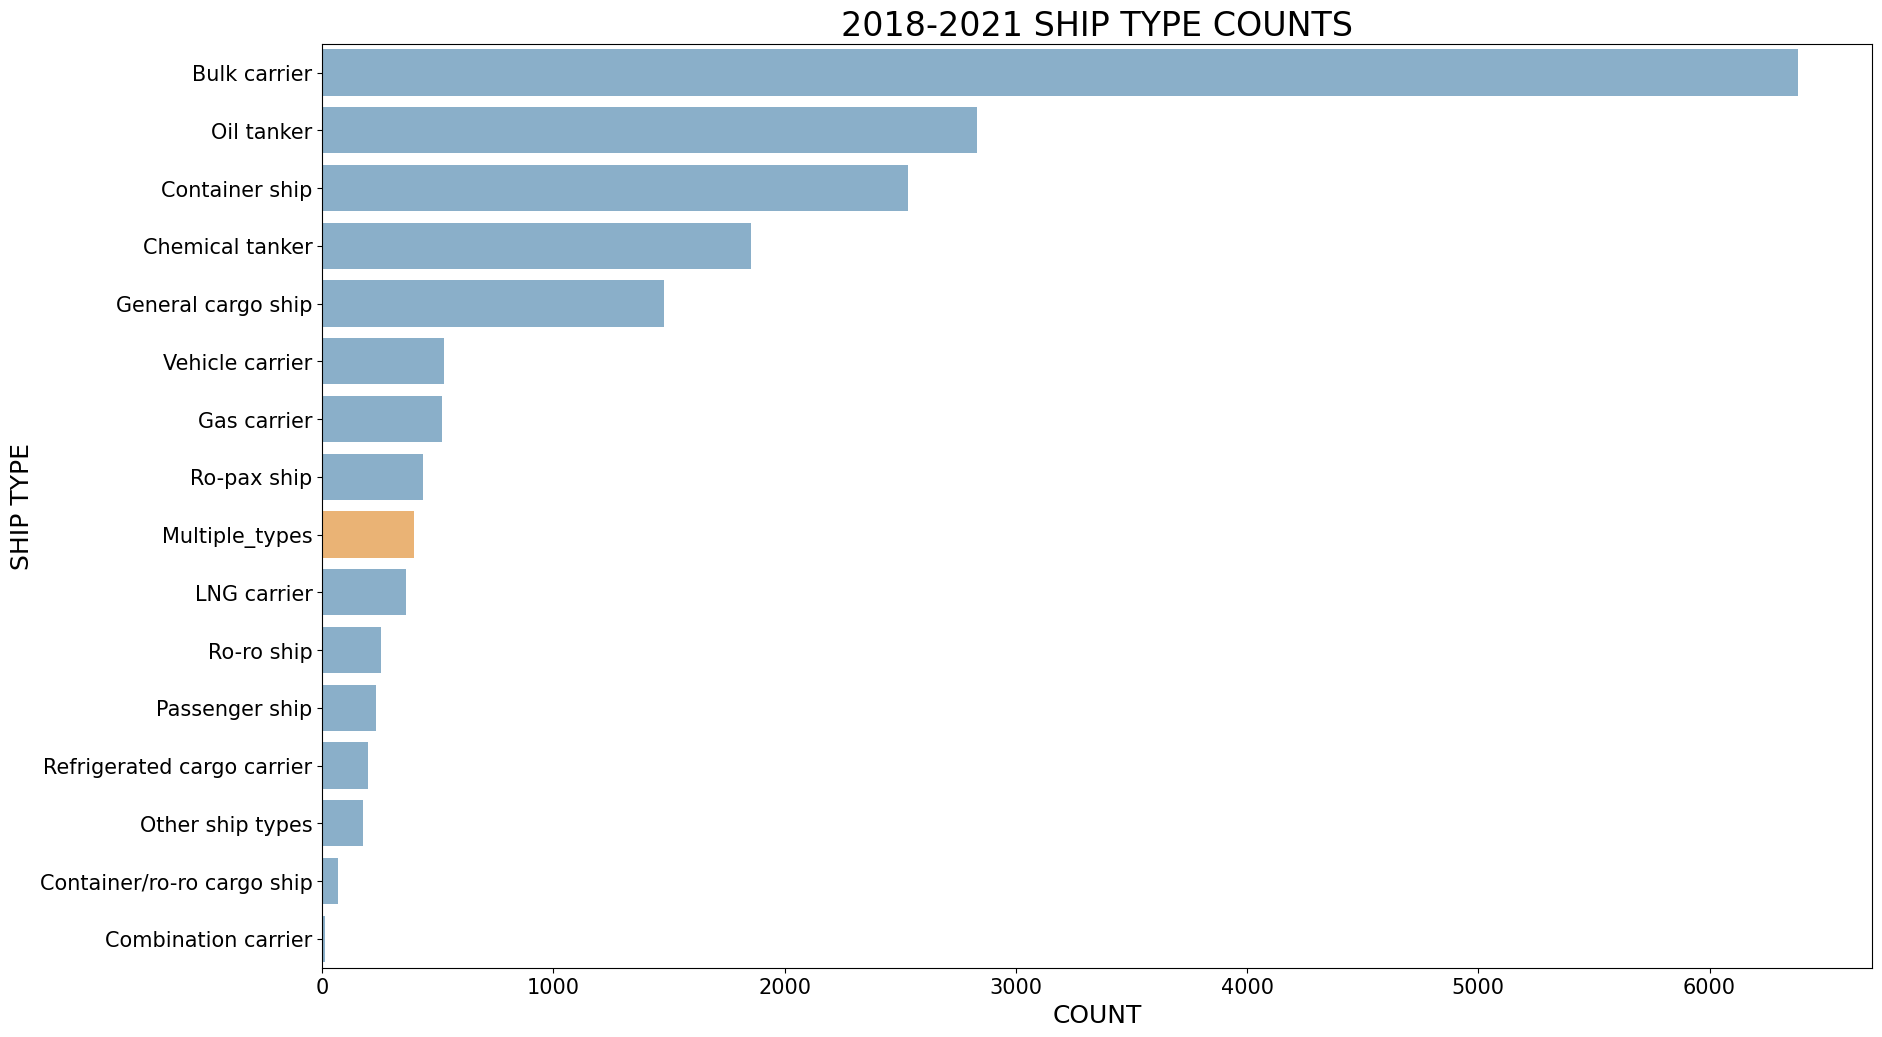

In [28]:
# Countplot

order = IMO_Type_df_byIMO["Ship_type"].value_counts().index
Set3 = sns.color_palette("Set3")
clrs = [Set3[5] if typ == "Multiple_types" else Set3[4] for typ in order]

plt.figure(figsize=(20,12))
plt.title("2018-2021 SHIP TYPE COUNTS", fontsize=24)
sns.countplot(data= IMO_Type_df_byIMO,  y = "Ship_type", palette=clrs, order = order)
plt.ylabel("SHIP TYPE", fontsize=18)
plt.xlabel("COUNT", fontsize=18)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.show()

In [29]:
# Explicit counts

IMO_Type_df_byIMO["Ship_type"].value_counts()

Bulk carrier                  6384
Oil tanker                    2832
Container ship                2533
Chemical tanker               1855
General cargo ship            1478
Vehicle carrier                527
Gas carrier                    517
Ro-pax ship                    436
Multiple_types                 397
LNG carrier                    361
Ro-ro ship                     253
Passenger ship                 234
Refrigerated cargo carrier     199
Other ship types               175
Container/ro-ro cargo ship      70
Combination carrier             12
Name: Ship_type, dtype: int64

SHIP TYPE NUMBERS 2018-2021 BY YEAR

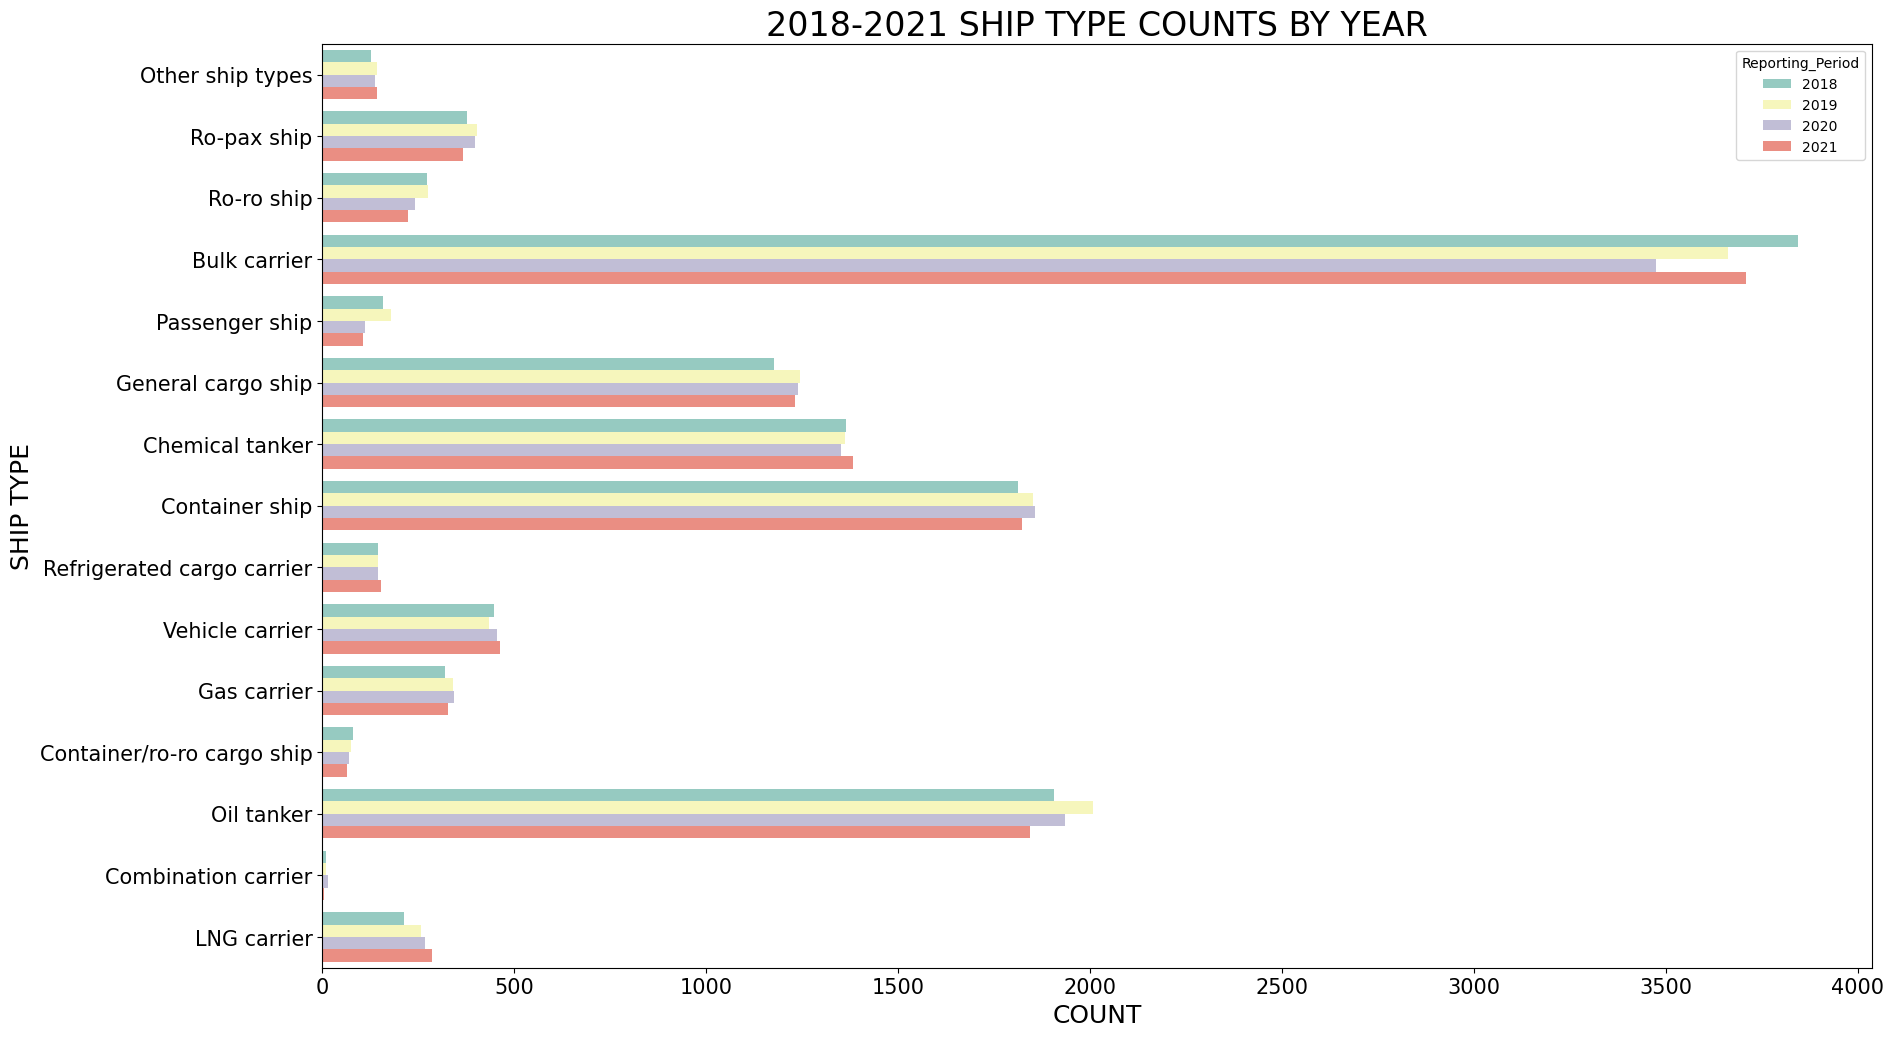

In [30]:
# Countplot

plt.figure(figsize=(20,12))
plt.title("2018-2021 SHIP TYPE COUNTS BY YEAR", fontsize=24)
sns.countplot(data= mrv_df,  y = "Ship_type", hue="Reporting_Period", palette=Set3)
plt.ylabel("SHIP TYPE", fontsize=18)
plt.xlabel("COUNT", fontsize=18)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.show()

## 2.3 Additional Exploration

It may be useful to show relative changes in type over the time period within the dataset.

In [31]:
# Calculating year to year % change

Ship_type_counts = []
for df in mrv_df_list:
    Ship_type_counts.append(df.Ship_type.value_counts())

Ship_type_change_dict = {}
for i in range(len(Ship_type_counts[1:])):
    Ship_type_change_dict[f"{keys[i]}-{keys[i+1]}"] = (Ship_type_counts[i+1] 
                            - Ship_type_counts[i])/Ship_type_counts[i]*100
for clist in Ship_type_change_dict.values():
    clist.sort_index(inplace=True)
Ship_type_change_list = [Ship_type_change_dict[key] for key in sorted(Ship_type_change_dict.keys())]

In [32]:
# Setting Ship_type color dictionary for consistancy across notebook

stypes = sorted(mrv_df_list[0].Ship_type.unique())

color_dict = {}

for idx in range(len(stypes)):
    color_dict[stypes[idx]] = clr_pal[idx]

## 2.4 Findings (Additional)

PERCENTAGE CHANGE IN SHIP TYPE YEAR TO YEAR

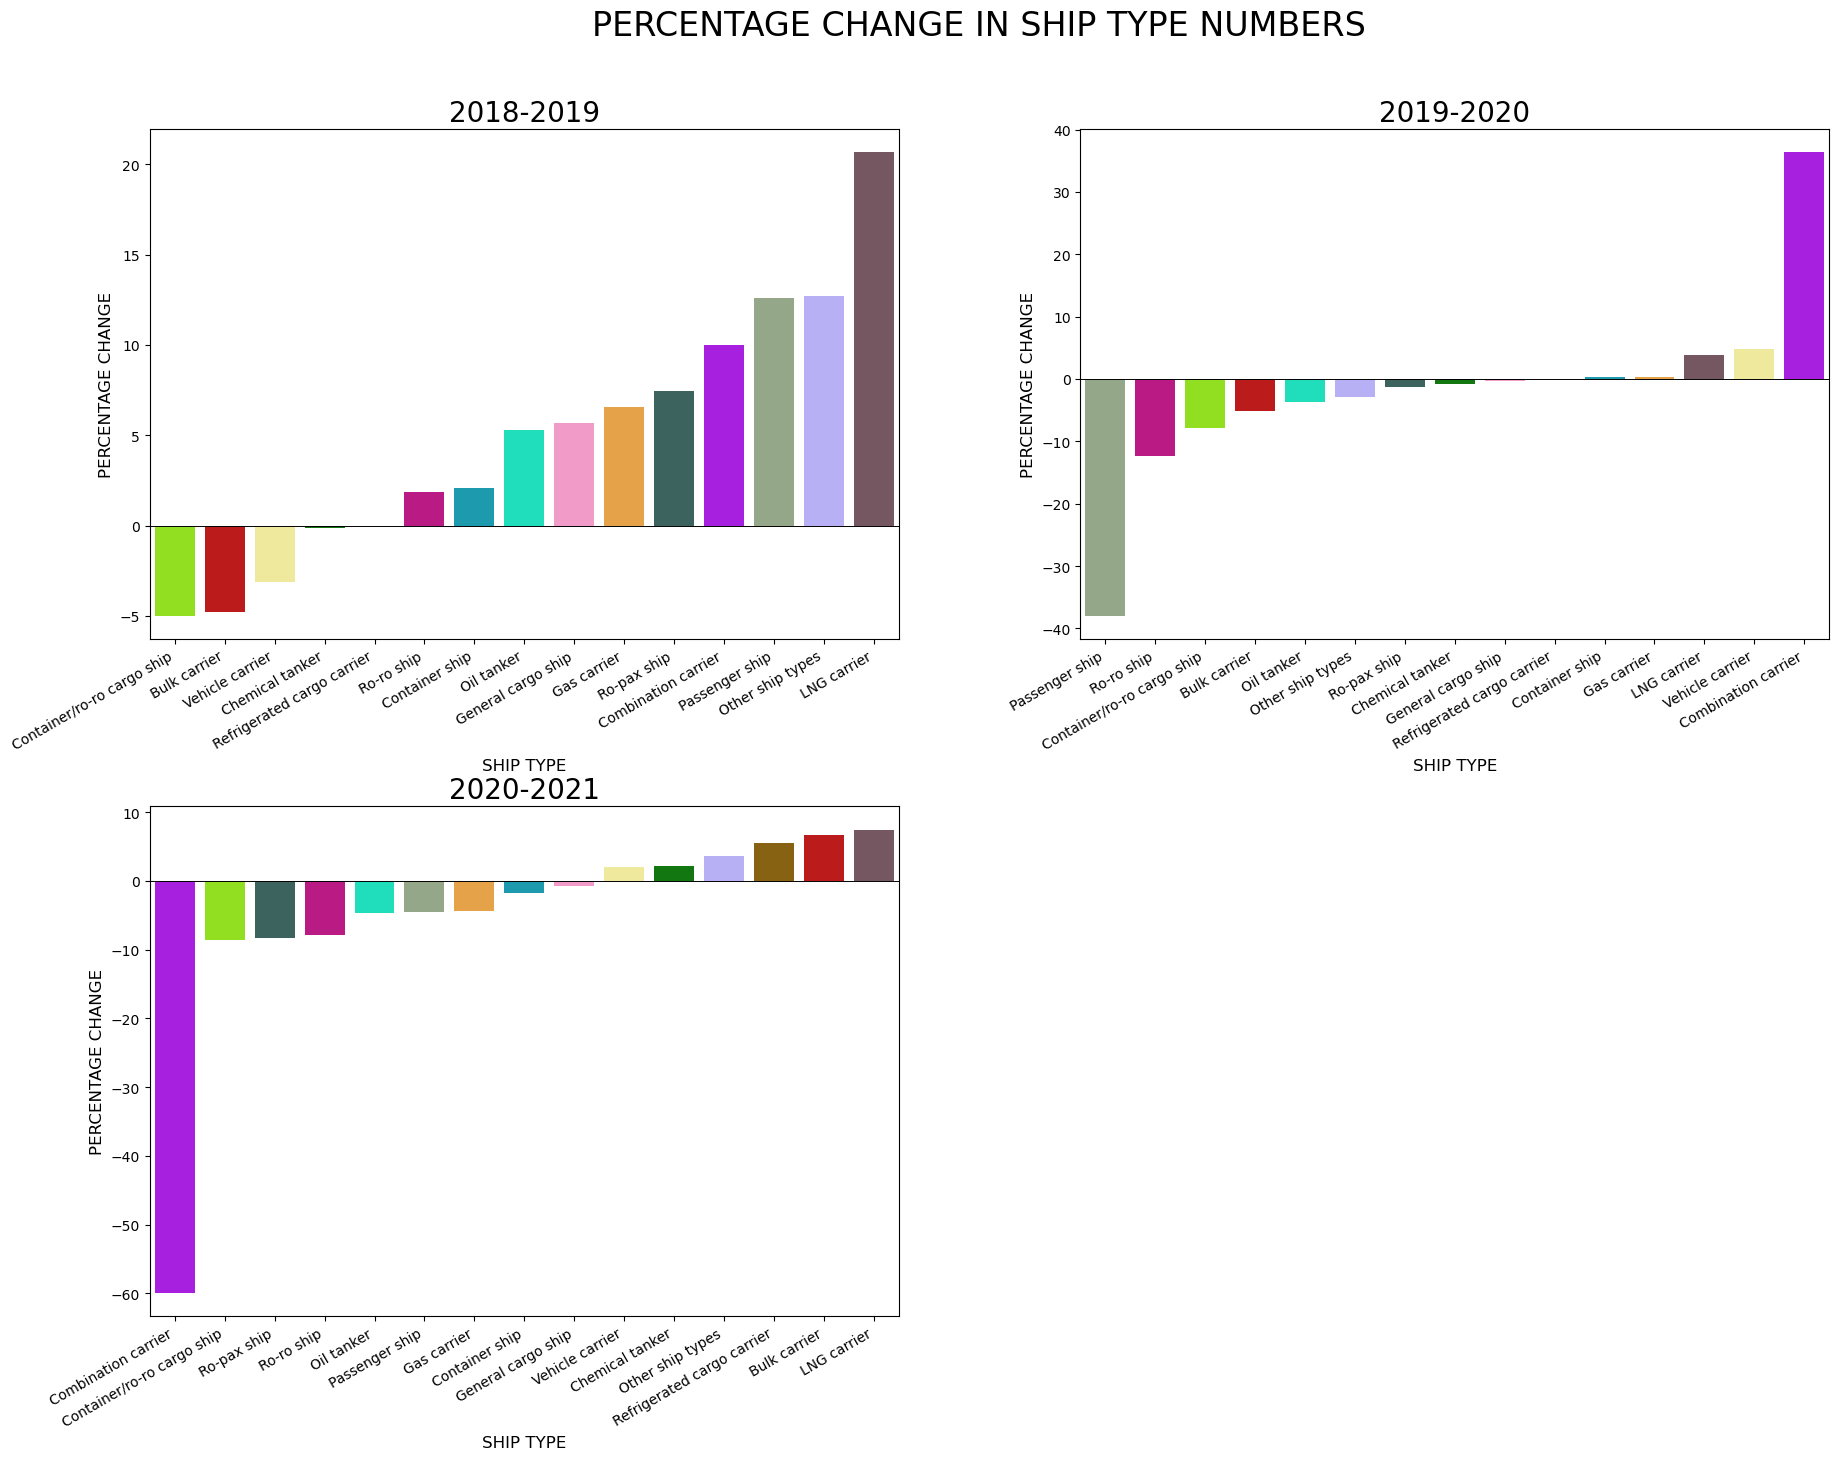

In [33]:
fig, axs = plt.subplots(2, 2, figsize=(20, 15))
fig.tight_layout(pad=10)
fig.suptitle('PERCENTAGE CHANGE IN SHIP TYPE NUMBERS', fontsize=24)
fig.subplots_adjust(top=0.9)

for x in range(len(Ship_type_change_list)):
    i, j = x // 2, x % 2
    ax = axs[i, j]
    s = Ship_type_change_list[x].sort_values()
 
    ax.set_xlabel("SHIP TYPE", fontsize=12)
    ax.set_ylabel("PERCENTAGE CHANGE", fontsize=12)
    ax.set_title(sorted(Ship_type_change_dict.keys())[x], fontsize=20)
    sns.barplot(x=s.index, y=s.values, ax=ax, palette=color_dict)
    ax.legend([], [], frameon=False)
    ax.axhline(y=0, color='k', lw=0.7)
    ax.set_xticklabels(labels=s.index, rotation=30, ha="right")
fig.delaxes(axs[1, 1])

plt.show()

# 3 - How do the emission profiles differ for the different ship types?

## 3.1 Working and Exlporation

The most prominent measure of a ships' emission profile seems to be "Technical efficiency" which is a measure of a ships' CO2 emission per utility, measured in grams of CO2 emitted per tonnes of cargo moved one nautical mile (g/t.nm). It strikes me that this measure doesn't account for the value of the transported product which would surely have a bearing on the utility of the action. The data lists two versions of this value: ["Technical_efficiency"] which I understand is a set value issues by an authority based on a ships' build and ["Annual_average_CO₂_emissions_per_transport_work_(mass)_[g_CO₂_/_m_tonnes_·_n_miles]"] which appears to be a more specific measure of the actual technical efficiency achieved. I will refer to this as measured technical efficiency. Additionally, there are two measures of the listed technical efficiency, EIV and EEDI. I gather EIV is a simplified approximation of EEDI.

Note that we have much less data for measured technical efficiency (MTE).

In [34]:
# Selecting relevant data.

mrv_efficiency_df = mrv_df[[
    "IMO_Number", "Ship_type", "Technical_efficiency",
    "Annual_average_CO₂_emissions_per_transport_work_(mass)_[g_CO₂_/_m_tonnes_·_n_miles]"
]].copy()
mrv_efficiency_df.columns = [
    "IMO_Number", "Ship_type", "Technical_efficiency", "Measured_efficiency"
]
mrv_efficiency_df

IMO_Number         Ship_type    Technical_efficiency  \
0         6703343  Other ship types   EIV (57.84 gCO₂/t·nm)   
1         7037806       Ro-pax ship    EIV (19.4 gCO₂/t·nm)   
2         7043843        Ro-ro ship   EIV (48.71 gCO₂/t·nm)   
3         7128332       Ro-pax ship    EIV (9.29 gCO₂/t·nm)   
4         7226952        Ro-ro ship      EIV (43 gCO₂/t·nm)   
...           ...               ...                     ...   
48815     9838199   Chemical tanker  EEDI (12.93 gCO₂/t·nm)   
48816     9839064      Bulk carrier                     NaN   
48817     9840790      Bulk carrier                     NaN   
48818     9847140   Chemical tanker    EIV (9.16 gCO₂/t·nm)   
48819     9848467        Ro-ro ship   EEDI (12.3 gCO₂/t·nm)   

       Measured_efficiency  
0                   210.74  
1                      NaN  
2                   695.22  
3                      NaN  
4                   250.63  
...                    ...  
48815                56.31  
48816                  NaN  
48817                  NaN  
48818                13.33  
48819               273.55  

[48820 rows x 4 columns]

In [35]:
def handle_te_type(te):
    #take technical efficiency string and returns the measure used as as string
    
    try:
        te_type = re.findall(r"(EIV|EEDI)", te)[0]
        return te_type
    except:
        return np.nan


def handle_te_val(te):
    #take technical efficiency string and returns the value as a float
    
    try:
        te_value = float(re.findall(r"(\(\d.*\s)", te)[0][1:-1])
        if te_value == 0:
            return np.nan
        return te_value
    except:
        return np.nan

In [36]:
# dealing with the string

mrv_efficiency_df[
    "Technical_efficiency_measure"] = mrv_efficiency_df.Technical_efficiency.apply(
        handle_te_type)
mrv_efficiency_df.Technical_efficiency = mrv_efficiency_df.Technical_efficiency.apply(
    handle_te_val)

mrv_efficiency_df

IMO_Number         Ship_type  Technical_efficiency  \
0         6703343  Other ship types                 57.84   
1         7037806       Ro-pax ship                 19.40   
2         7043843        Ro-ro ship                 48.71   
3         7128332       Ro-pax ship                  9.29   
4         7226952        Ro-ro ship                 43.00   
...           ...               ...                   ...   
48815     9838199   Chemical tanker                 12.93   
48816     9839064      Bulk carrier                   NaN   
48817     9840790      Bulk carrier                   NaN   
48818     9847140   Chemical tanker                  9.16   
48819     9848467        Ro-ro ship                 12.30   

       Measured_efficiency Technical_efficiency_measure  
0                   210.74                          EIV  
1                      NaN                          EIV  
2                   695.22                          EIV  
3                      NaN                          EIV  
4                   250.63                          EIV  
...                    ...                          ...  
48815                56.31                         EEDI  
48816                  NaN                          NaN  
48817                  NaN                          NaN  
48818                13.33                          EIV  
48819               273.55                         EEDI  

[48820 rows x 5 columns]

Based on our assumptions about measured vs listed TE, we would expect them to have a positive correlation, with measured efficiency lagging behind the listed number which is likely representative of ideal operating conditions. 

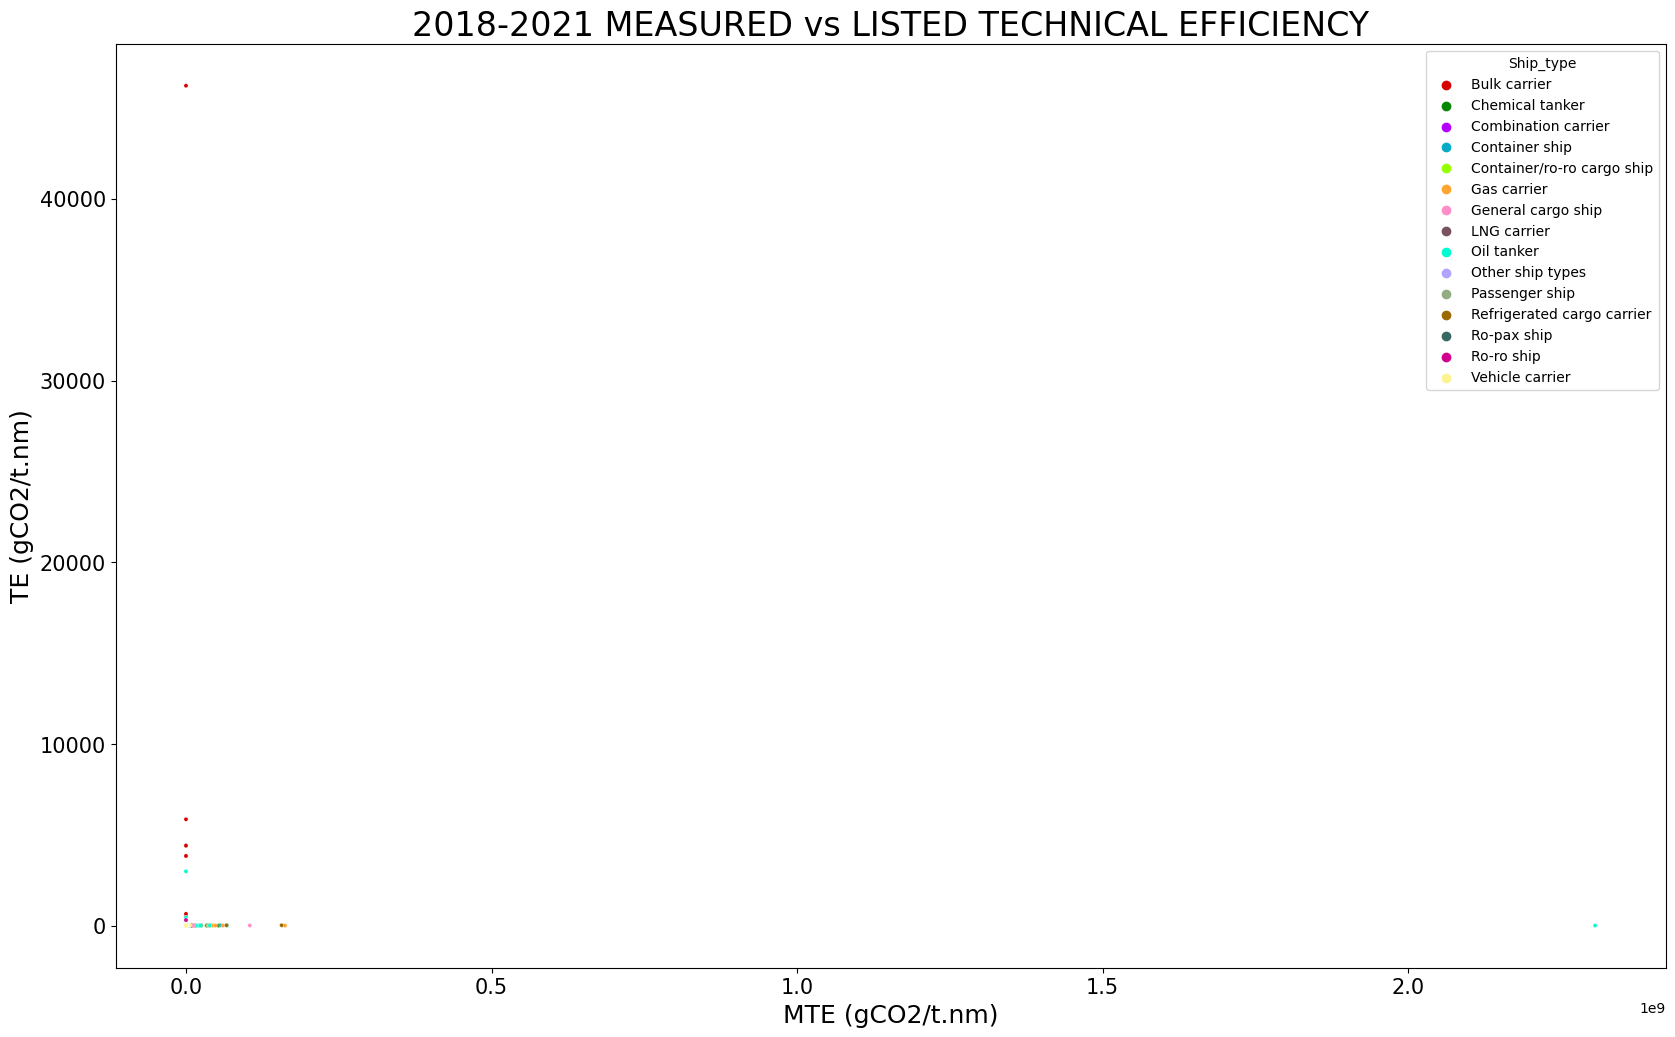

In [37]:
data = mrv_efficiency_df

plt.figure(figsize=(20, 12))
plt.title("2018-2021 MEASURED vs LISTED TECHNICAL EFFICIENCY", fontsize=24)
sns.scatterplot(data=data.sort_values("Ship_type"),
                x="Measured_efficiency",
                y="Technical_efficiency",
                hue="Ship_type",
                palette=color_dict,
                s=9)
plt.ylabel("TE (gCO2/t.nm)", fontsize=18)
plt.xlabel("MTE (gCO2/t.nm)", fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

Clearly we have some significant outliers.

In [38]:
mrv_efficiency_df.describe()

IMO_Number  Technical_efficiency  Measured_efficiency
count  4.882000e+04          44700.000000         4.006900e+04
mean   9.453073e+06             13.360127         9.855400e+04
std    2.870155e+05            241.177083         1.163216e+07
min    5.383304e+06              0.010000         3.000000e-02
25%    9.307836e+06              4.520000         7.950000e+00
50%    9.451713e+06              7.120000         1.264000e+01
75%    9.662423e+06             14.480000         2.767000e+01
max    9.924912e+06          46222.000000         2.305780e+09

In [39]:
mrv_efficiency_df[mrv_efficiency_df.Technical_efficiency_measure == "EIV"].describe()

IMO_Number  Technical_efficiency  Measured_efficiency
count  3.276100e+04          32752.000000         2.628300e+04
mean   9.369439e+06             13.878322         1.430031e+05
std    2.615653e+05            110.457909         1.435853e+07
min    5.383304e+06              0.010000         3.000000e-02
25%    9.283899e+06              5.420000         8.900000e+00
50%    9.389239e+06              8.310000         1.469000e+01
75%    9.508483e+06             16.400000         3.408000e+01
max    9.916264e+06          12700.000000         2.305780e+09

In [40]:
mrv_efficiency_df[mrv_efficiency_df.Technical_efficiency_measure == "EEDI"].describe()

IMO_Number  Technical_efficiency  Measured_efficiency
count  1.196700e+04          11935.000000         1.103100e+04
mean   9.709537e+06              8.055453         5.704571e+03
std    1.516793e+05             73.687306         2.504233e+05
min    7.043843e+06              0.170000         7.000000e-02
25%    9.695139e+06              3.690000         6.500000e+00
50%    9.736080e+06              4.710000         8.880000e+00
75%    9.792541e+06              8.040000         1.492500e+01
max    9.924912e+06           5856.000000         1.548248e+07

Filtering the extreme high outliers which are many orders of magnitude larger than the median in both features..

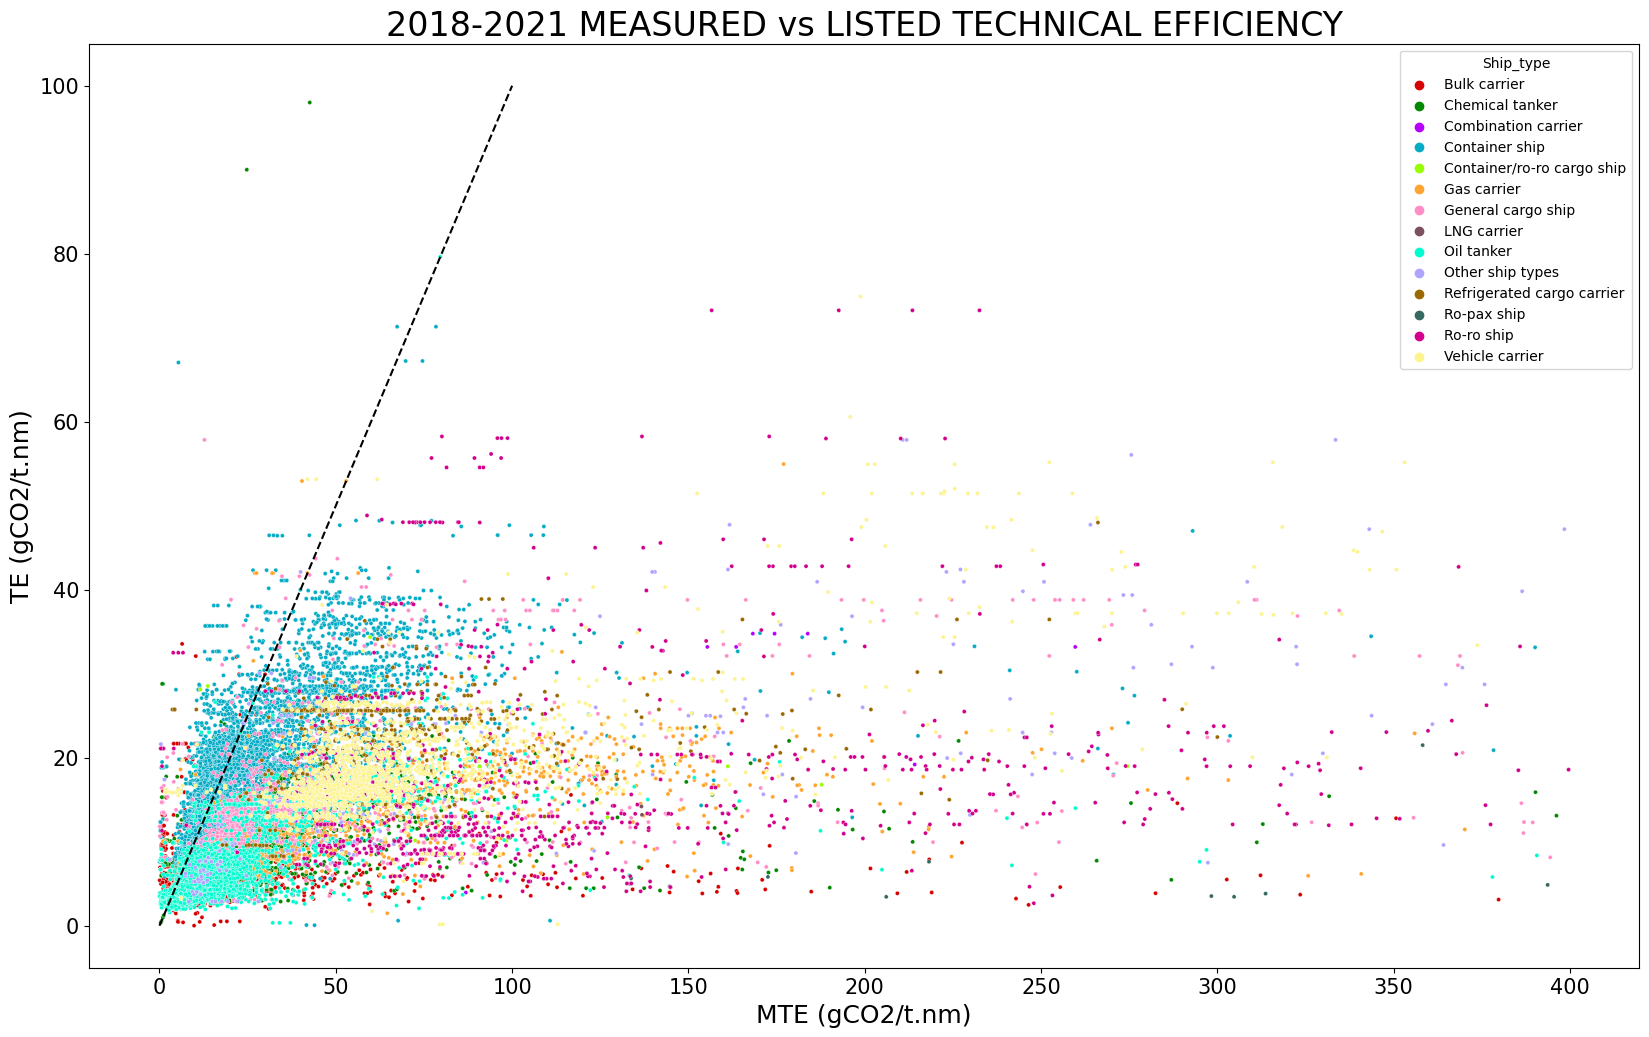

In [41]:
te_lim = 100
mte_lim = 400
te_filter = mrv_efficiency_df.Technical_efficiency < te_lim
mte_filter = mrv_efficiency_df.Measured_efficiency < mte_lim

data = mrv_efficiency_df[te_filter & mte_filter]

plt.figure(figsize=(20, 12))
plt.title("2018-2021 MEASURED vs LISTED TECHNICAL EFFICIENCY", fontsize=24)
sns.scatterplot(data=data.sort_values("Ship_type"),
                x="Measured_efficiency",
                y="Technical_efficiency",
                hue="Ship_type",
                palette=color_dict,
                s=9)
plt.plot([0, te_lim], [0, te_lim], linestyle='--', color="black")
plt.ylabel("TE (gCO2/t.nm)", fontsize=18)
plt.xlabel("MTE (gCO2/t.nm)", fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.show()

Above we see that generally vessels do not achieve their listed TE and many cases, greatly exceed it.

We have some significant apparent outliers (4 orders of magnitude above the median) making the distribution difficult to visualise. We can filter out extreme values to better observe the distribution.

## 3.2 - Findings

Having filtered out the extreme high outliers we can observe the emissions profiles of the ship types in terms of both the measured and listed technical efficiency.

EMISSION PROFILE BY SHIP TYPE IN TERMS OF TECHNICAL EFFICIENCY

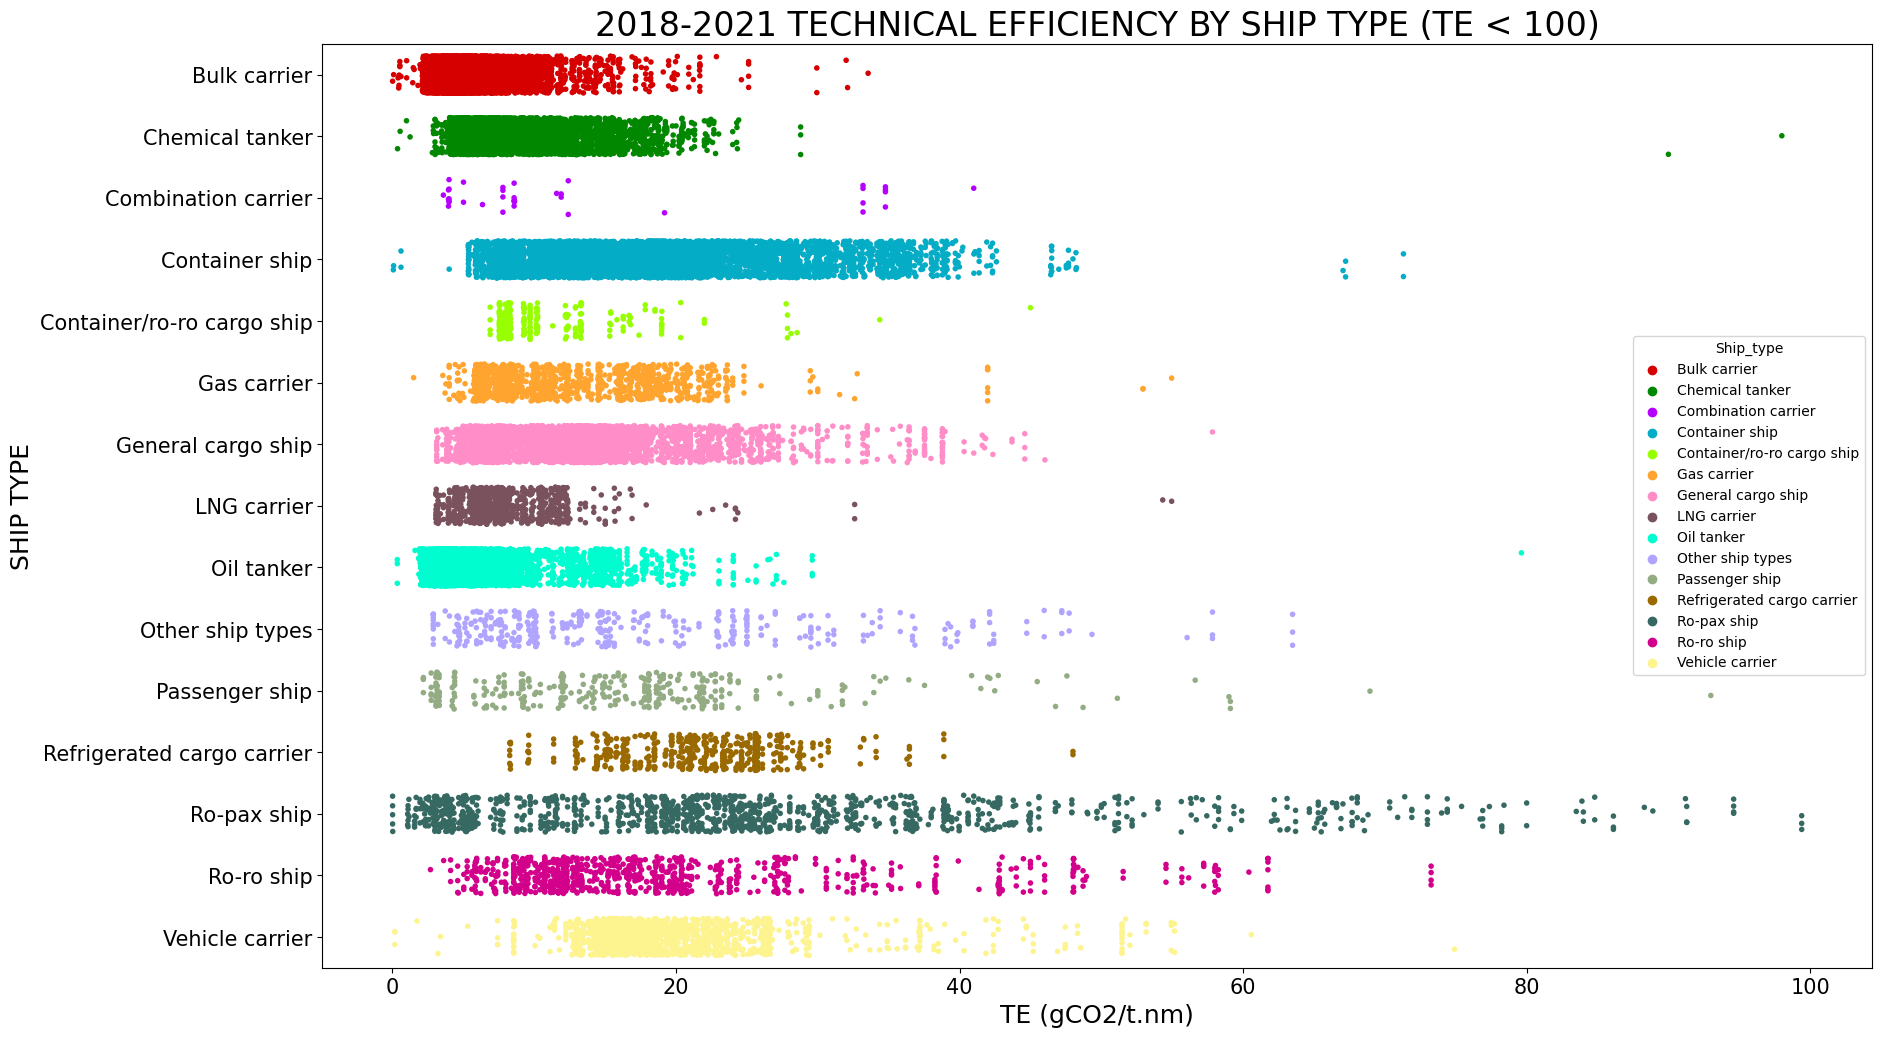

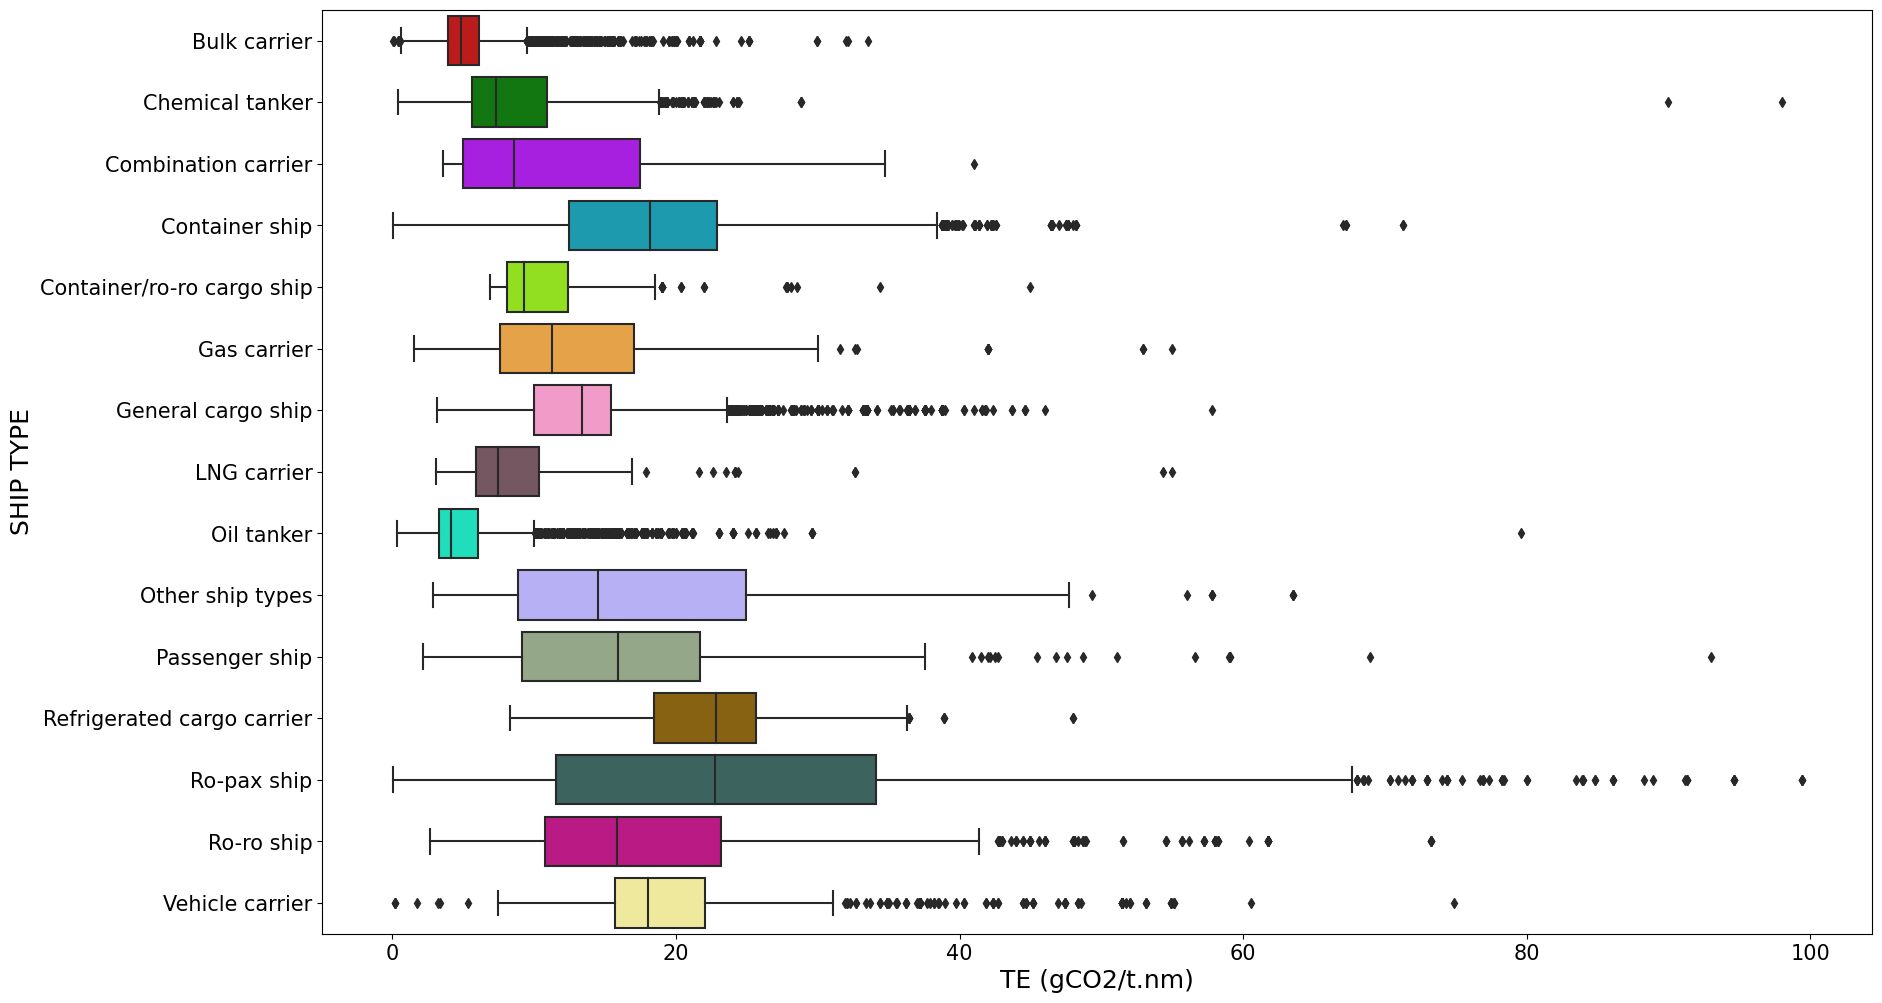

In [42]:
te_lim = 100
data = mrv_efficiency_df[mrv_efficiency_df.Technical_efficiency < te_lim]
plt.figure(figsize=(20, 12))
plt.title(f"2018-2021 TECHNICAL EFFICIENCY BY SHIP TYPE (TE < {te_lim})",
          fontsize=24)
sns.stripplot(data=data.sort_values("Ship_type"),
              x="Technical_efficiency",
              y="Ship_type",
              jitter=0.3,
              hue= "Ship_type",
              palette=color_dict,
              s=4)
plt.ylabel("SHIP TYPE", fontsize=18)
plt.xlabel("TE (gCO2/t.nm)", fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

plt.figure(figsize=(20, 12))
sns.boxplot(data=data.sort_values("Ship_type"),
            x="Technical_efficiency",
            y="Ship_type",
            palette=color_dict)
plt.ylabel("SHIP TYPE", fontsize=18)
plt.xlabel("TE (gCO2/t.nm)", fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.show()

SHIP TYPE TECHNICAL EFFICIENCY FREQUENCY DISTRIBUTION

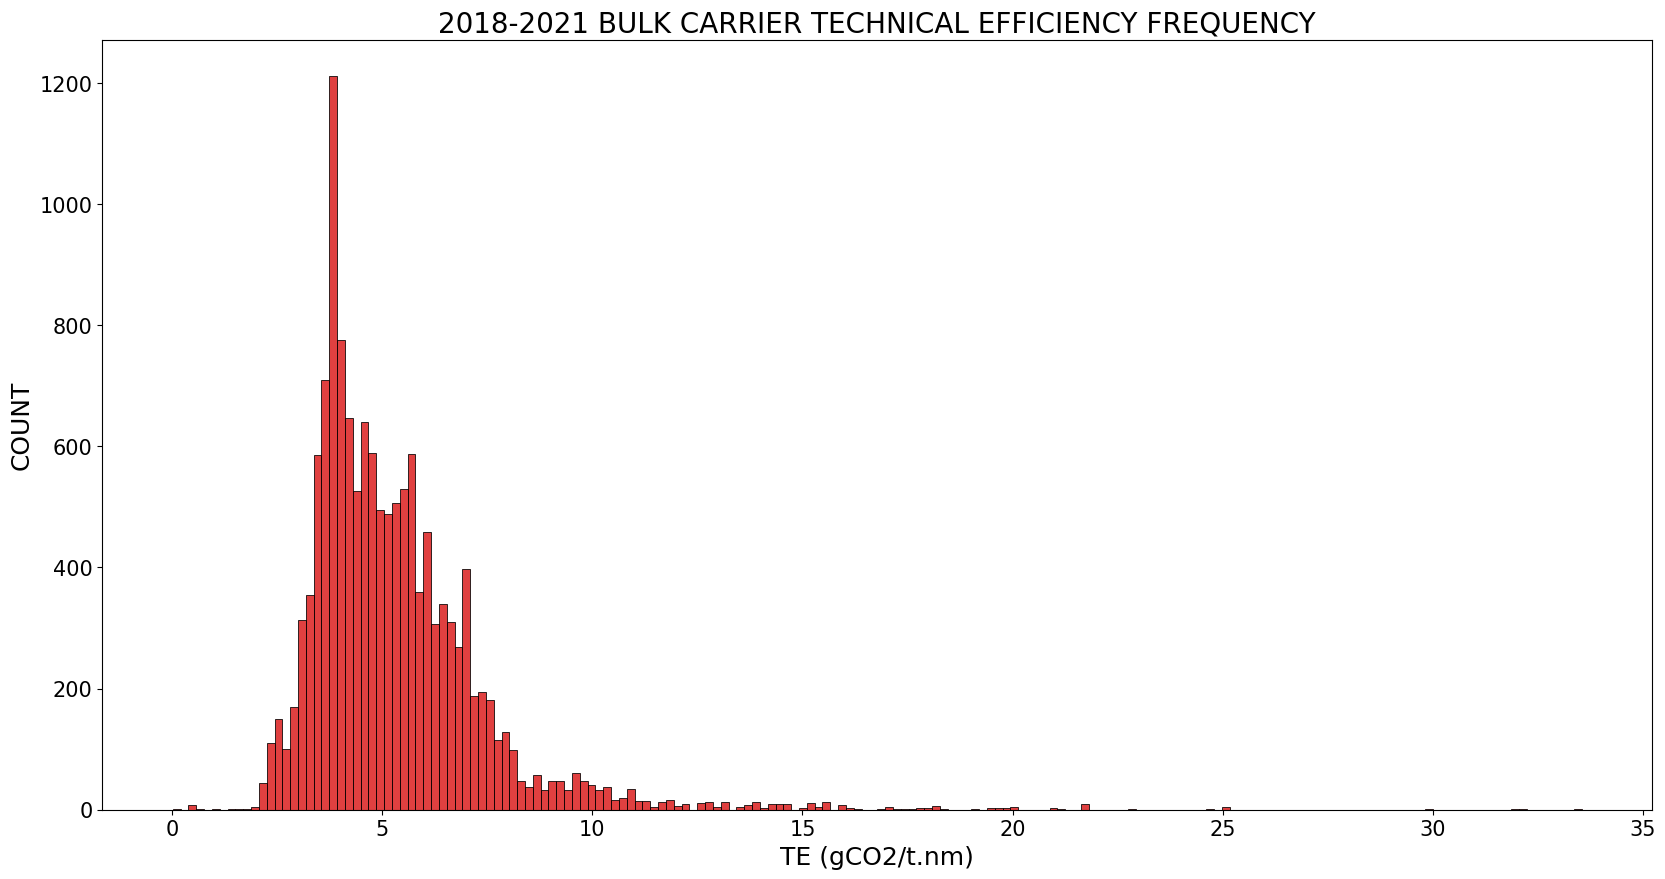

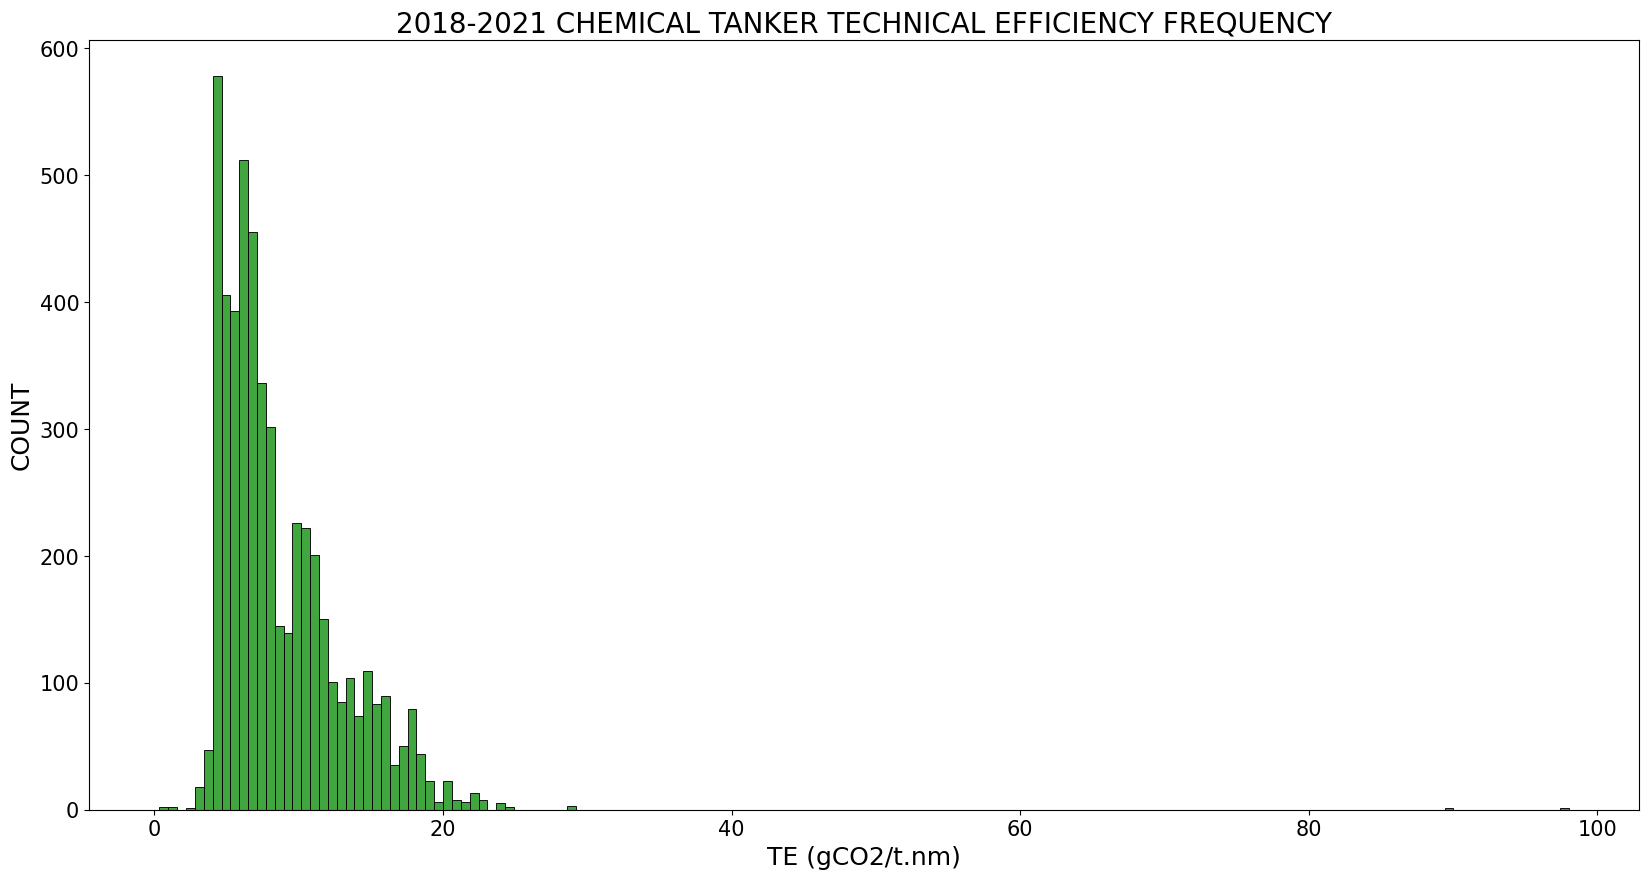

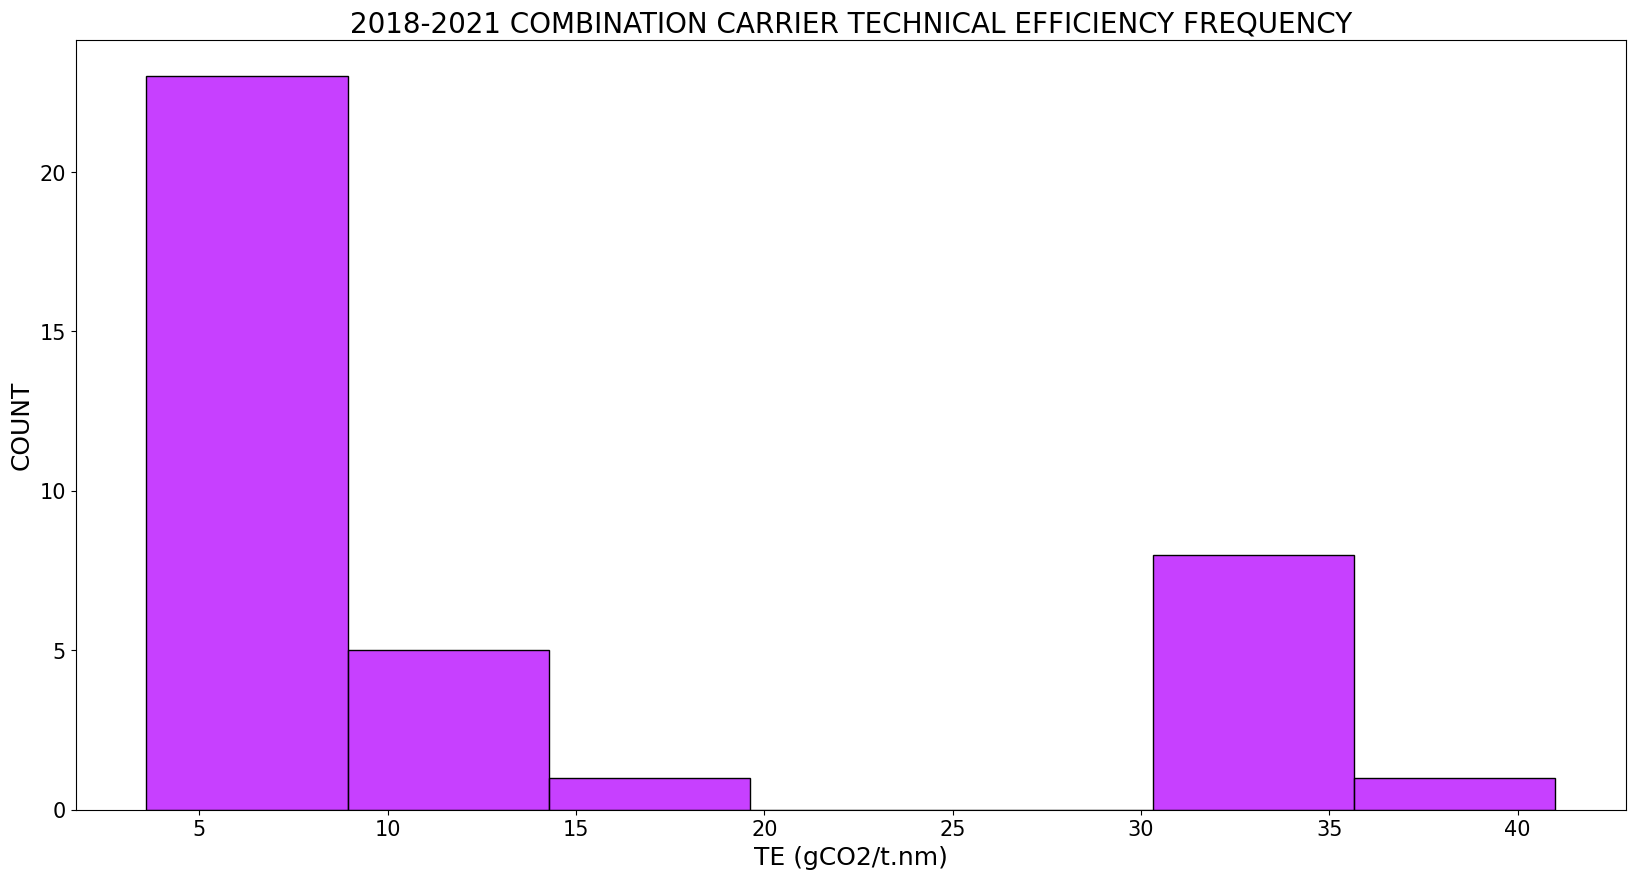

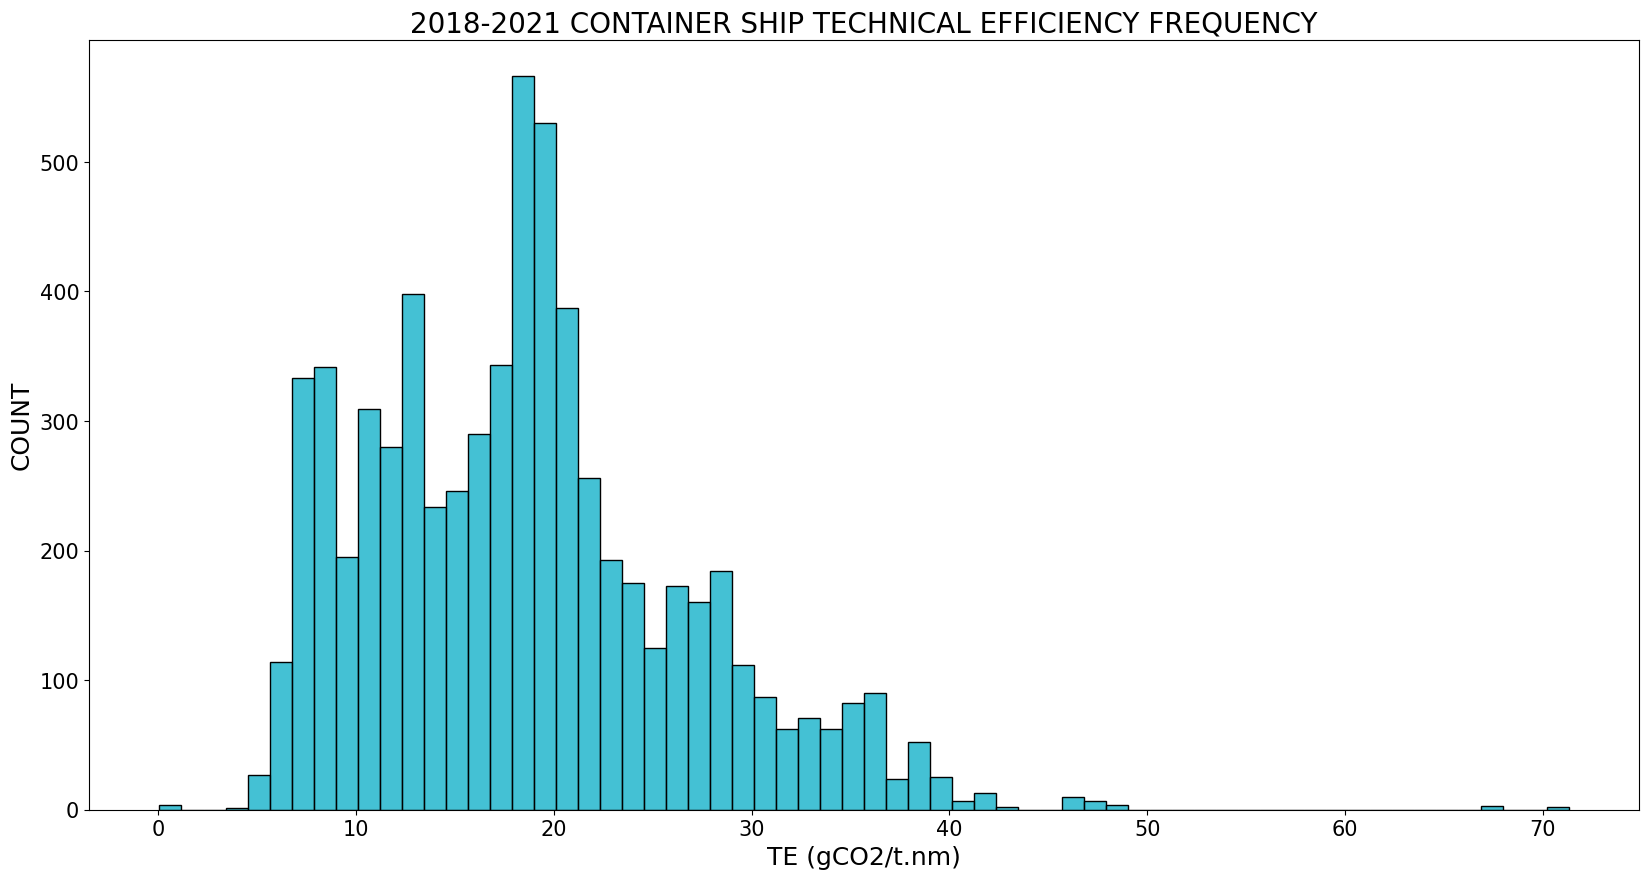

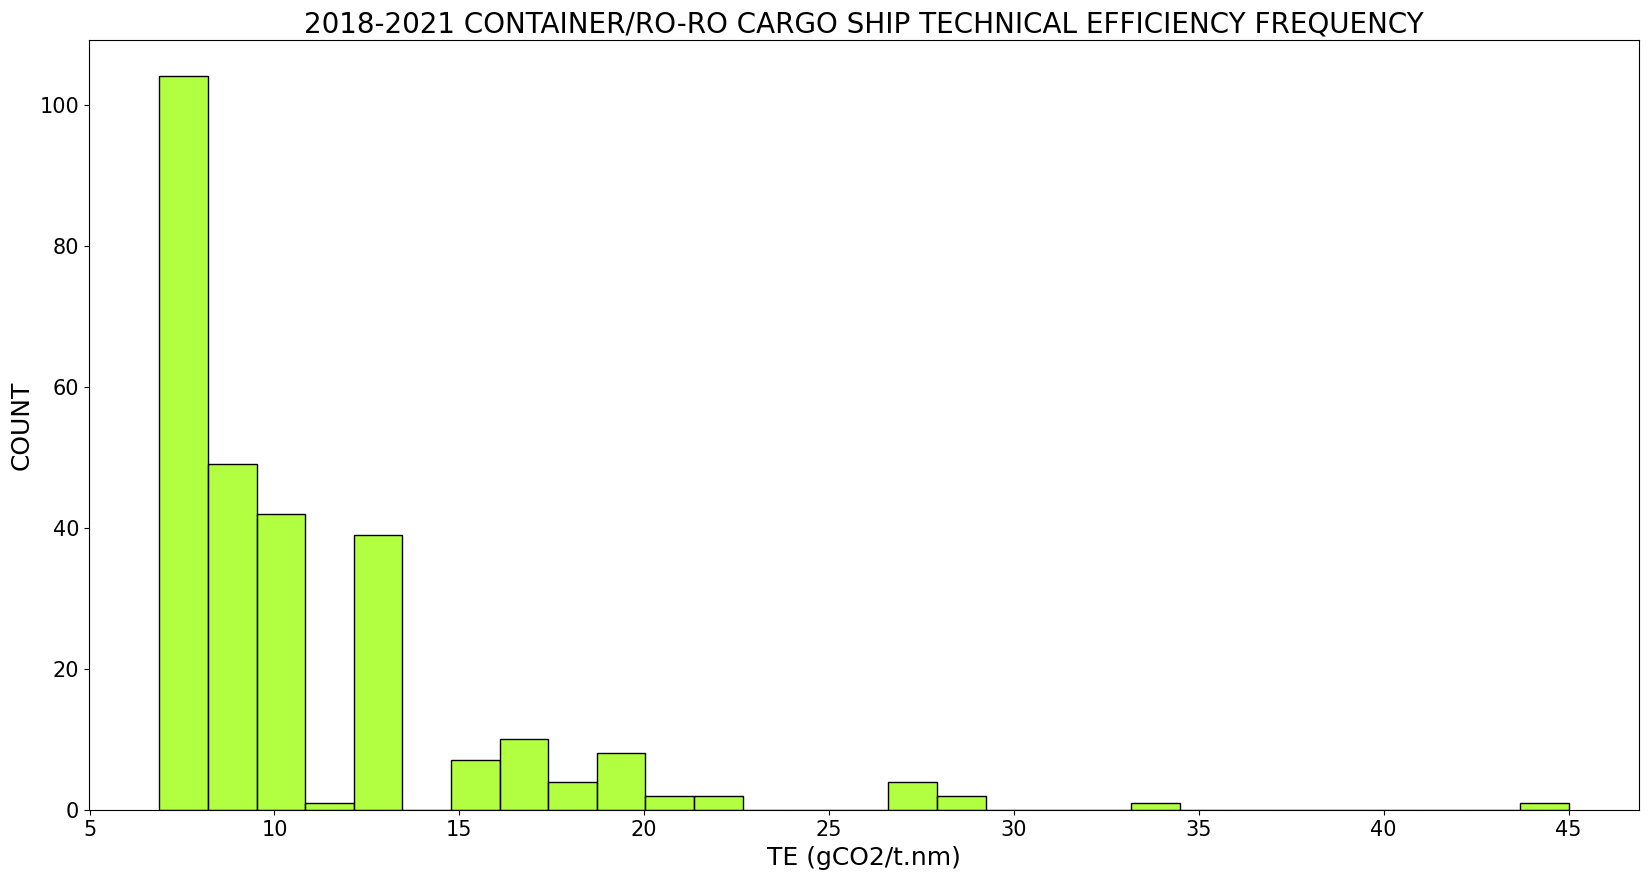

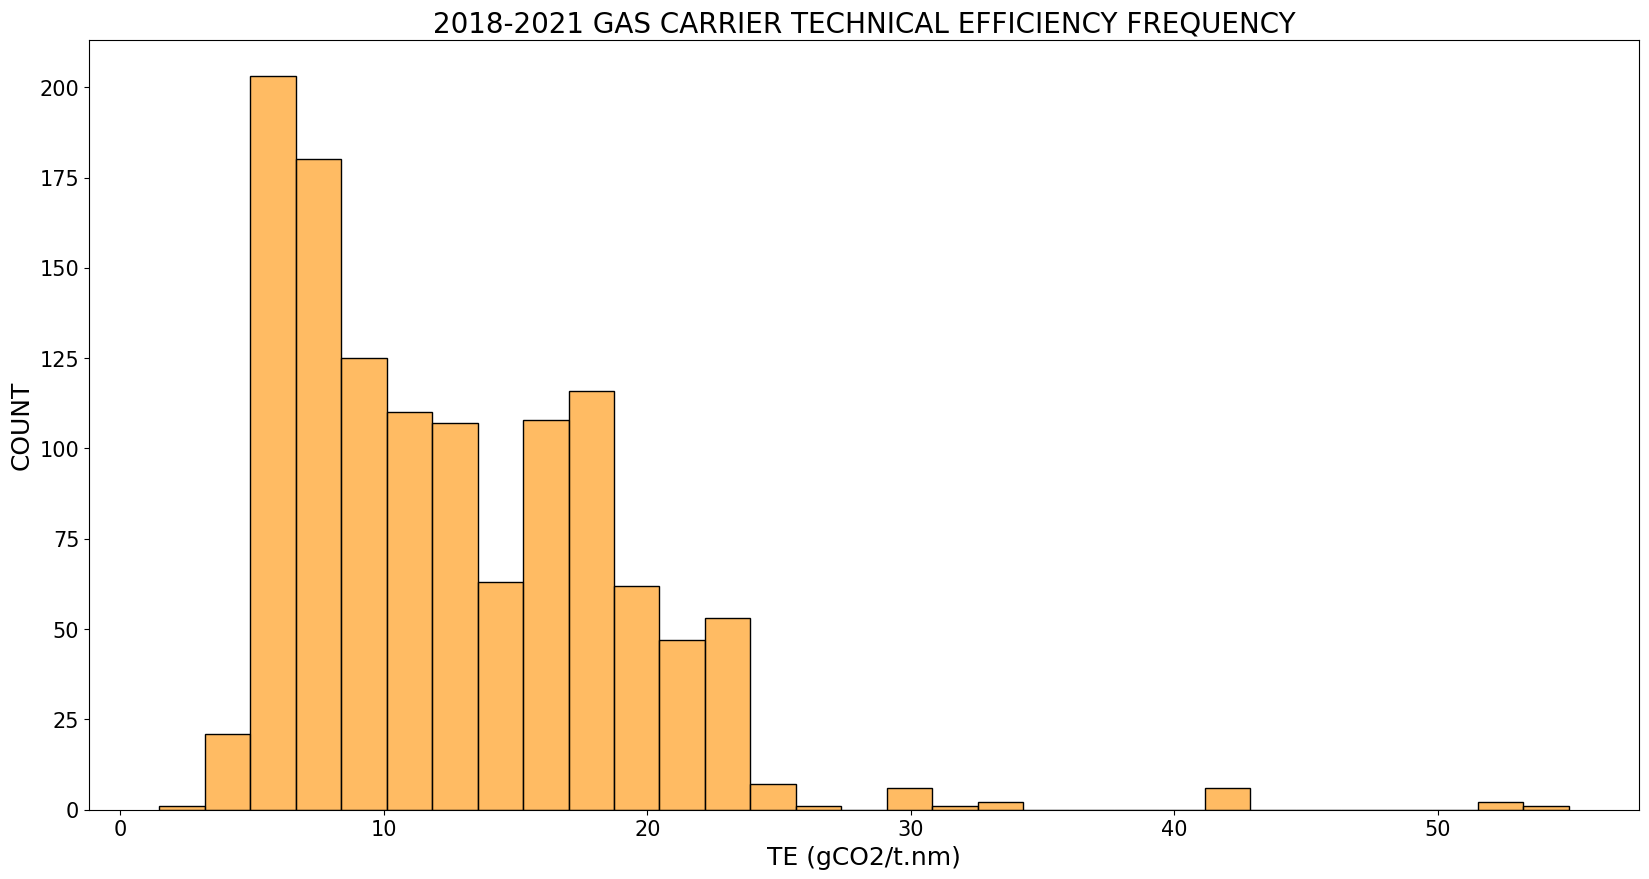

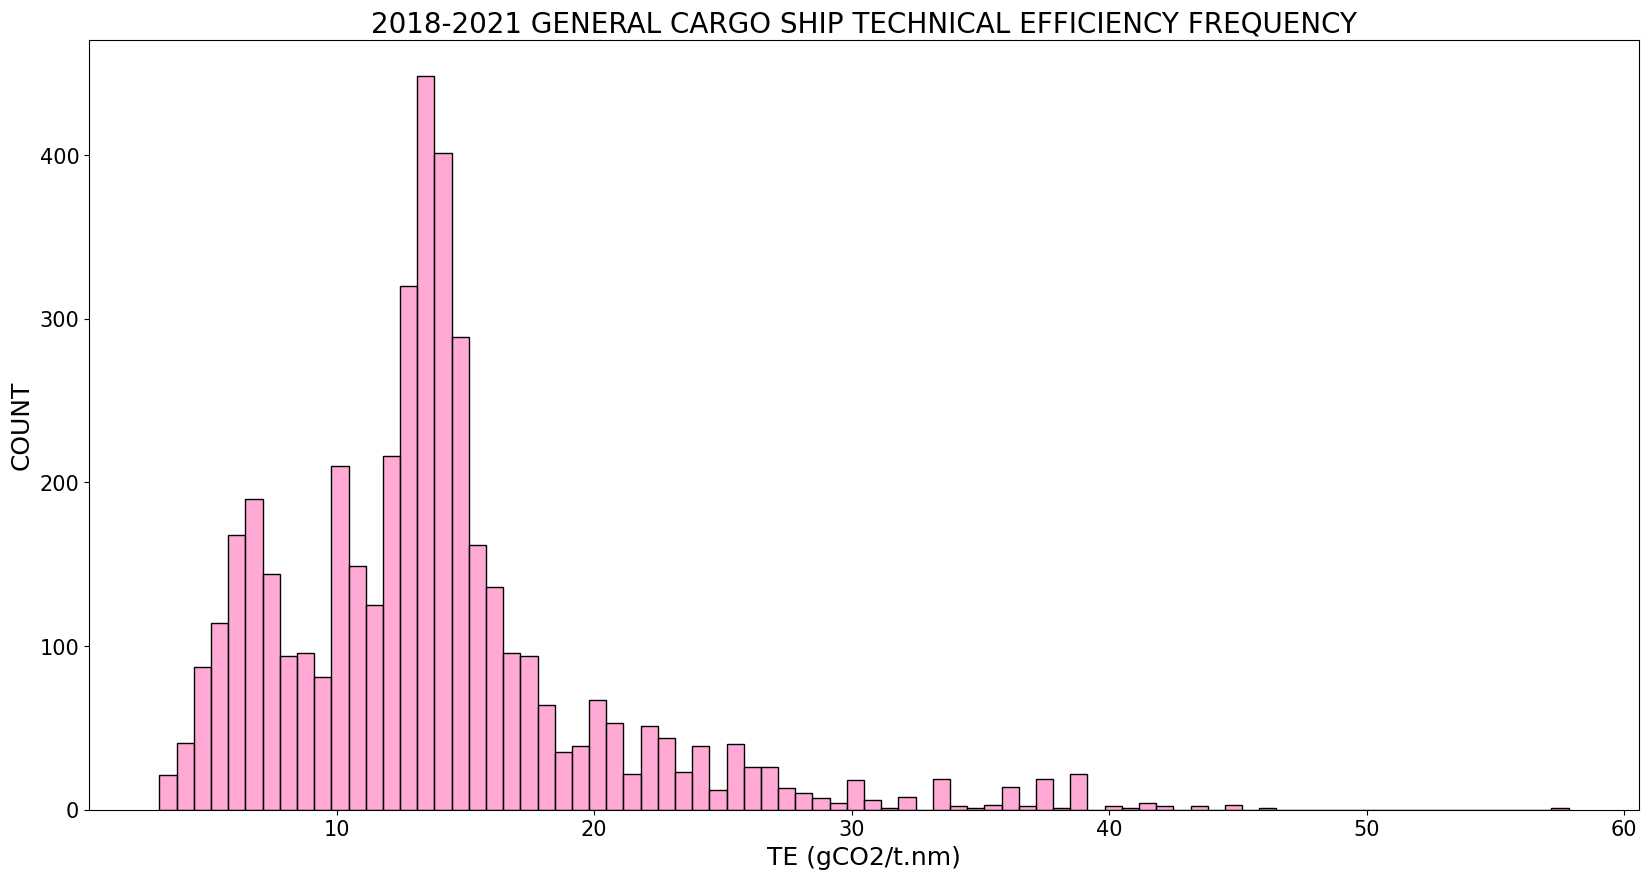

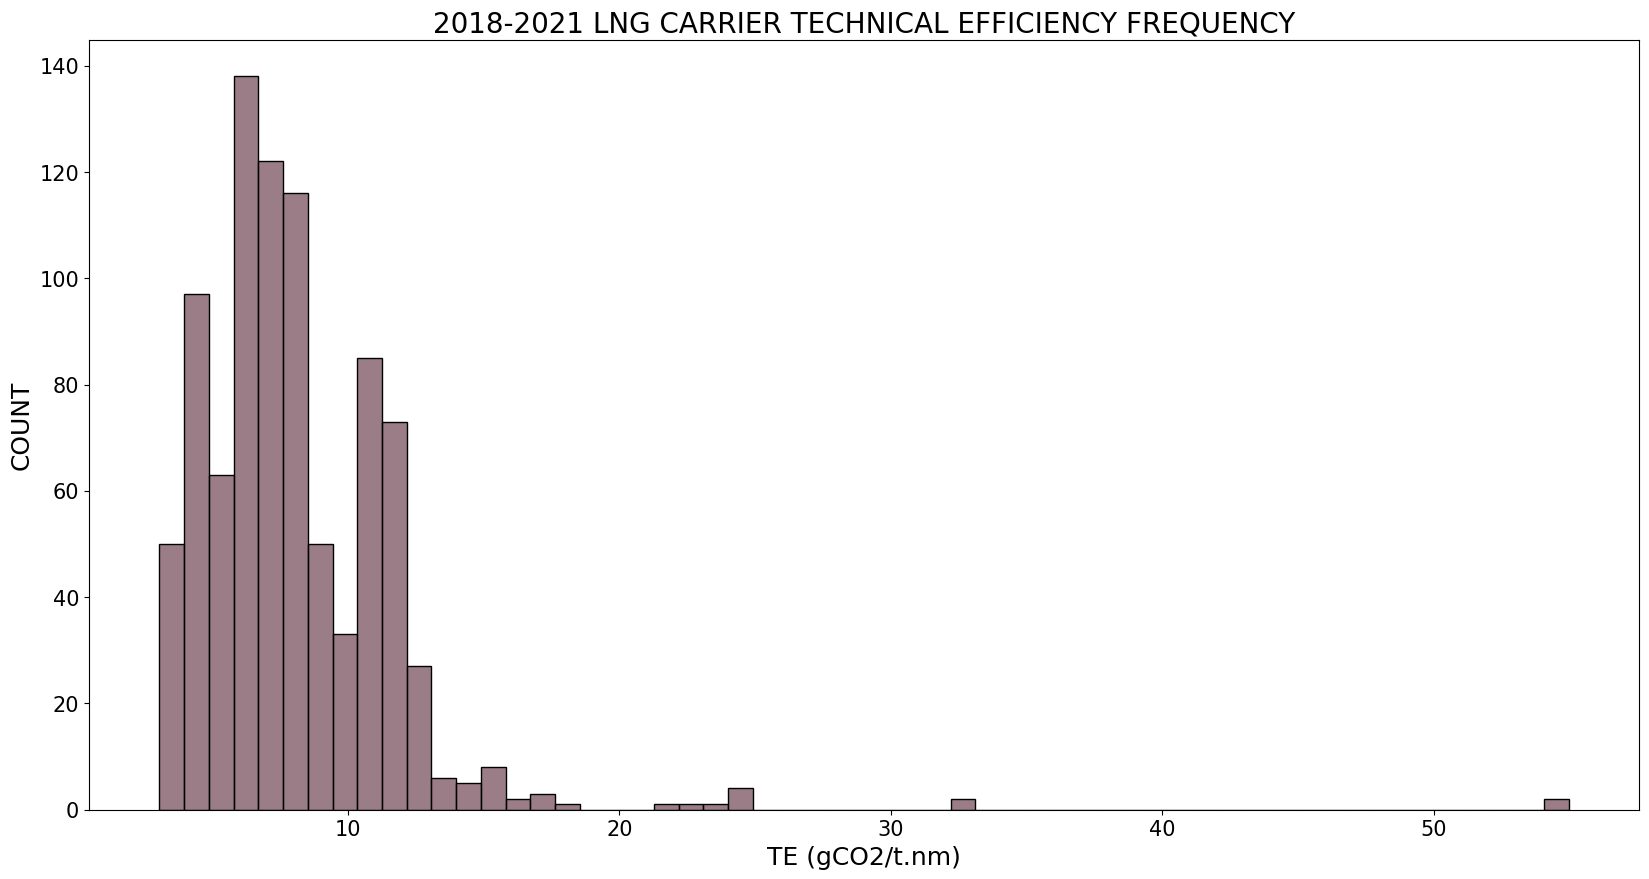

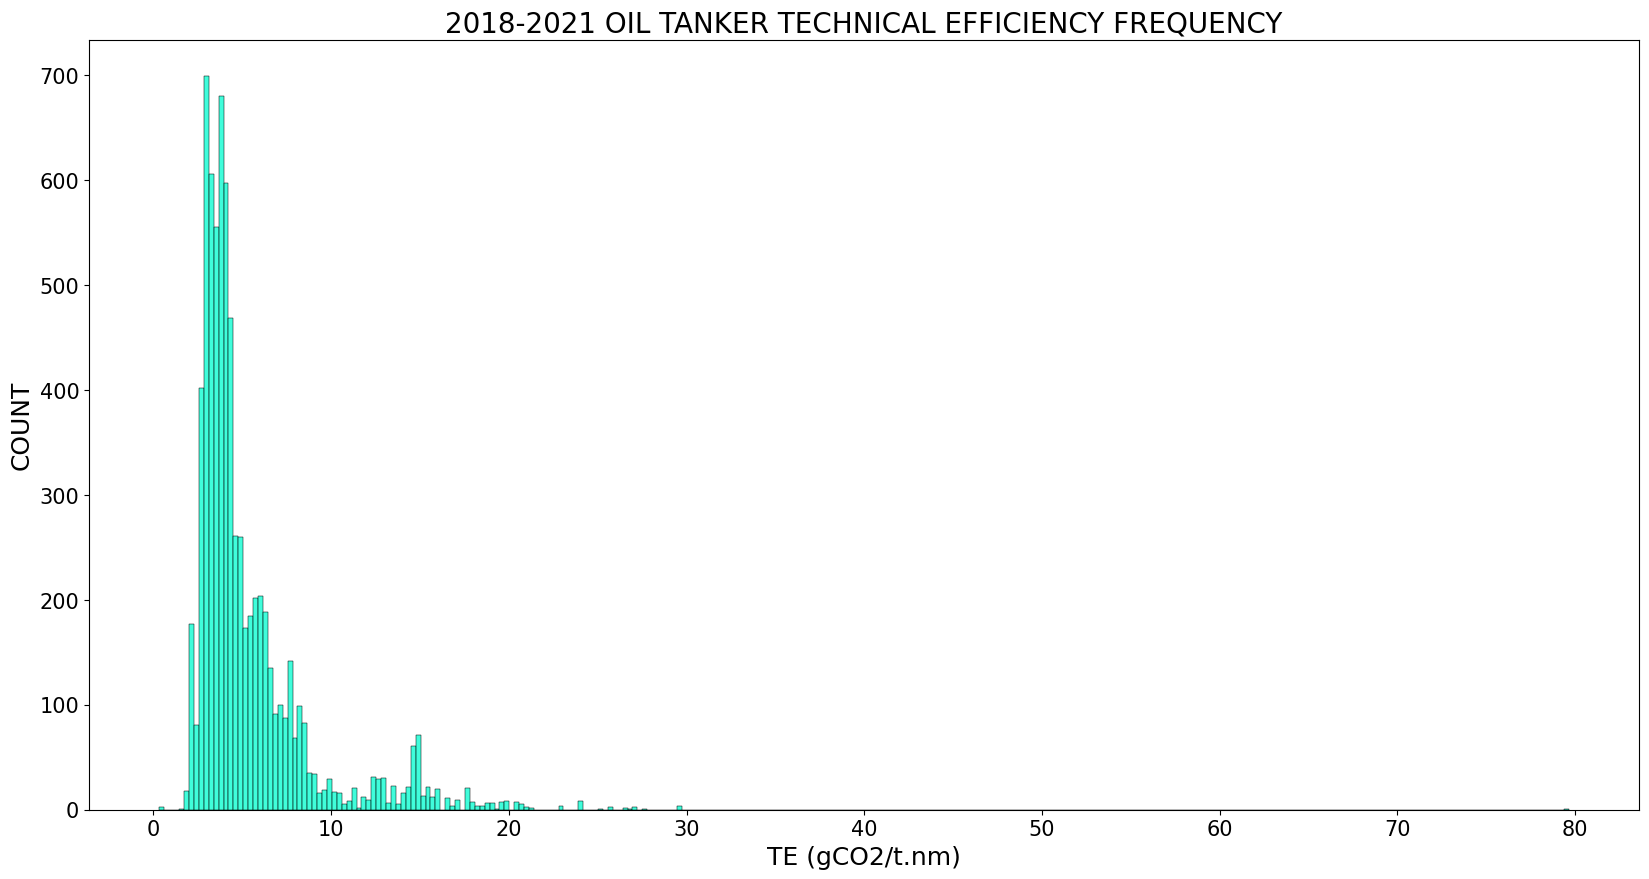

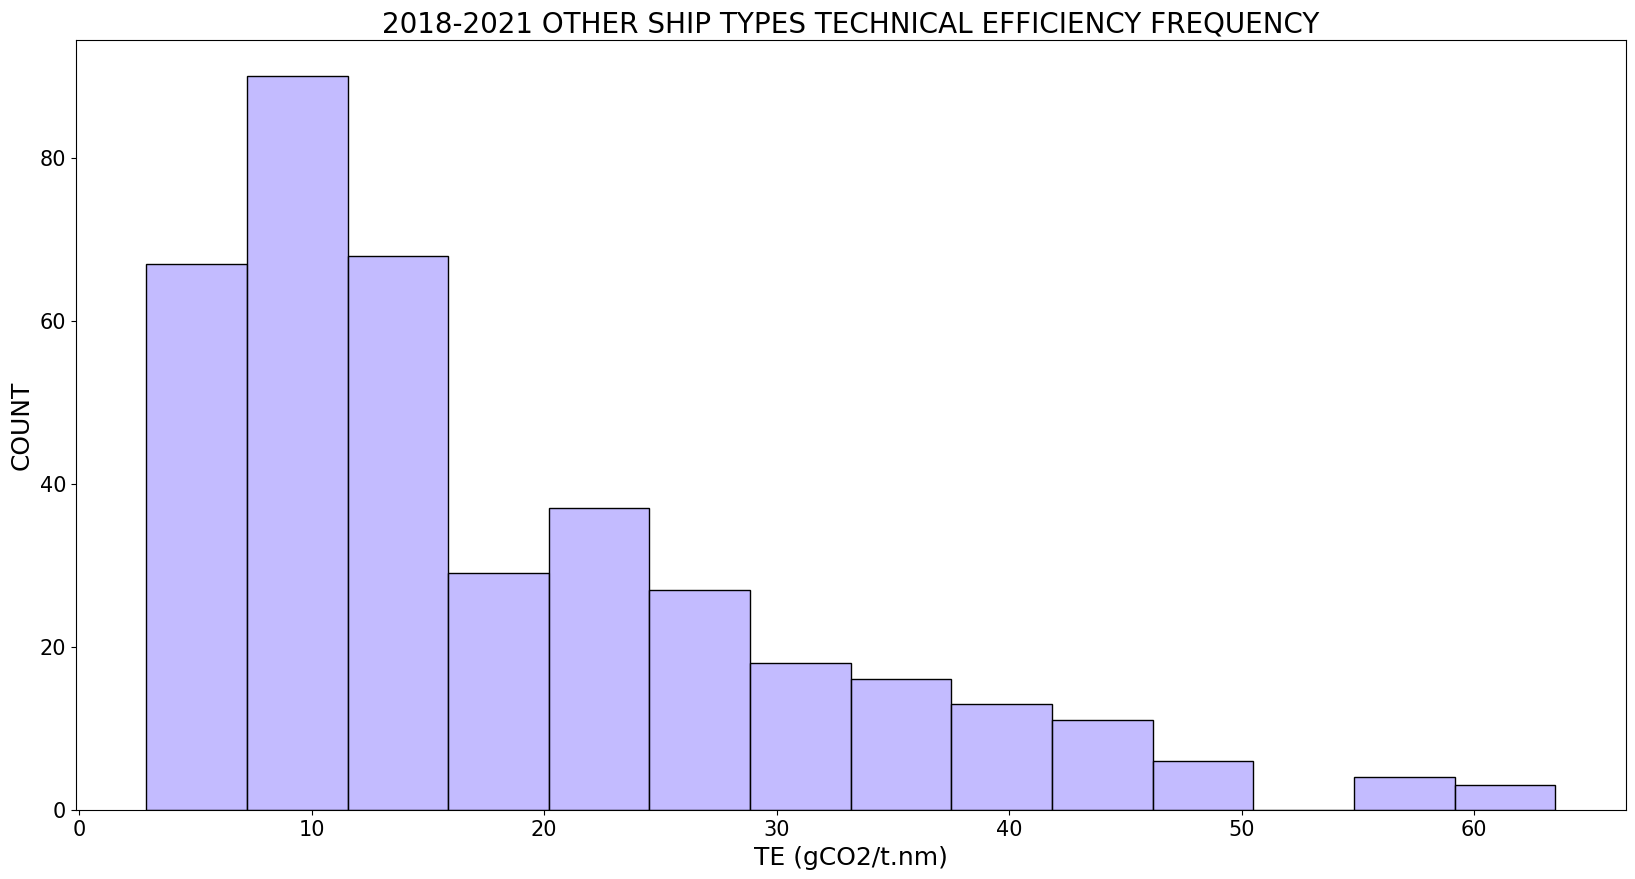

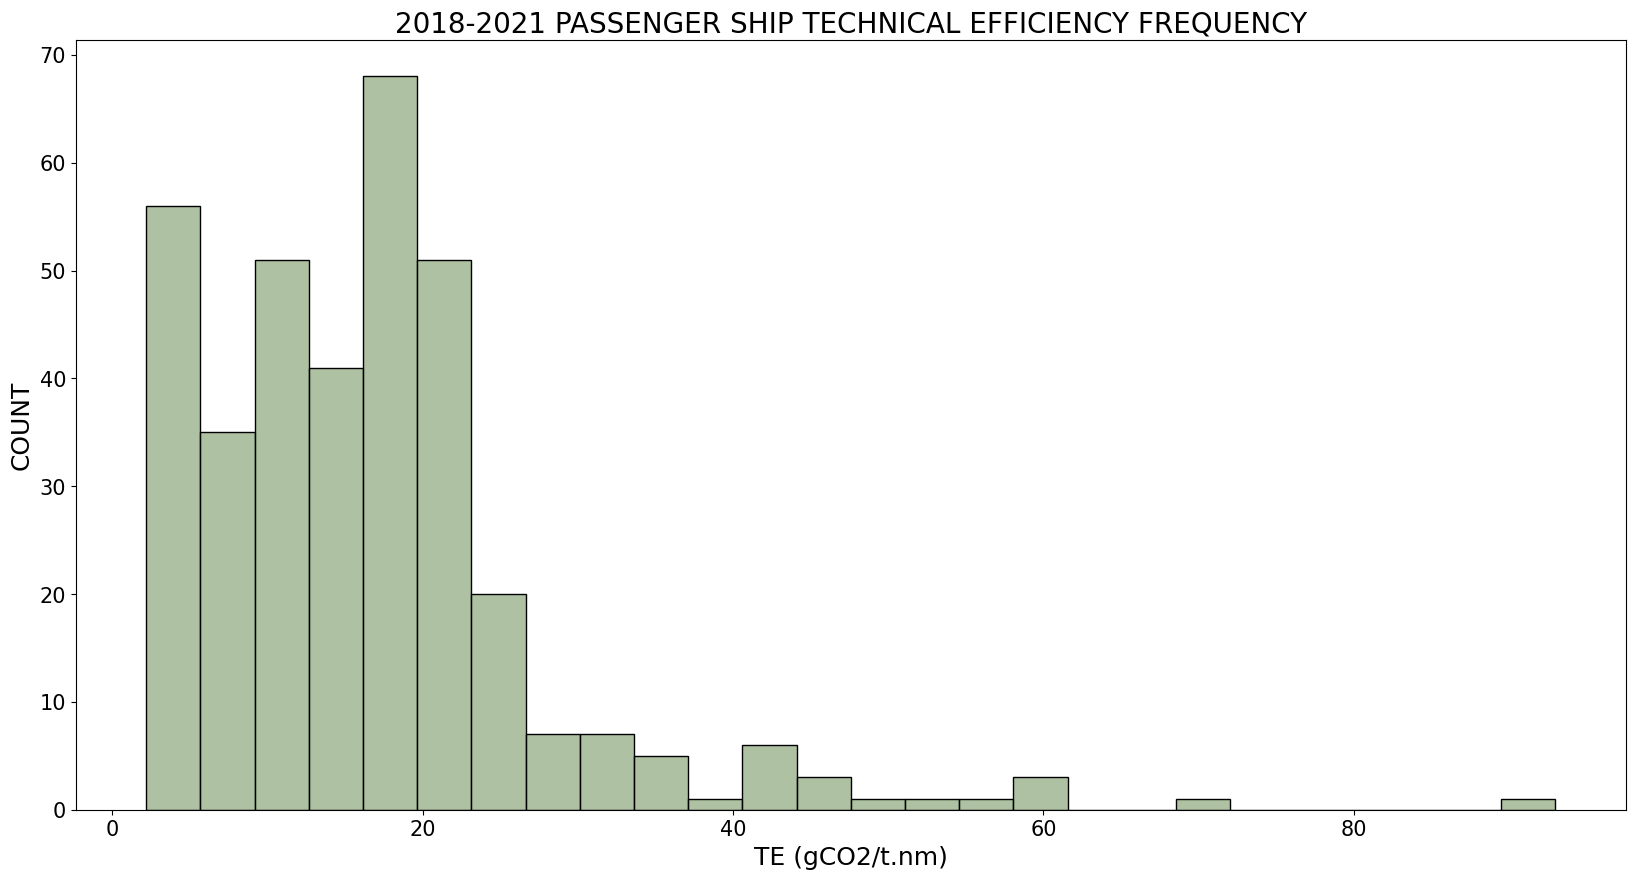

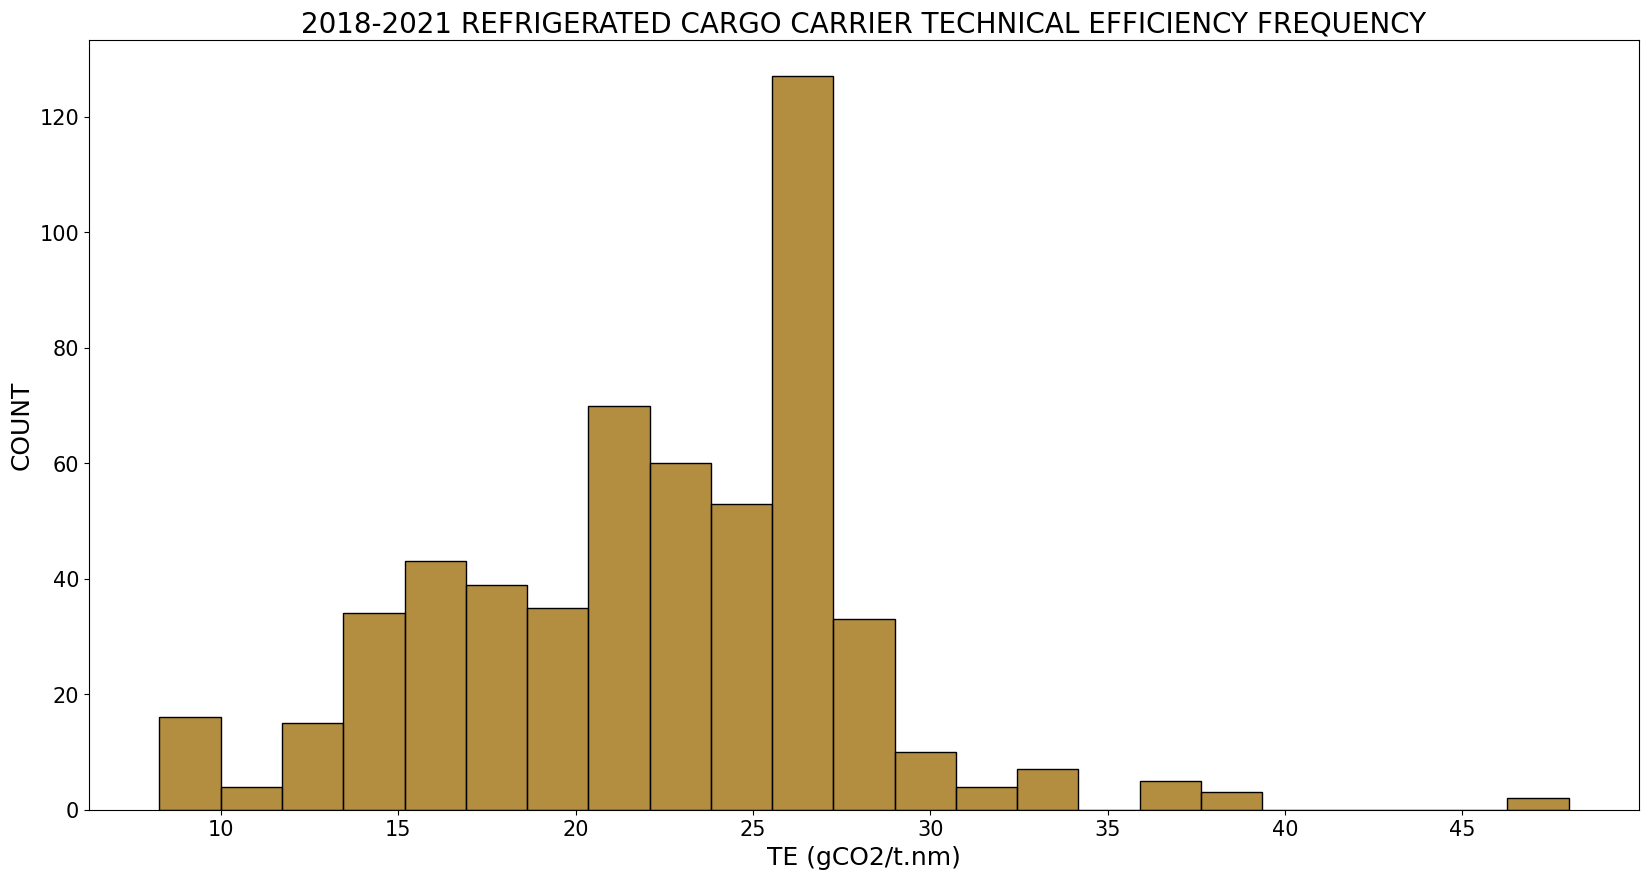

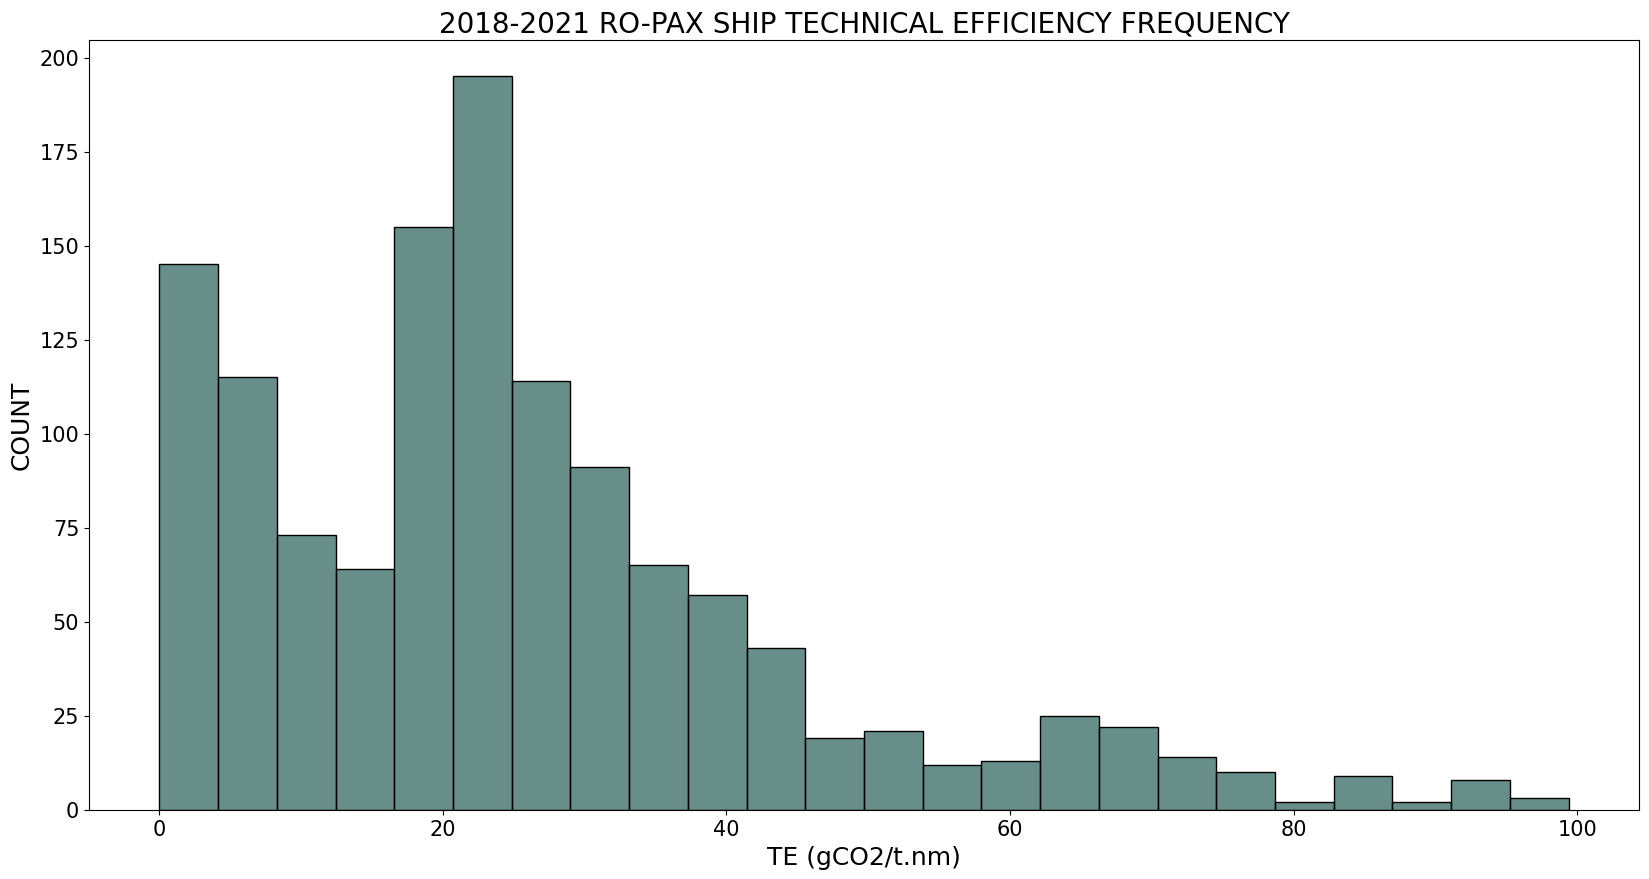

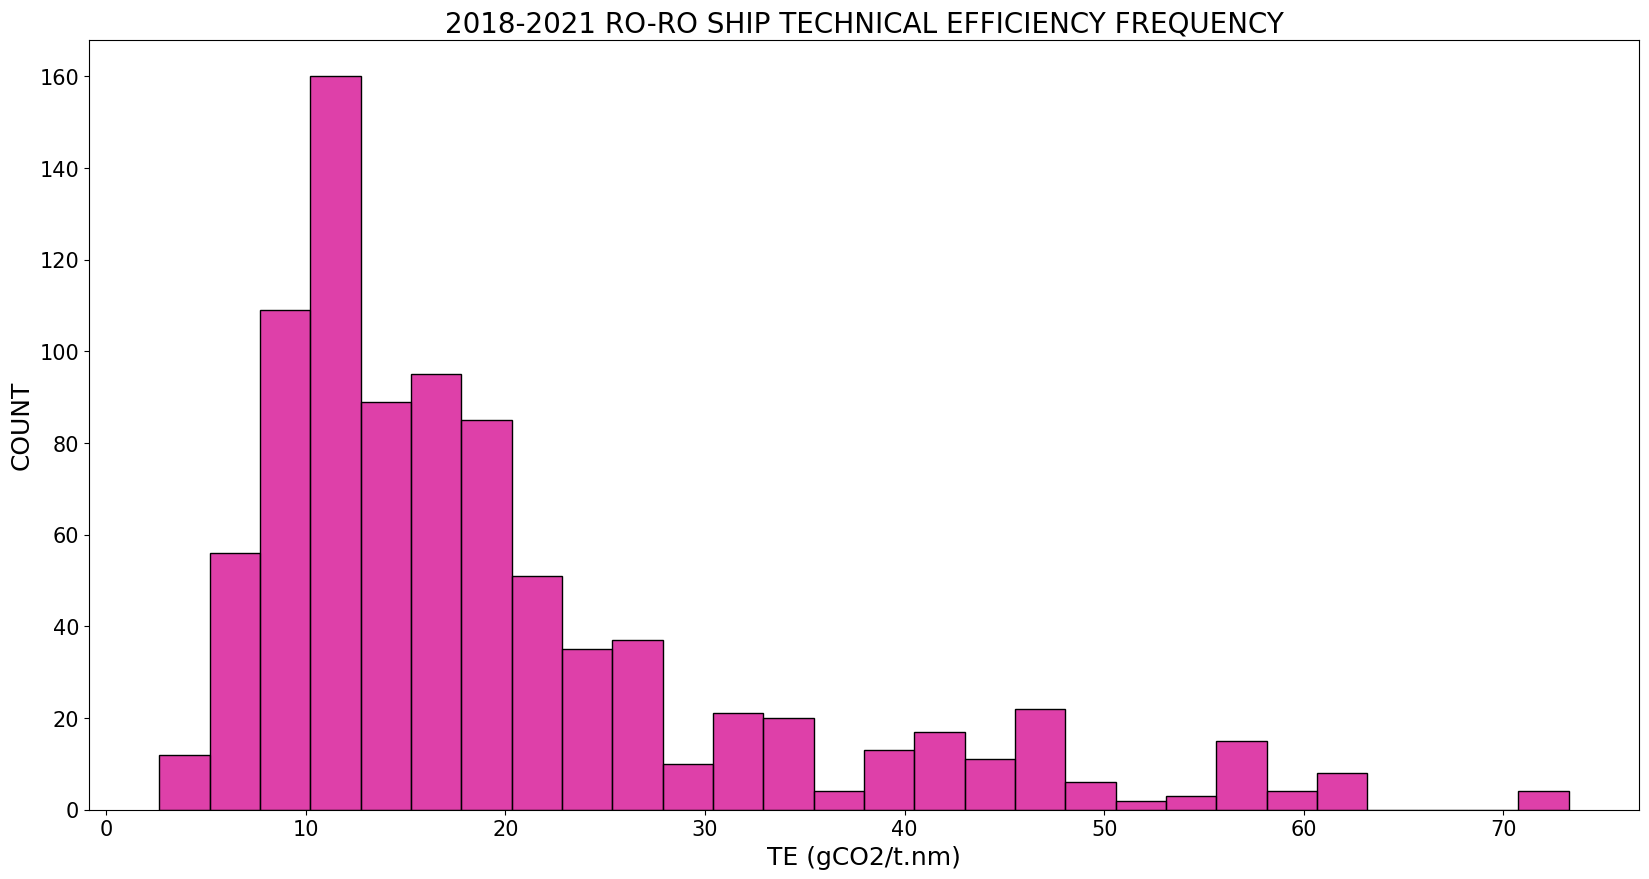

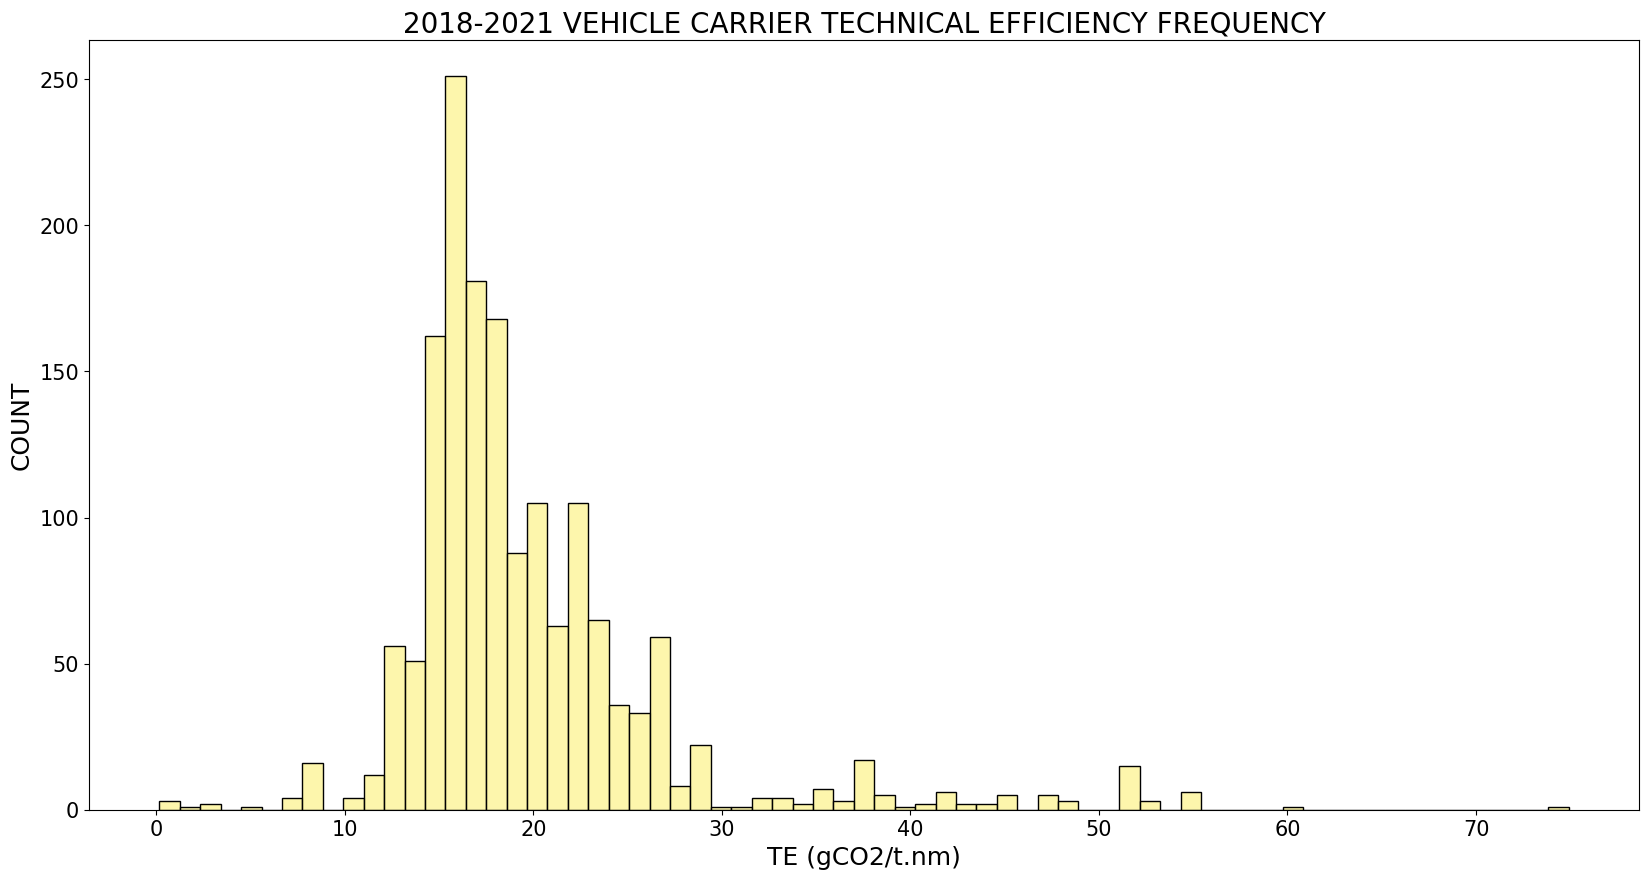

In [43]:
te_lim = 100
data = mrv_efficiency_df[mrv_efficiency_df.Technical_efficiency < te_lim]

for stype in sorted(data.Ship_type.unique()):

    plt.figure(figsize=(20, 10))
    plt.title(f"2018-2021 {stype.upper()} TECHNICAL EFFICIENCY FREQUENCY",
              fontsize=20)
    plt.xlabel("TE (gCO2/t.nm)", fontsize=18)
    plt.ylabel("COUNT", fontsize=18)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    sns.histplot(data=data[data.Ship_type == stype],
                 x="Technical_efficiency",
                 color=color_dict[stype])
    plt.show()

EMISSION PROFILE BY SHIP TYPE IN TERMS OF MEASURED TECHNICAL EFFICIENCY

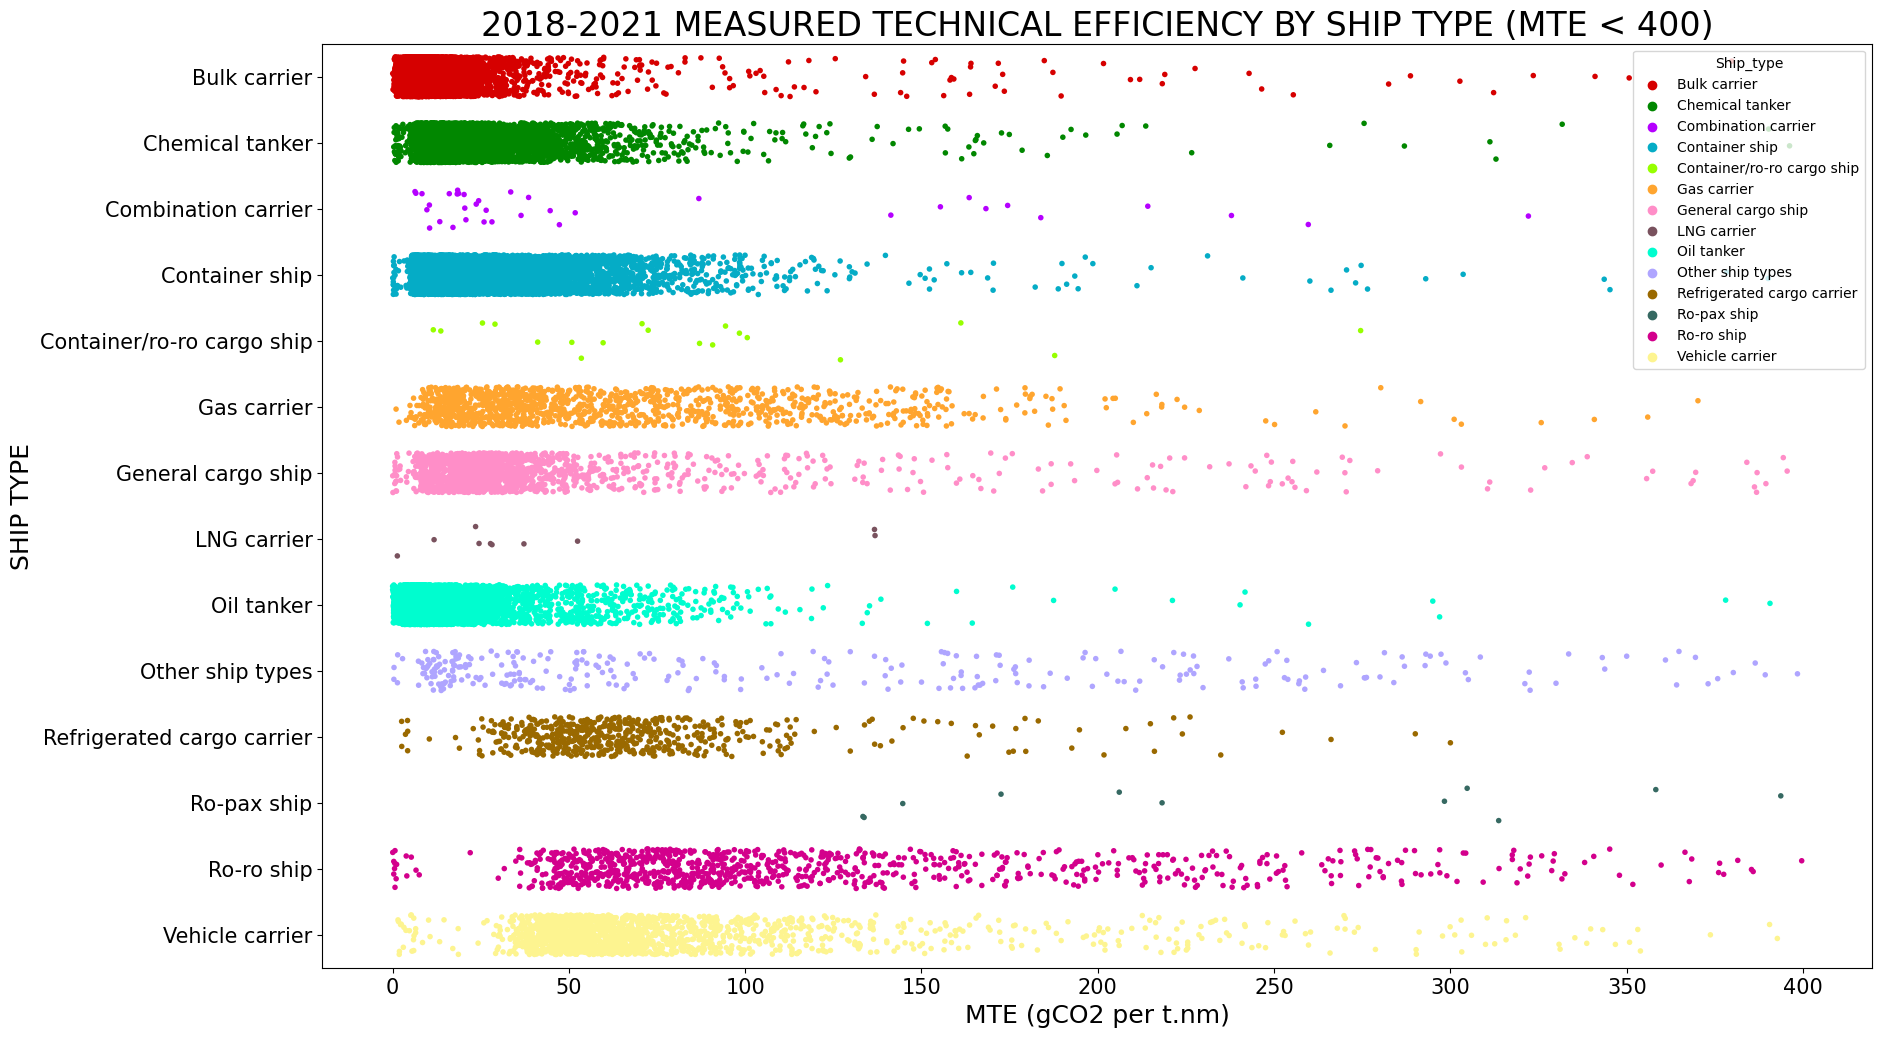

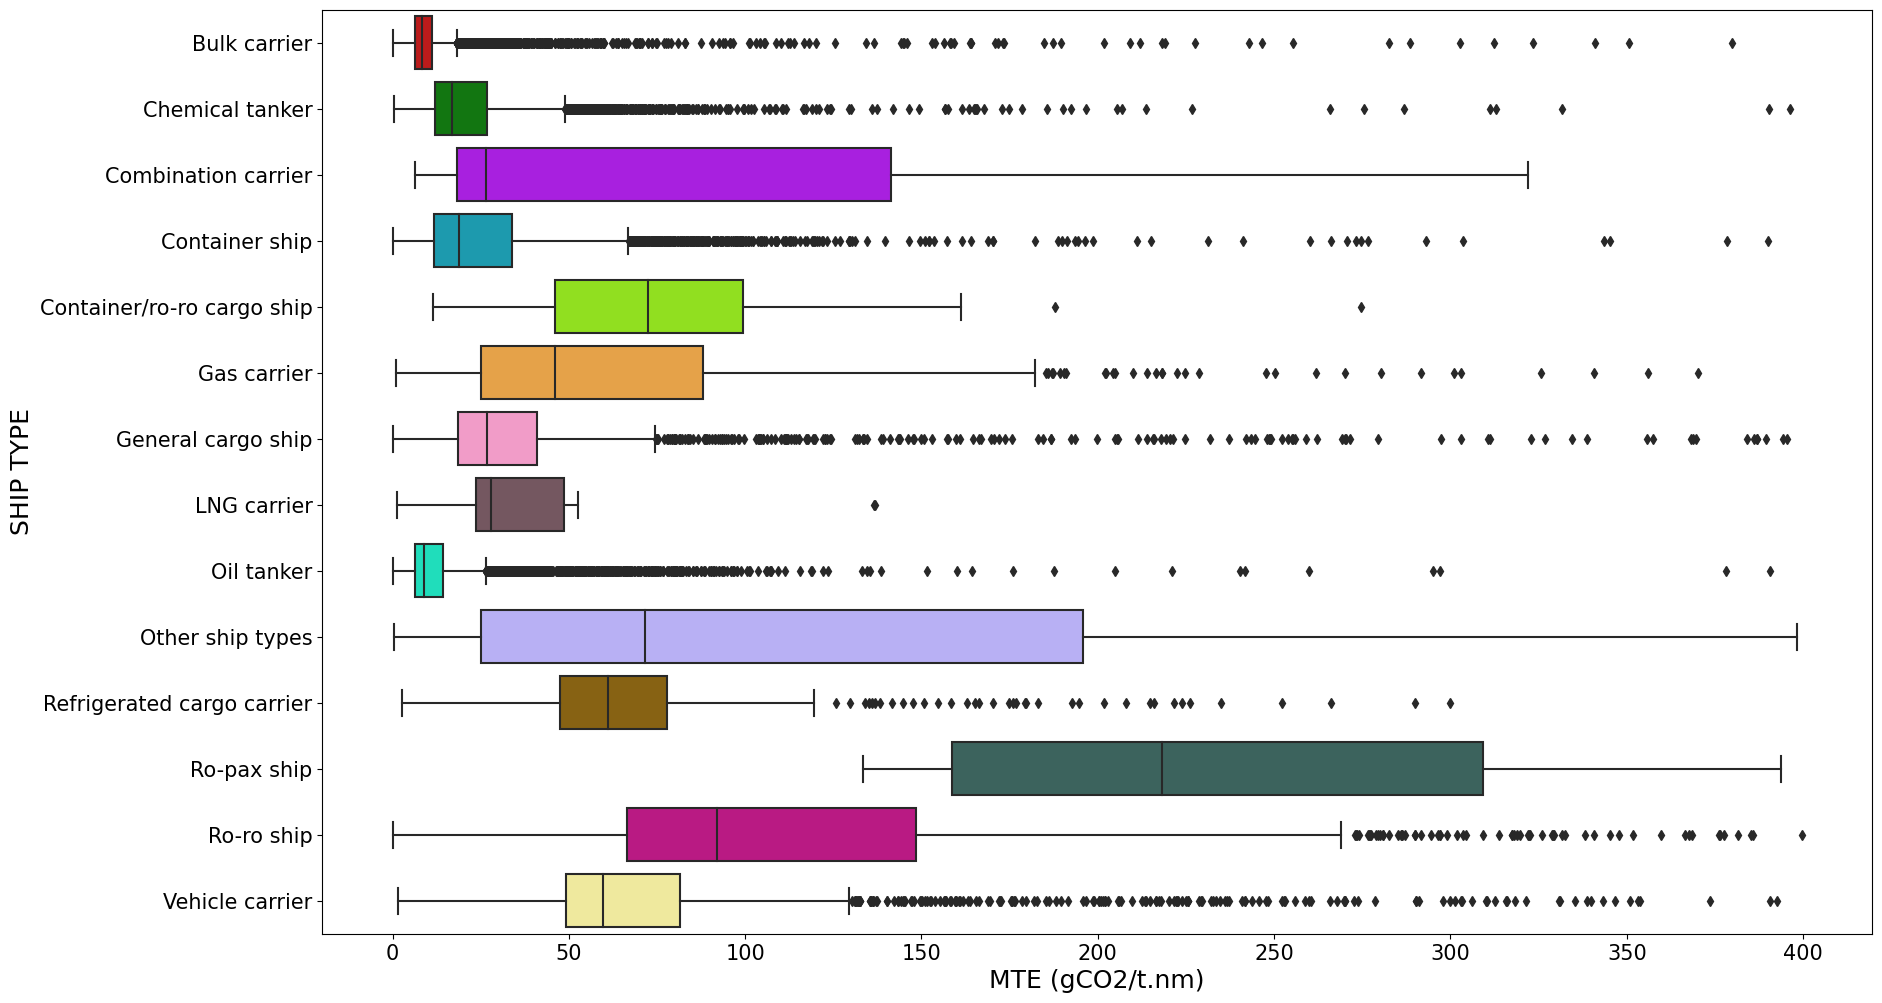

In [66]:
mte_lim = 400
data = mrv_efficiency_df[mrv_efficiency_df.Measured_efficiency < mte_lim]
plt.figure(figsize=(20, 12))
plt.title(f"2018-2021 MEASURED TECHNICAL EFFICIENCY BY SHIP TYPE (MTE < {mte_lim})",
          fontsize=24)
sns.stripplot(data=data.sort_values("Ship_type"),
              x="Measured_efficiency",
              y="Ship_type",
              jitter=0.3,
              hue="Ship_type",
              palette=color_dict,
              s=4)
plt.ylabel("SHIP TYPE", fontsize=18)
plt.xlabel("MTE (gCO2 per t.nm)", fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

plt.figure(figsize=(20, 12))
sns.boxplot(data=data.sort_values("Ship_type"),
            x="Measured_efficiency",
            y="Ship_type",
            palette=color_dict)
plt.ylabel("SHIP TYPE", fontsize=18)
plt.xlabel("MTE (gCO2/t.nm)", fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

SHIP TYPE MEASURED TECHNICAL EFFICIENCY FREQUENCY DISTRIBUTION

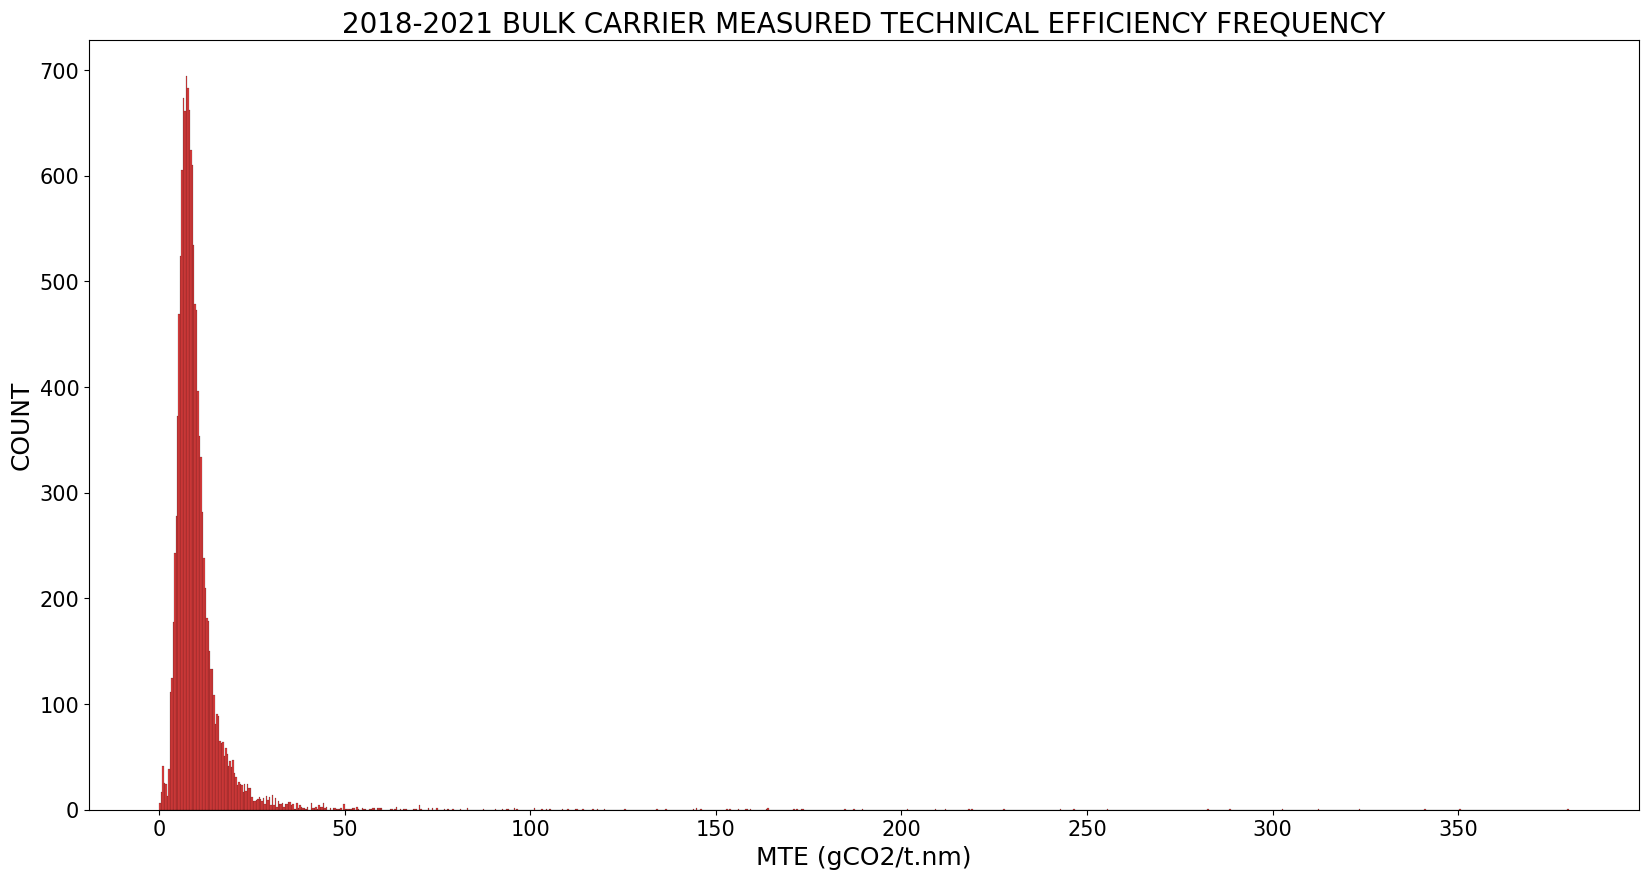

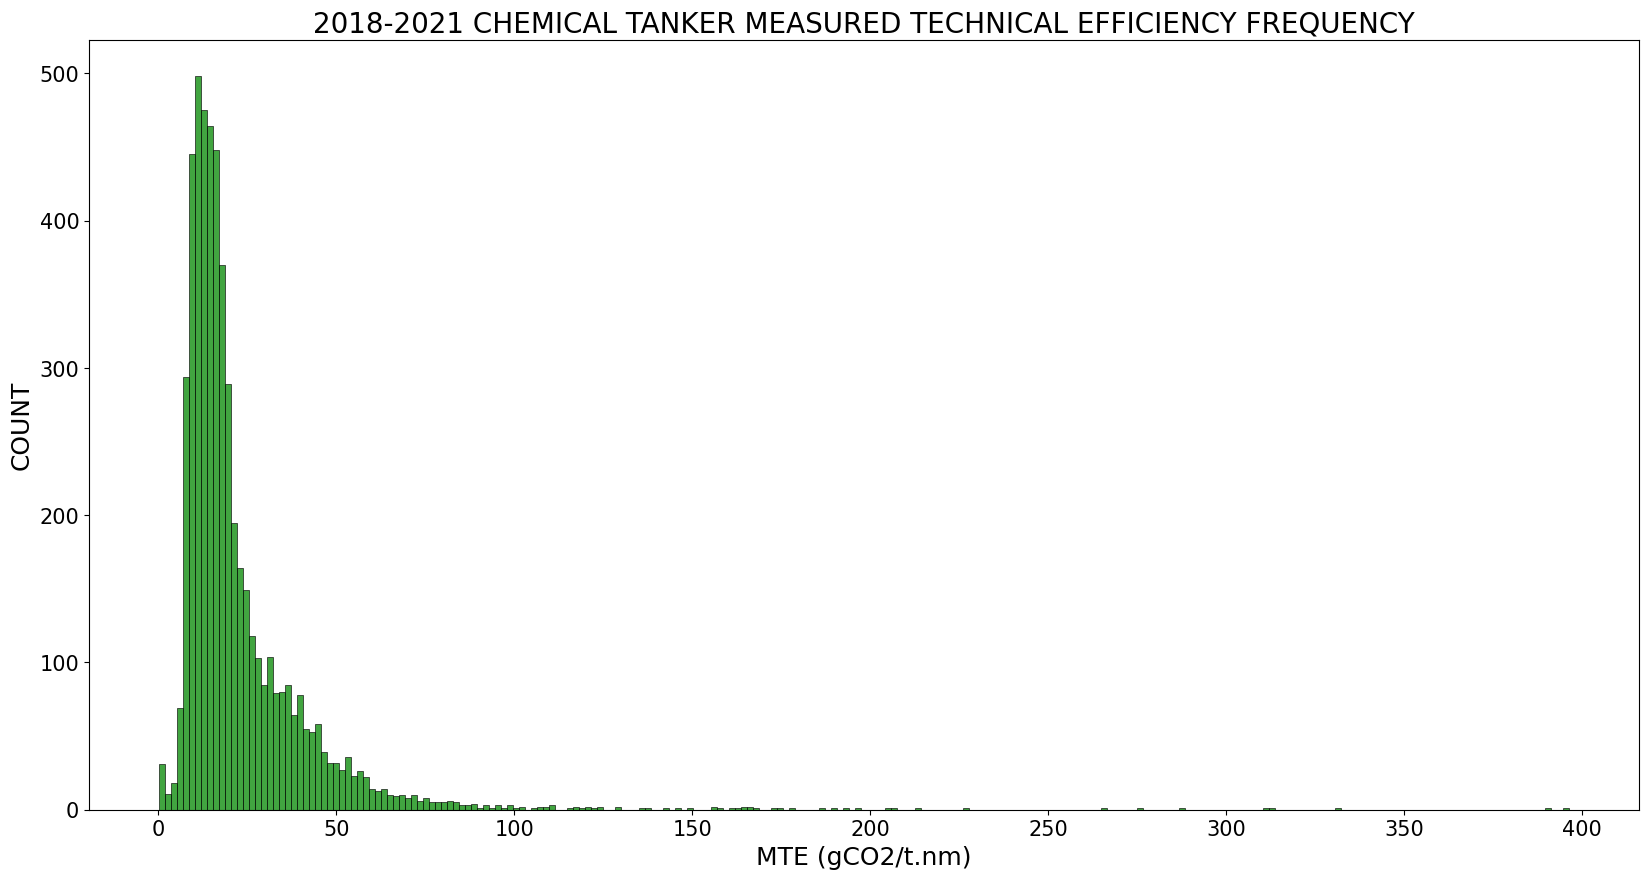

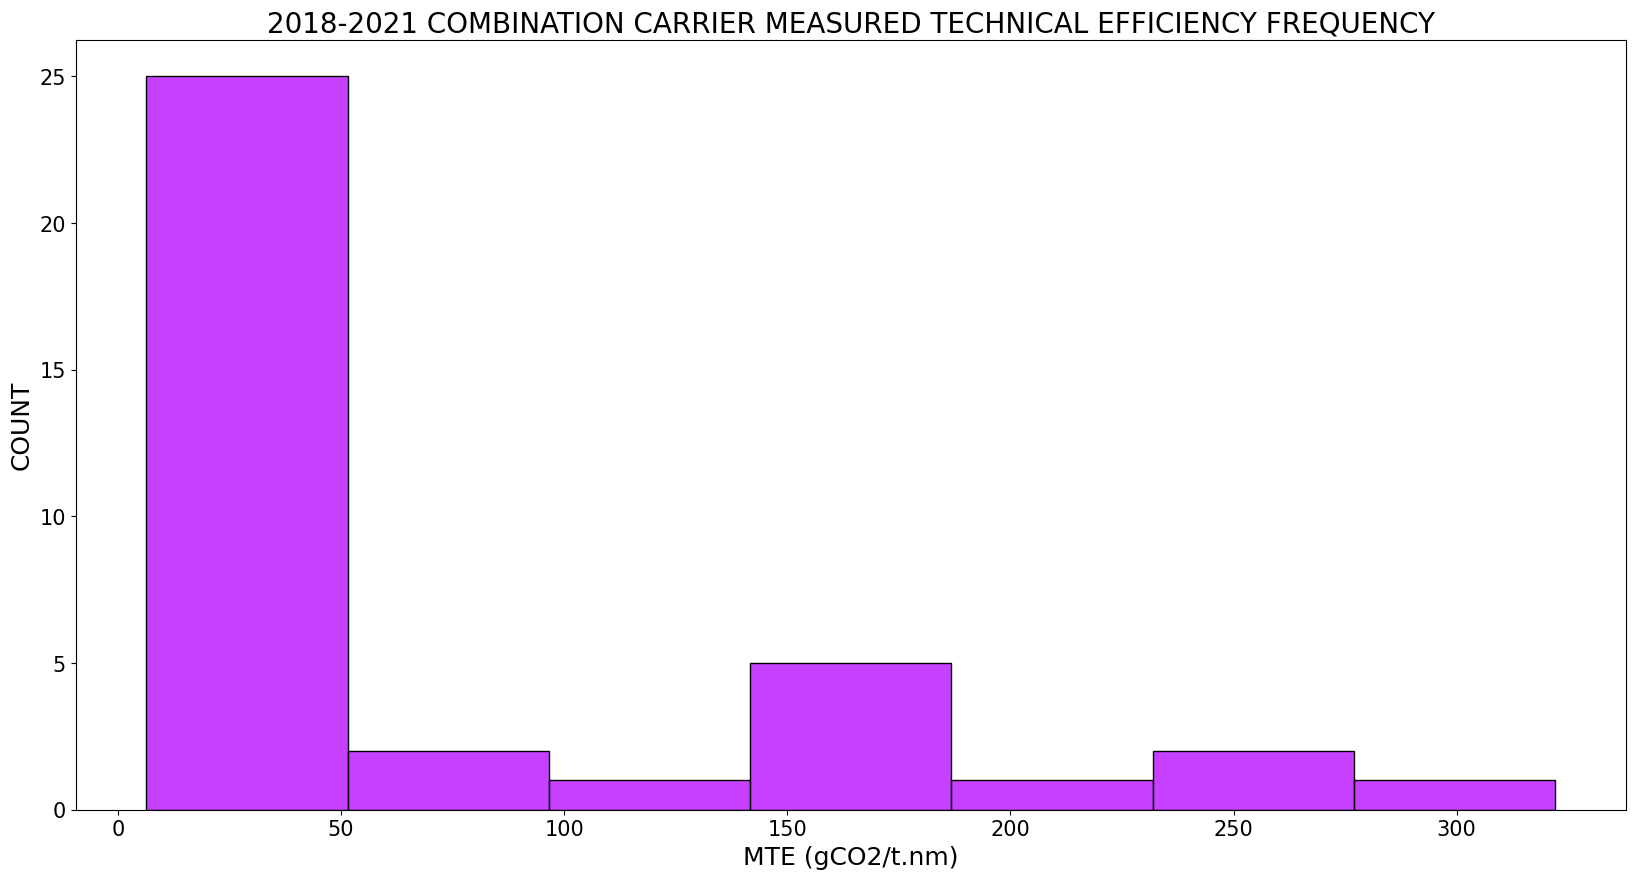

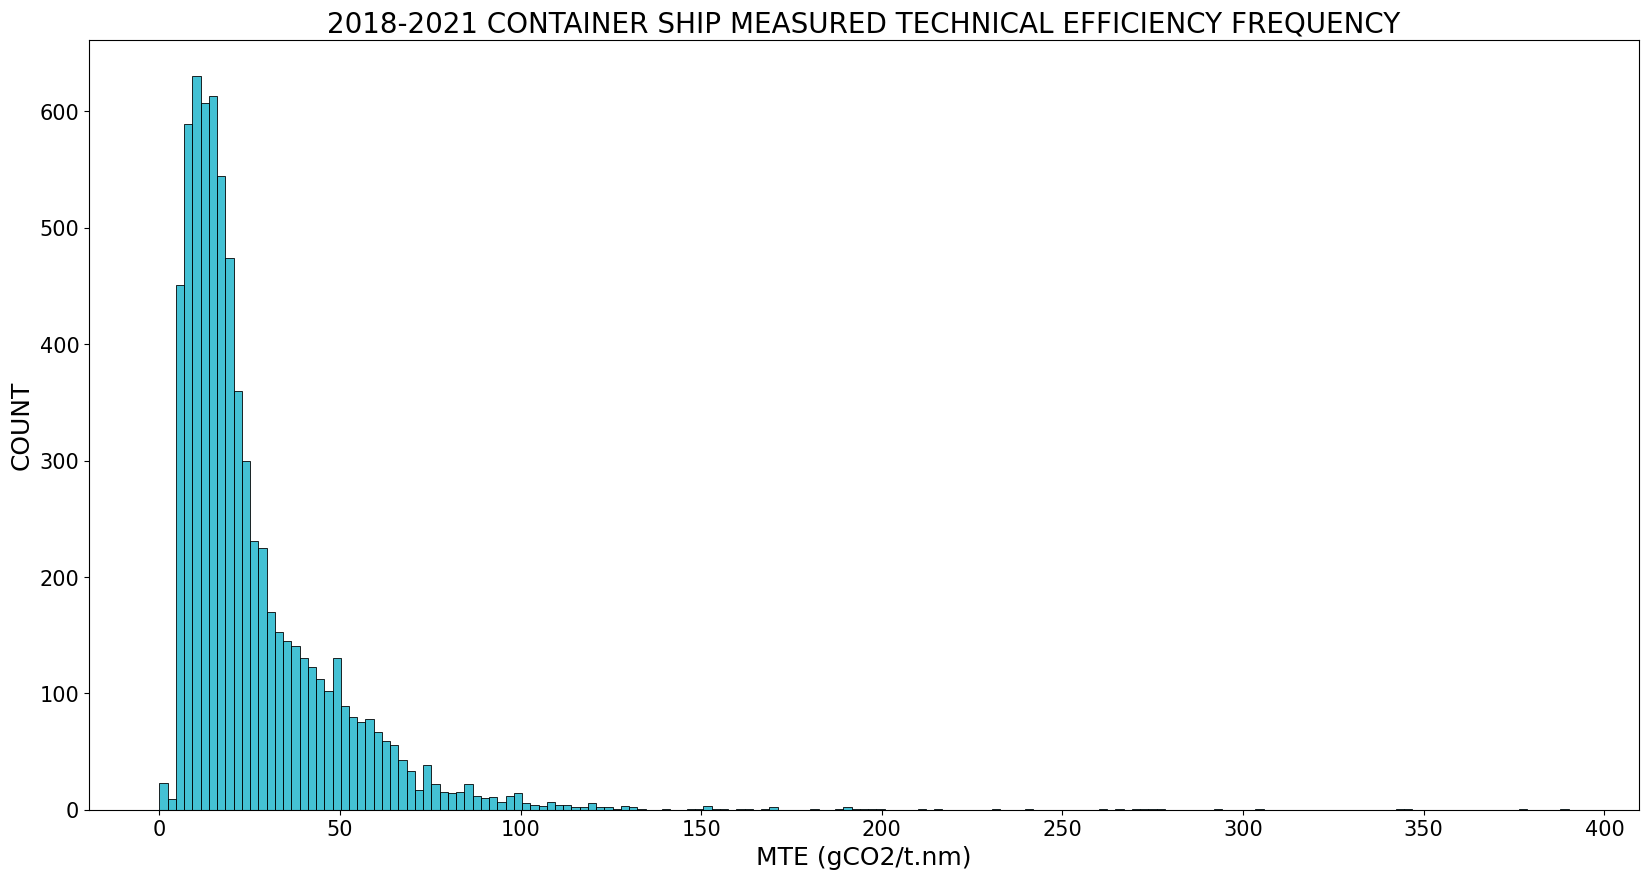

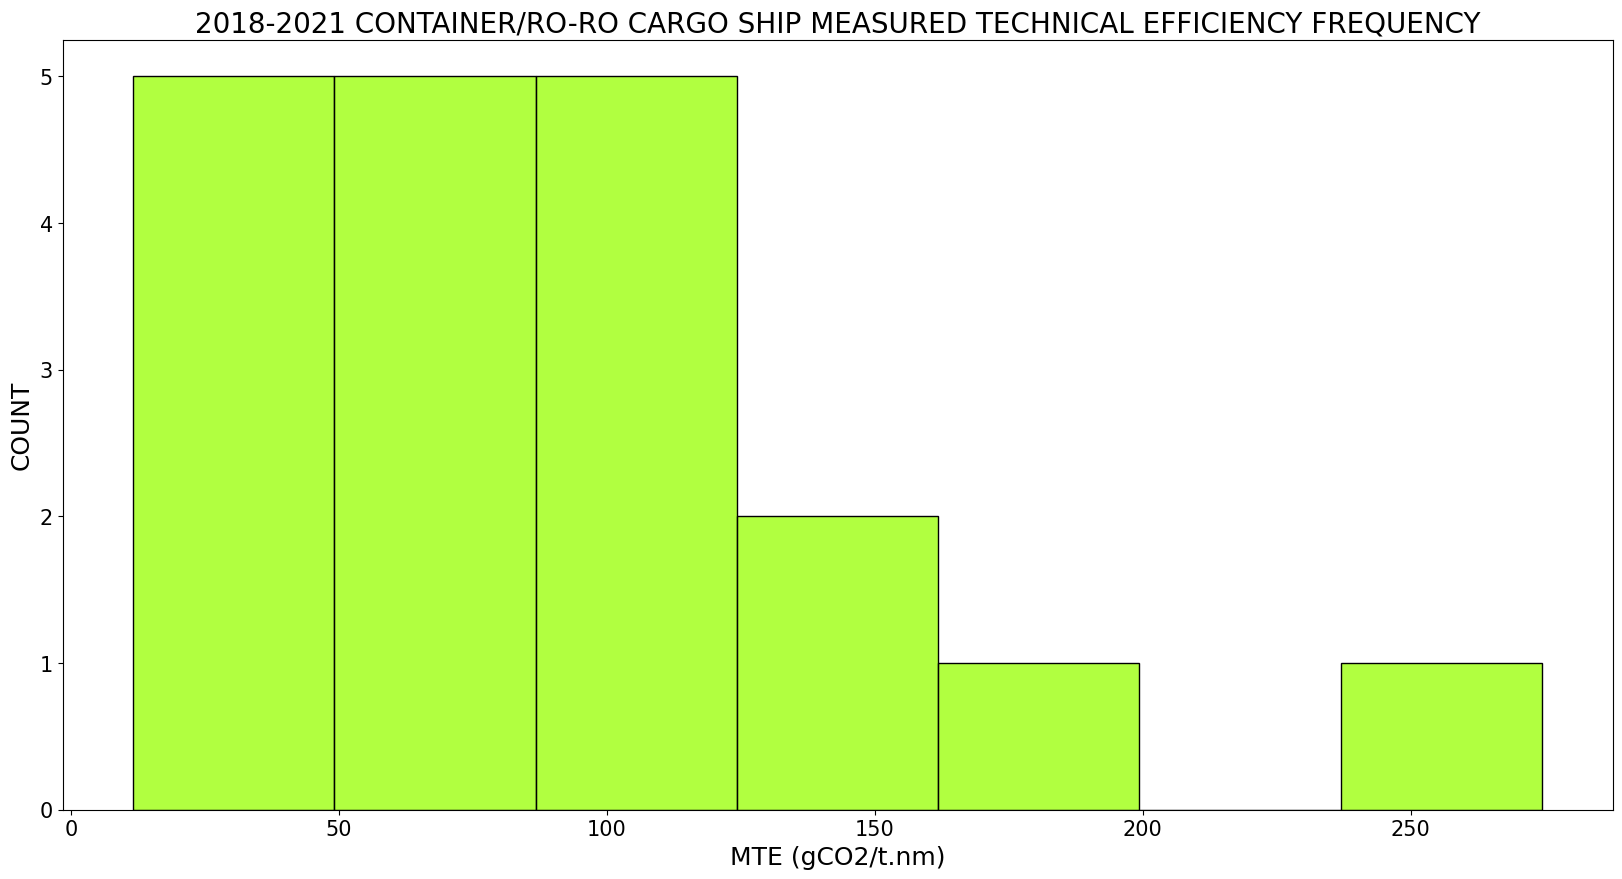

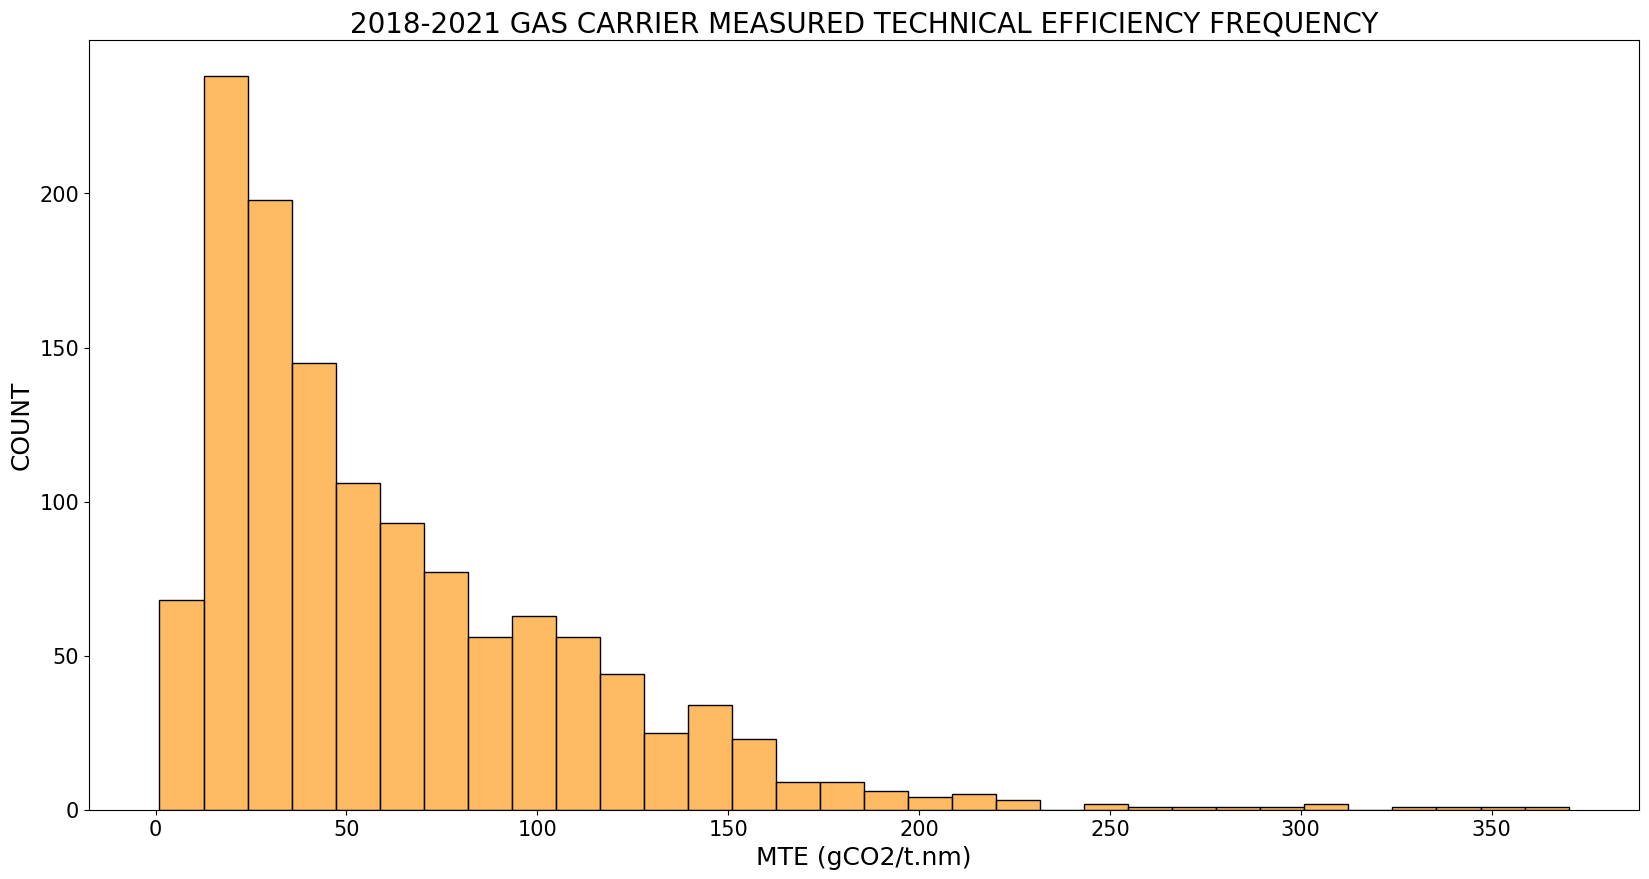

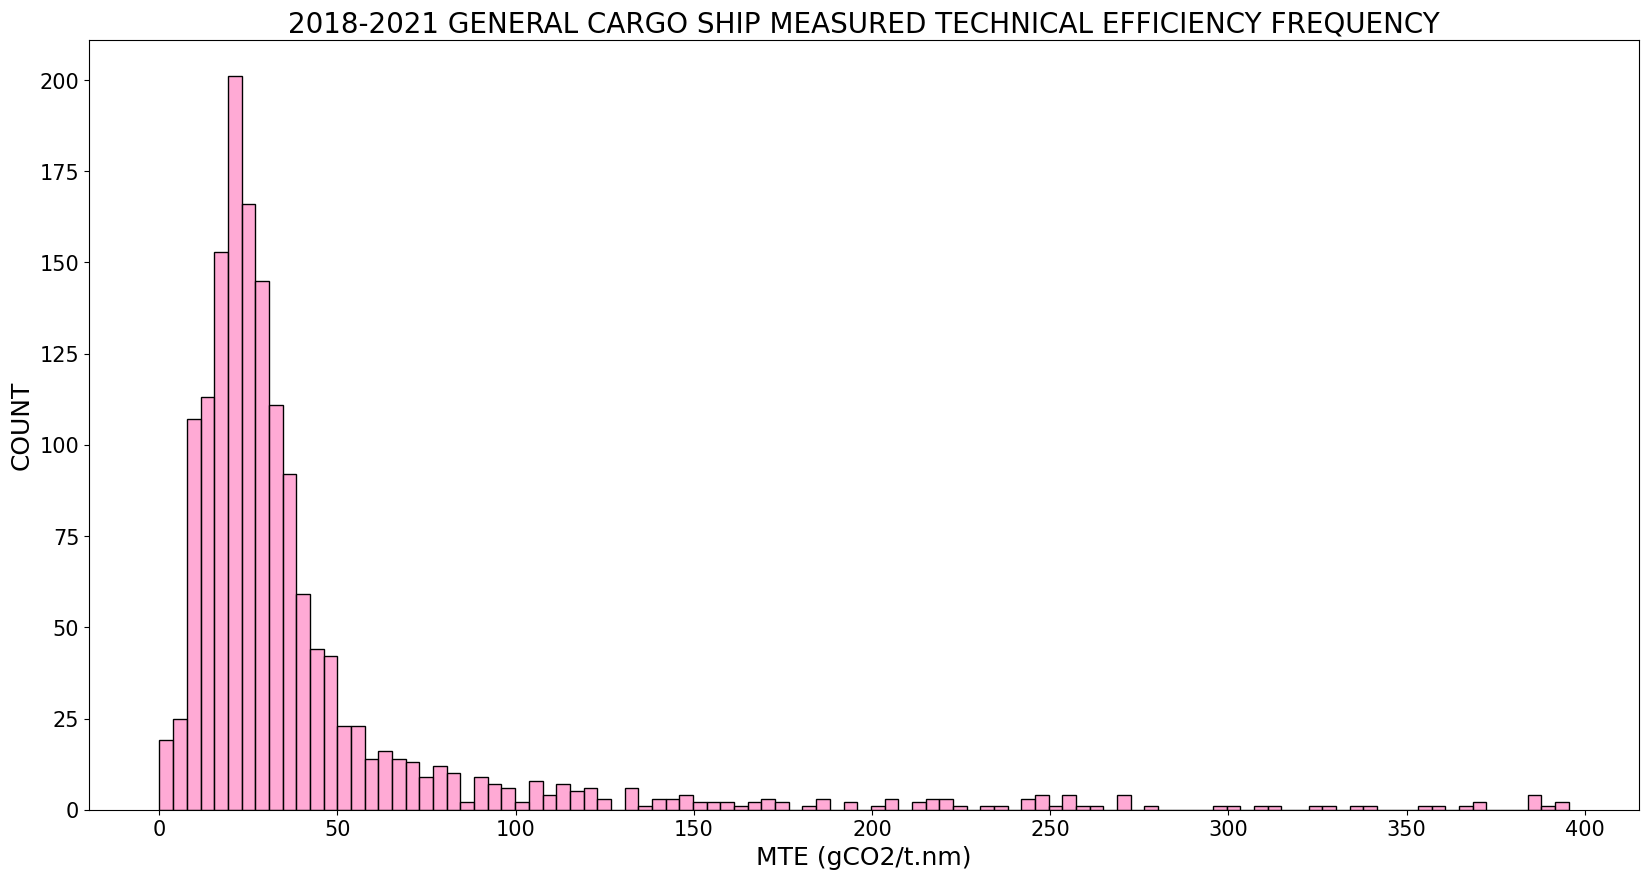

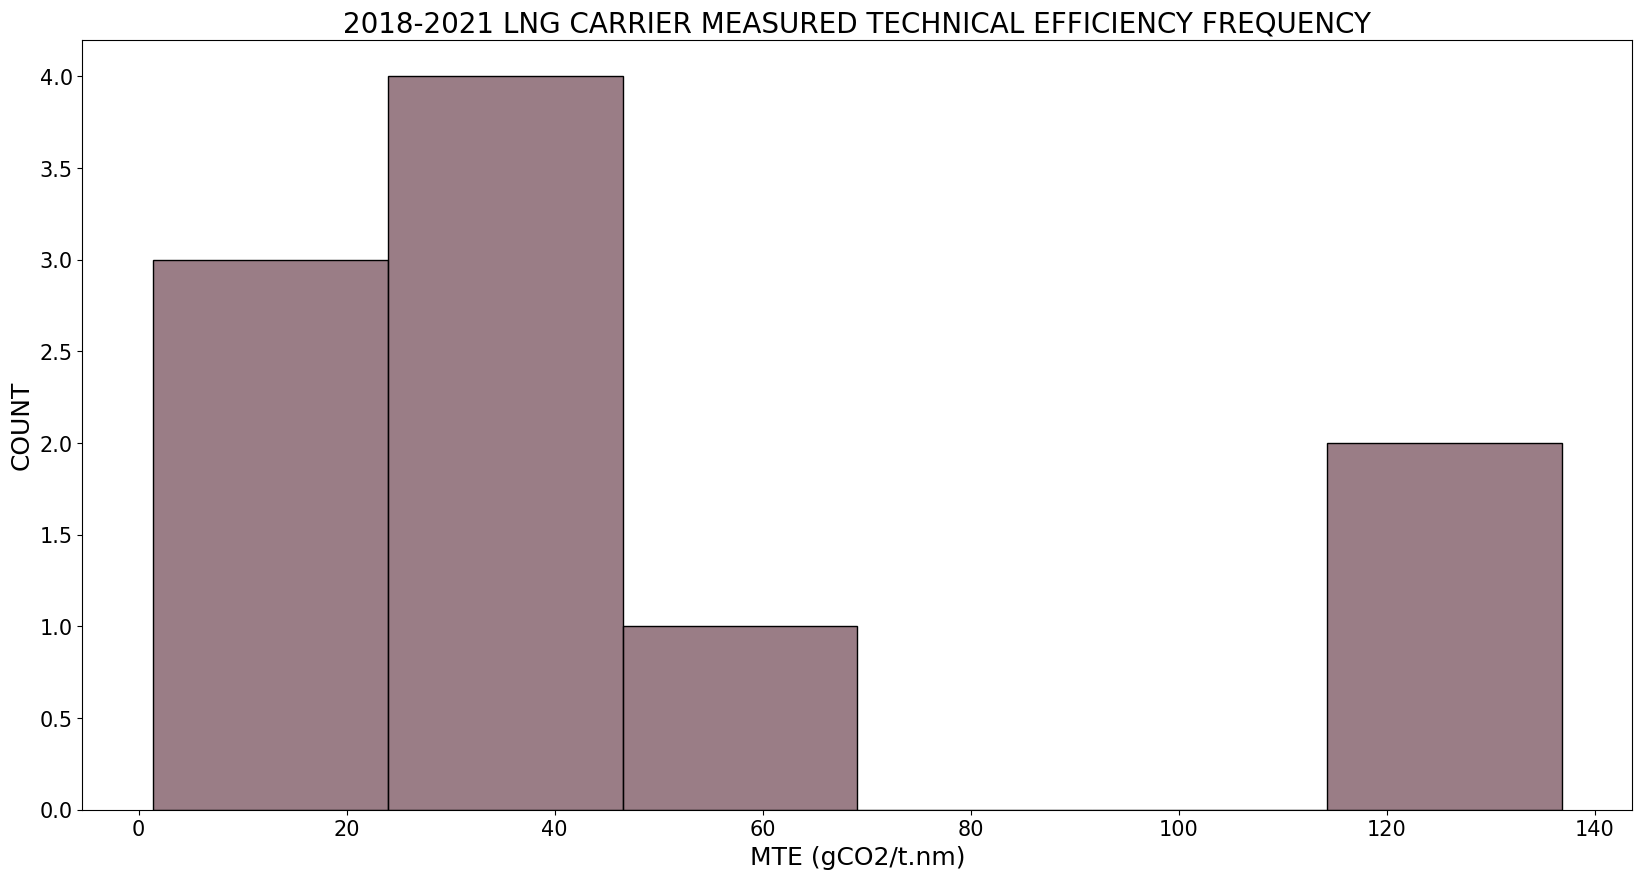

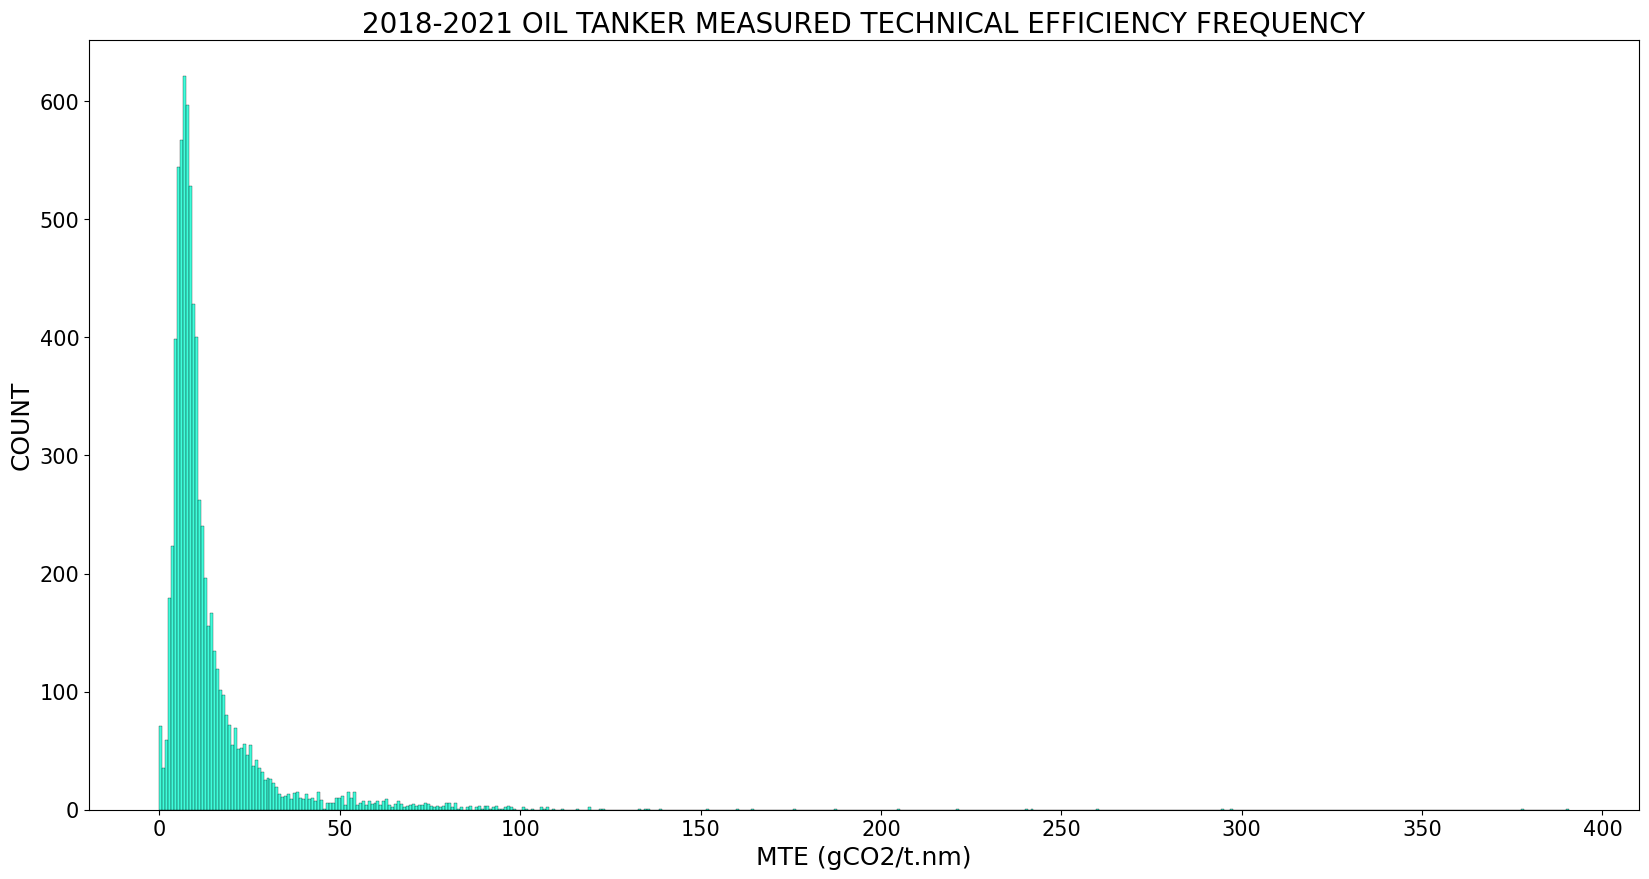

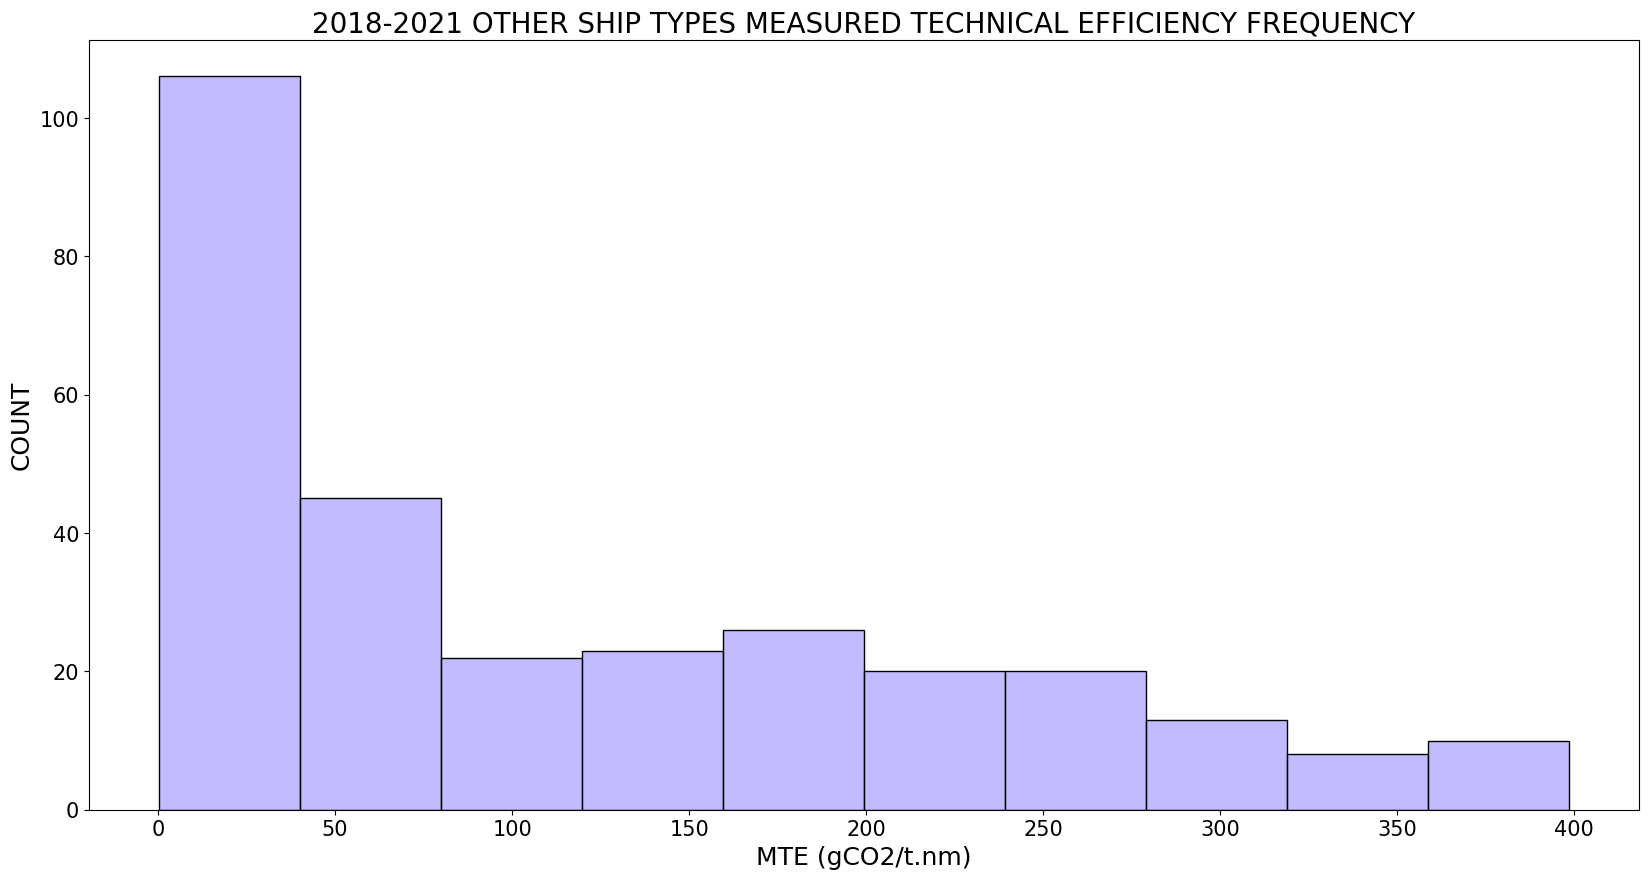

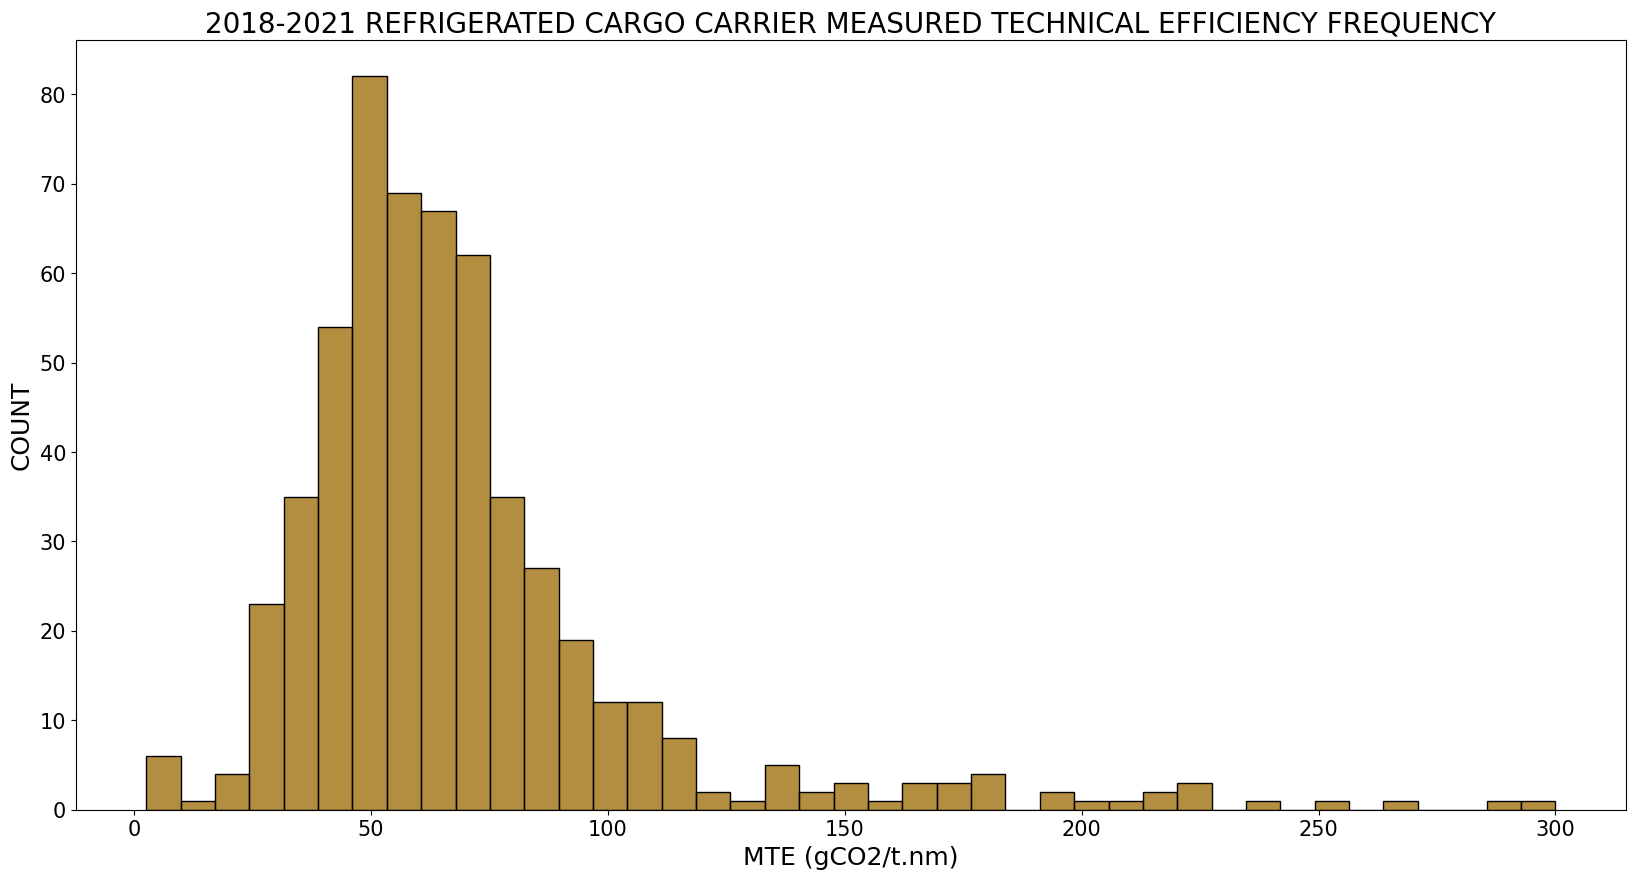

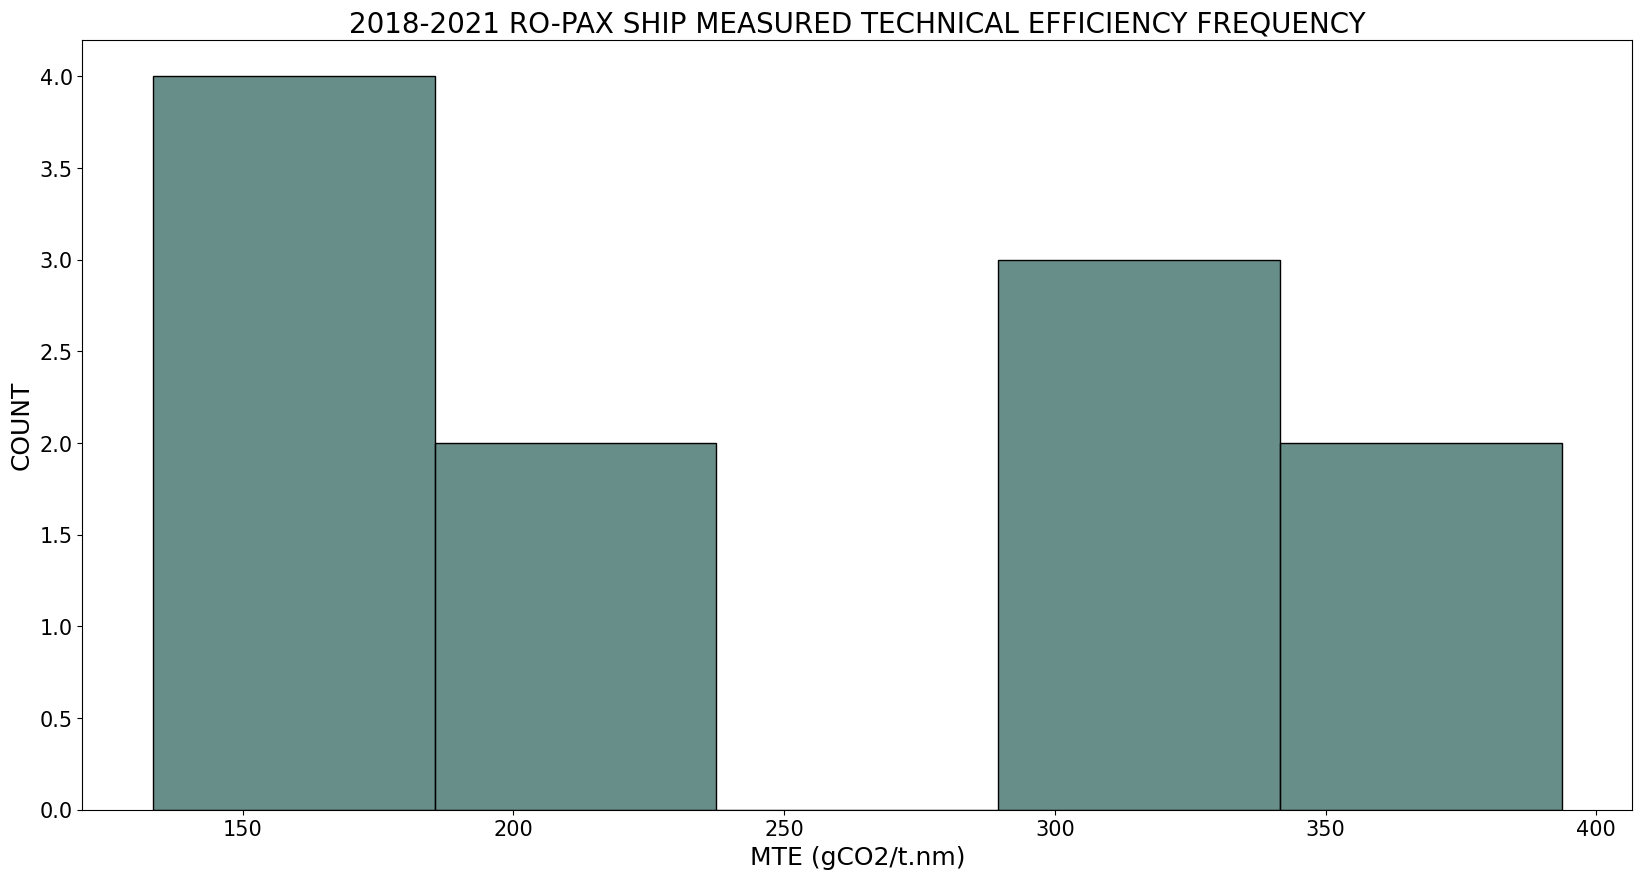

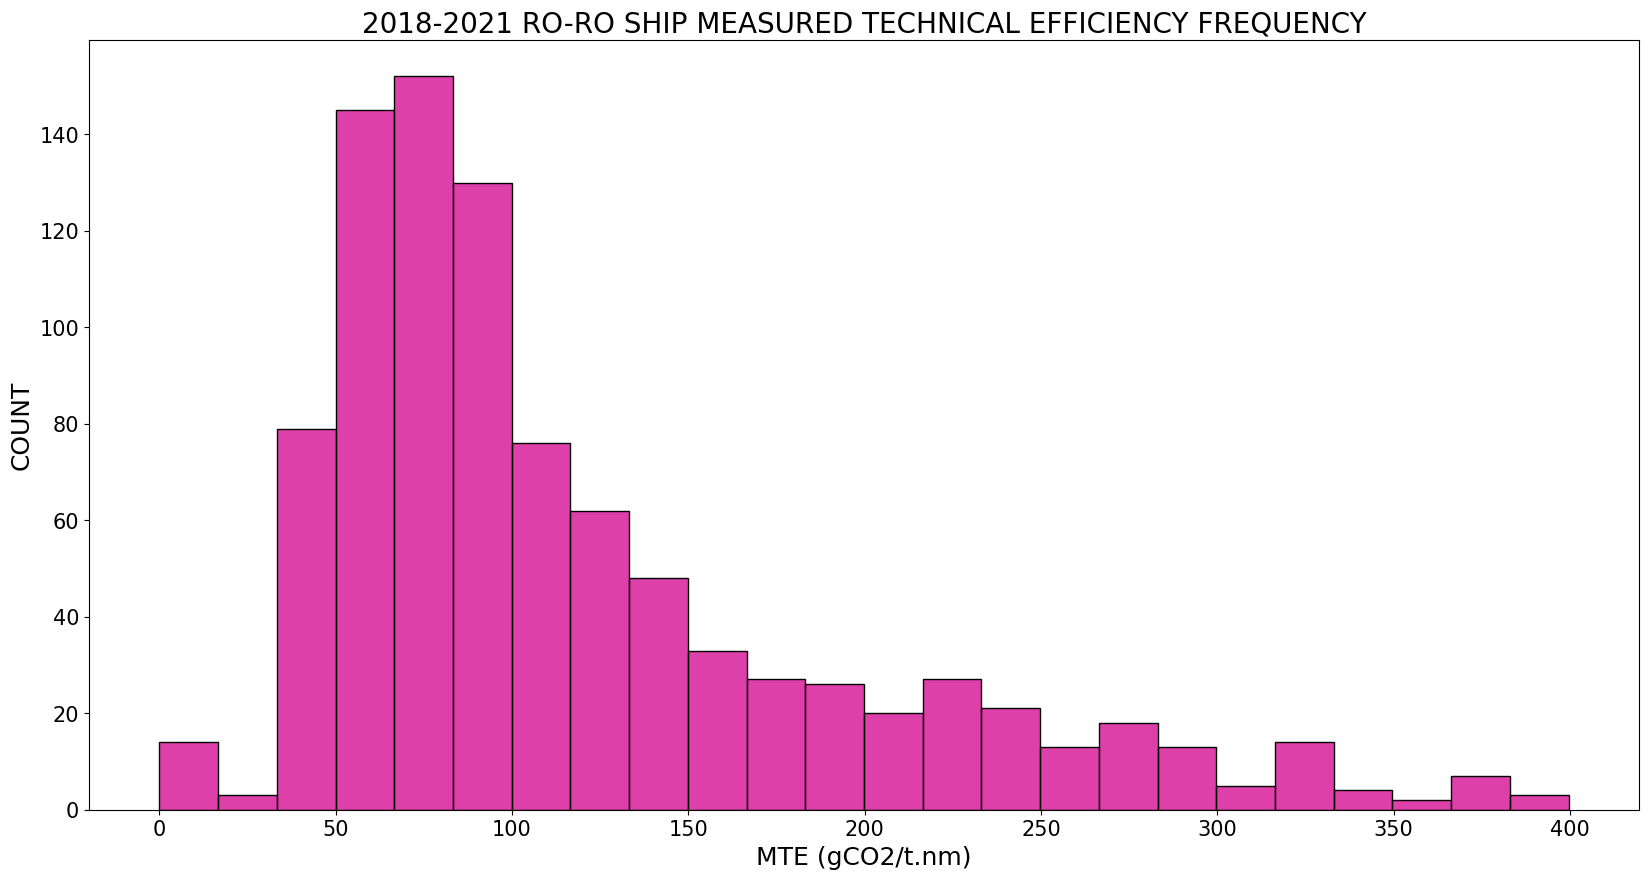

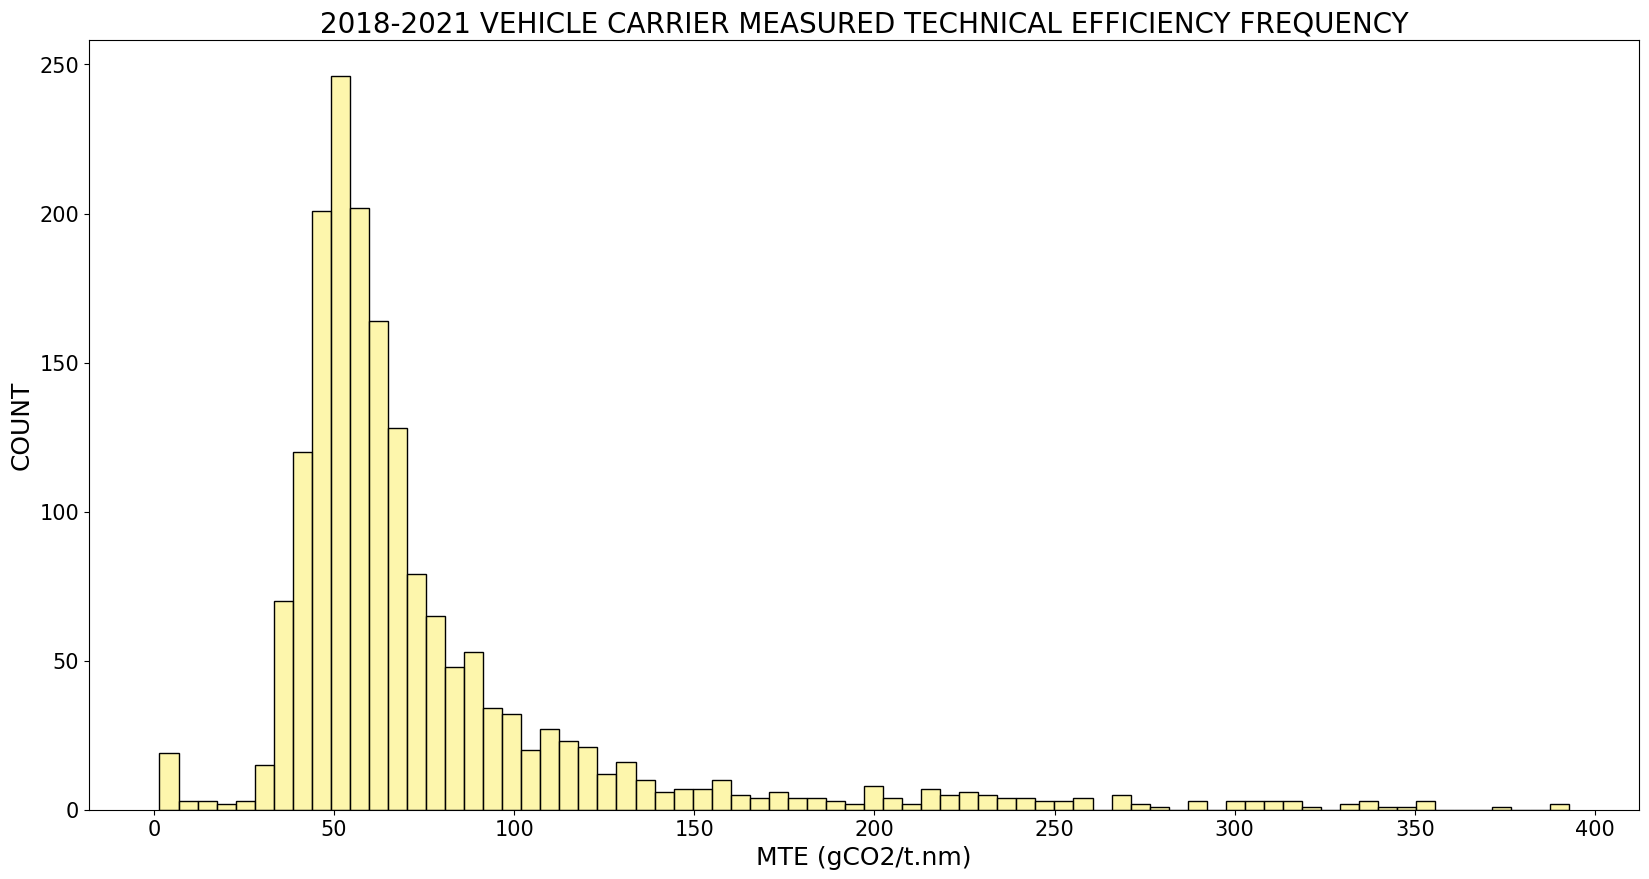

In [45]:
mte_lim = 400
data = mrv_efficiency_df[mrv_efficiency_df.Measured_efficiency < mte_lim]
for stype in sorted(data.Ship_type.unique()):

    plt.figure(figsize=(20, 10))
    plt.title(
        f"2018-2021 {stype.upper()} MEASURED TECHNICAL EFFICIENCY FREQUENCY",
        fontsize=20)
    plt.xlabel("MTE (gCO2/t.nm)", fontsize=18)
    plt.ylabel("COUNT", fontsize=18)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    sns.histplot(data=data[data.Ship_type == stype],
                 x="Measured_efficiency",
                 color=color_dict[stype])
    plt.show()

We can also view ship type emission profile in terms of the sum of all emissions by the ship type, indicating the footprint of the sub industry as a whole, as well as the emission per ship per year. 

In [76]:
# Selecting and processing data

total_CO2_summed = mrv_df[[
    "Ship_type", "Total_CO₂_emissions_[m_tonnes]"
]].groupby("Ship_type").sum().sort_values("Total_CO₂_emissions_[m_tonnes]",
                                          ascending=False)

total_CO2_summed["Ship_Count"] = mrv_df[[
    "Ship_type", "Total_CO₂_emissions_[m_tonnes]"
]].groupby("Ship_type").count()

total_CO2_summed["CO2_per_Ship_yr"] = total_CO2_summed[
    "Total_CO₂_emissions_[m_tonnes]"] / total_CO2_summed["Ship_Count"]
total_CO2_summed

Total_CO₂_emissions_[m_tonnes]  Ship_Count  \
Ship_type                                                                
Container ship                                1.723914e+08        7344   
Oil tanker                                    7.423435e+07        7692   
Bulk carrier                                  6.684456e+07       14688   
Ro-pax ship                                   5.427666e+07        1545   
Chemical tanker                               3.725996e+07        5460   
LNG carrier                                   2.852107e+07        1024   
General cargo ship                            2.561066e+07        4892   
Ro-ro ship                                    2.327929e+07        1016   
Vehicle carrier                               1.819246e+07        1801   
Passenger ship                                1.727008e+07         555   
Gas carrier                                   1.075383e+07        1334   
Refrigerated cargo carrier                    6.472326e+06         588   
Container/ro-ro cargo ship                    5.793125e+06         290   
Other ship types                              4.340416e+06         549   
Combination carrier                           3.857672e+05          42   

                            CO2_per_Ship_yr  
Ship_type                                    
Container ship                 23473.773852  
Oil tanker                      9650.850924  
Bulk carrier                    4550.963757  
Ro-pax ship                    35130.523243  
Chemical tanker                 6824.168027  
LNG carrier                    27852.612070  
General cargo ship              5235.211881  
Ro-ro ship                     22912.685610  
Vehicle carrier                10101.311483  
Passenger ship                 31117.268991  
Gas carrier                     8061.339580  
Refrigerated cargo carrier     11007.357551  
Container/ro-ro cargo ship     19976.293655  
Other ship types                7906.040674  
Combination carrier             9184.934048

TOTAL AND AVERAGE ANNUAL EMISSION CO2 EMISSION BY SHIP TYPE

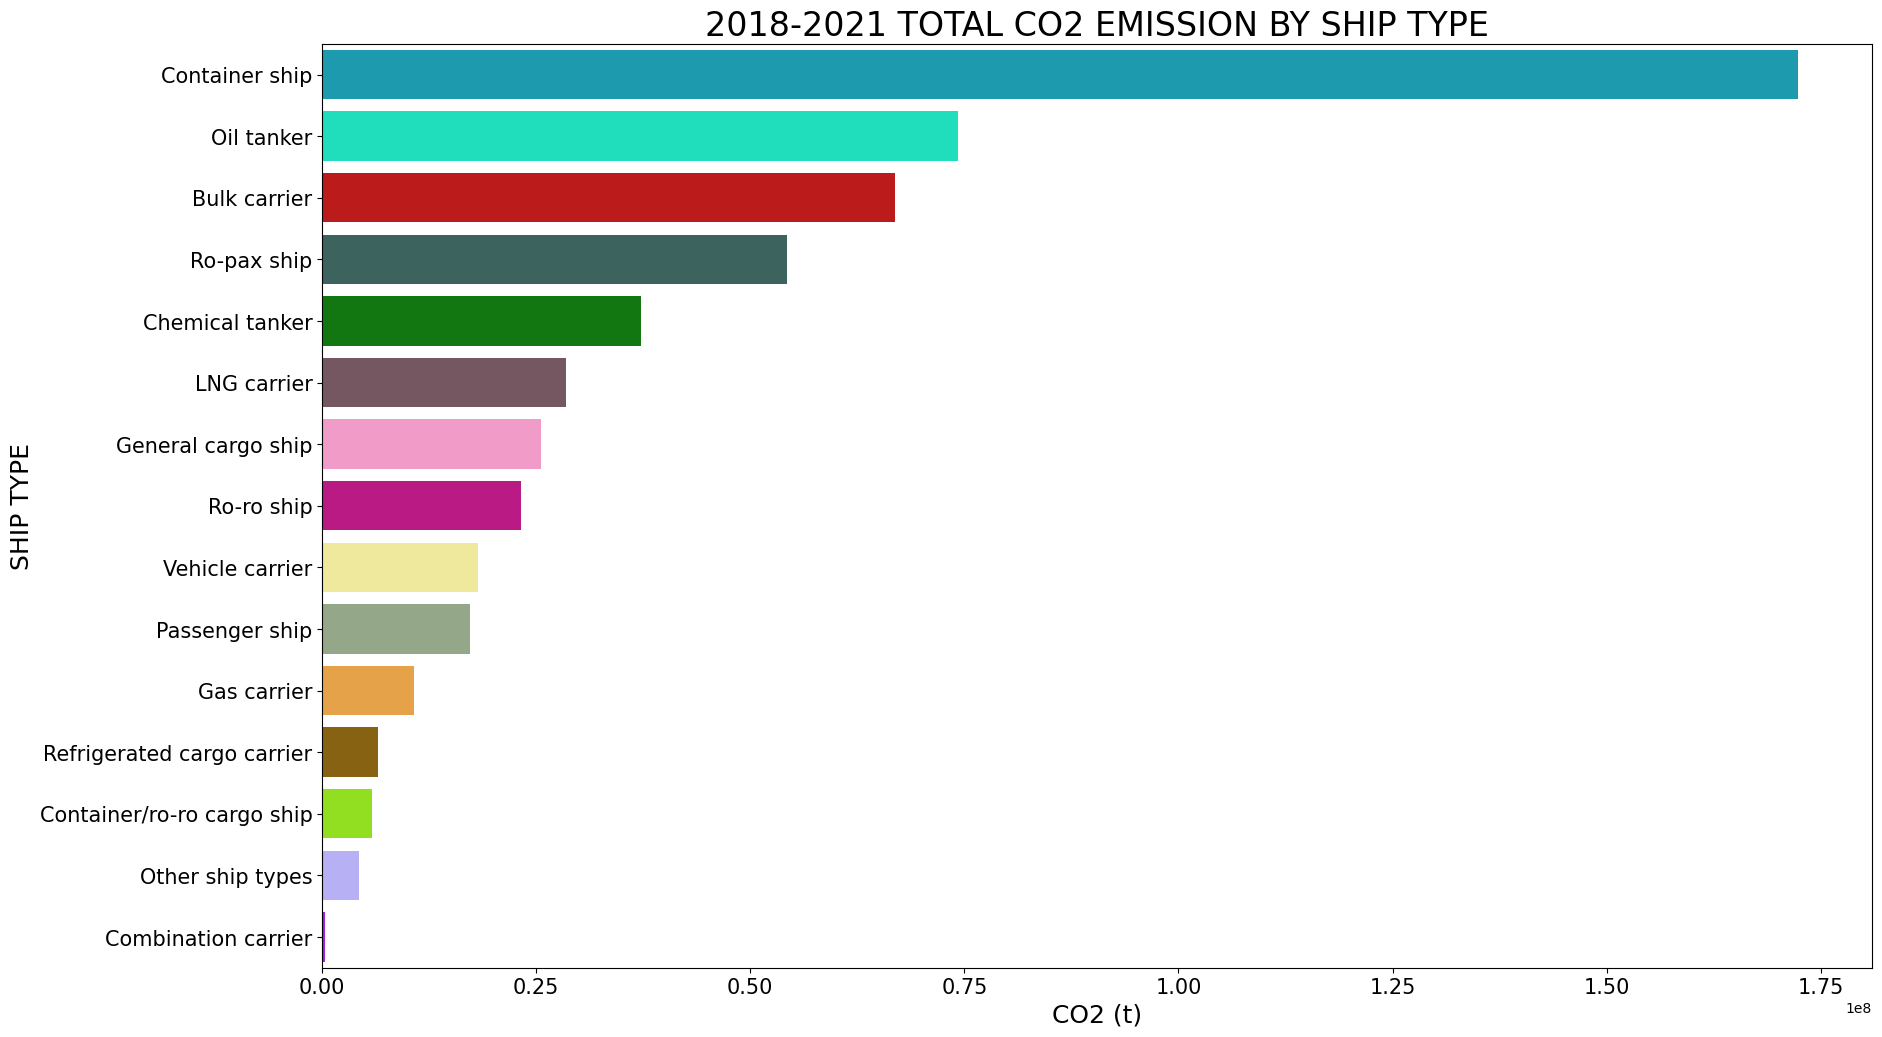

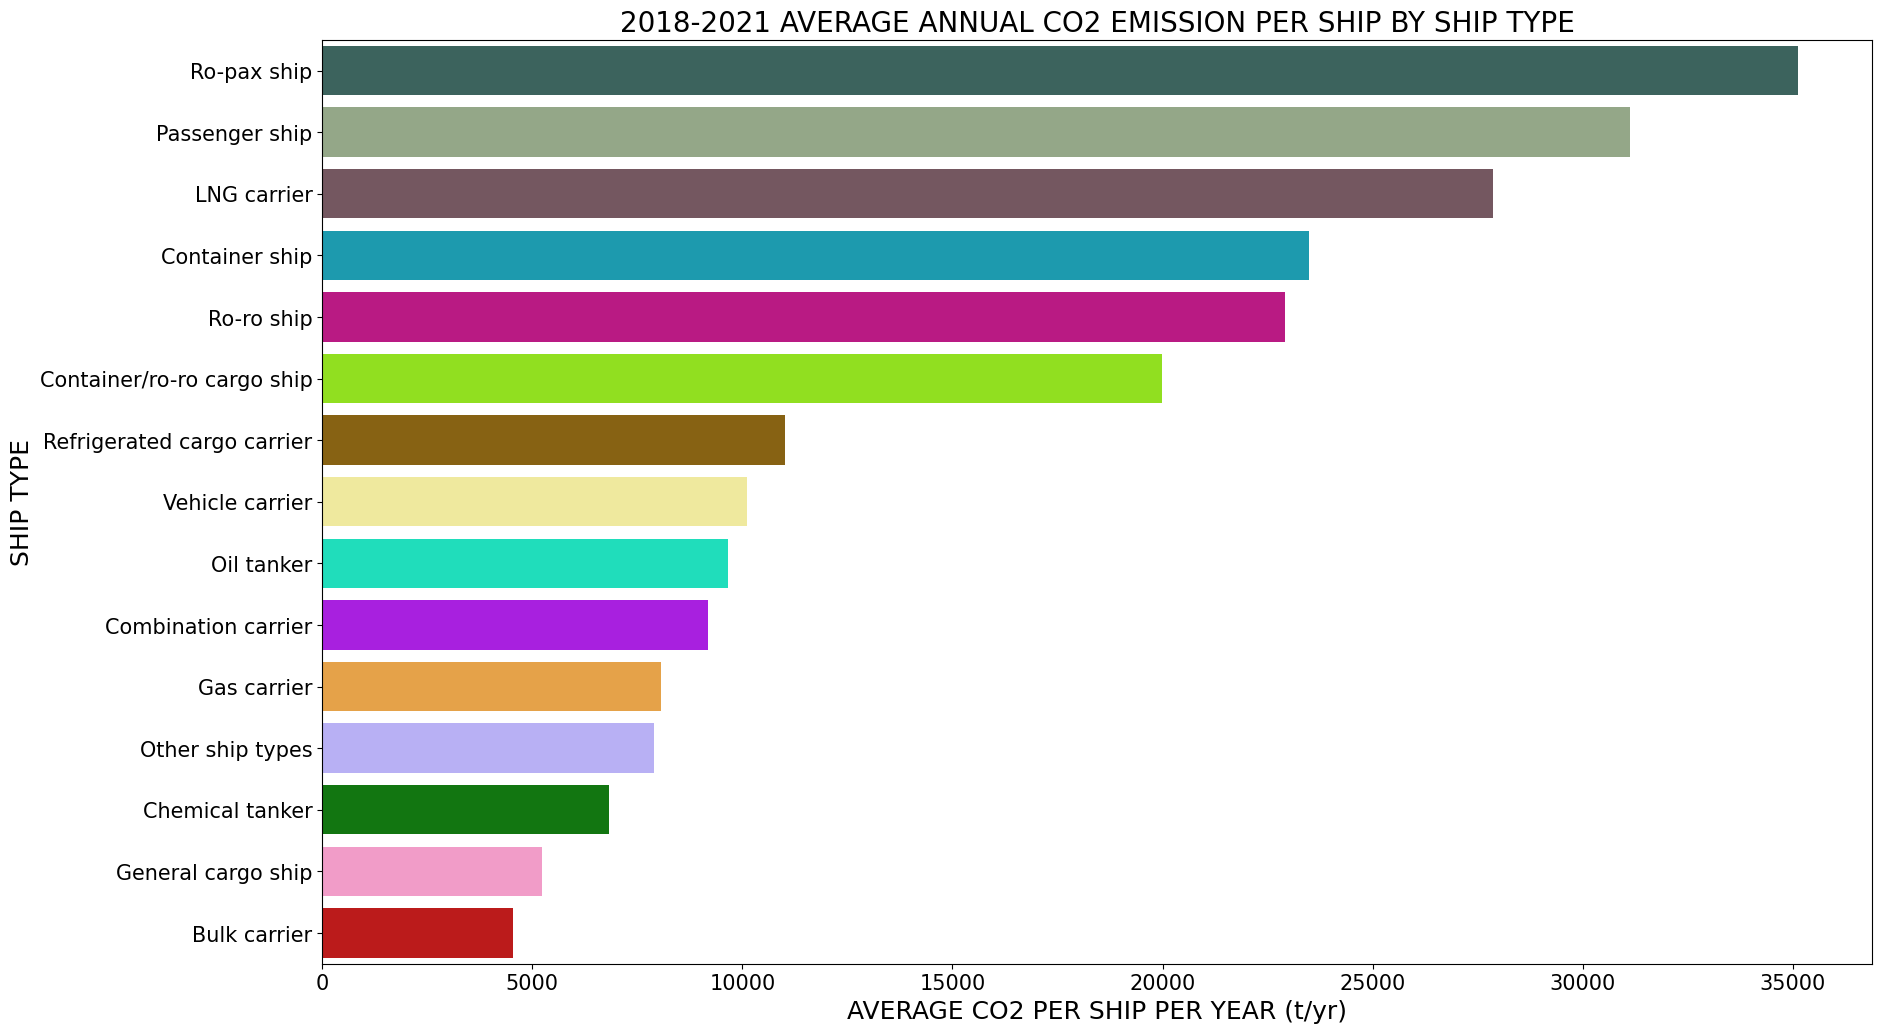

In [77]:
plt.figure(figsize=(20, 12))
plt.title("2018-2021 TOTAL CO2 EMISSION BY SHIP TYPE", fontsize=24)
sns.barplot(x=total_CO2_summed["Total_CO₂_emissions_[m_tonnes]"],
            y=total_CO2_summed.index,
            palette=color_dict)
plt.ylabel("SHIP TYPE", fontsize=18)
plt.xlabel("CO2 (t)", fontsize=18)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.show()

reordered_df = total_CO2_summed.sort_values("CO2_per_Ship_yr", ascending=False)
plt.figure(figsize=(20, 12))
plt.title(
    "2018-2021 AVERAGE ANNUAL CO2 EMISSION PER SHIP BY SHIP TYPE",
    fontsize=20)
sns.barplot(x=reordered_df["CO2_per_Ship_yr"],
            y=reordered_df.index,
            palette=color_dict)
plt.ylabel("SHIP TYPE", fontsize=18)
plt.xlabel("AVERAGE CO2 PER SHIP PER YEAR (t/yr)", fontsize=18)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.show()

# 4 - What is the relationship between deadweight and emission intensity?

## 4.1 Working and Exploration

Deadweight does not seem to be listed directly in the data. It is referenced indirectly in some entries through the field ["Annual_average_Fuel_consumption_per_transport_work_(dwt)_[g_/_dwt_carried_·_n_miles]"]. This can be used to calculated deadweight although it is only available for a fraction of the dataset. As a means of comparison we can also find listed deadweights through various web sources. Most require paid API key but we can use web scraping for this small exercise. 

In [48]:
# Selecting relevant columns, calculating deadweight where possible

cols = [
    "IMO_Number", "Ship_type", "Technical_efficiency",
    "Annual_average_CO₂_emissions_per_transport_work_(mass)_[g_CO₂_/_m_tonnes_·_n_miles]",
    "Total_fuel_consumption_[m_tonnes]",
    "Annual_average_Fuel_consumption_per_distance_[kg_/_n_mile]",
    "Annual_average_Fuel_consumption_per_transport_work_(dwt)_[g_/_dwt_carried_·_n_miles]"
]

renamed = [
    "IMO_Number", "Ship_type", "Technical_efficiency", "Measured_Efficiency",
    "Fuel_cons_t", "Fuel_cons_per_dist_kg/nm",
    "Fuel_cons_per_dwt_dist_g/dwt.nm"
]
mrv_dwt_df = mrv_df[cols].copy()
mrv_dwt_df.columns = renamed
mrv_dwt_df.Technical_efficiency = mrv_dwt_df.Technical_efficiency.apply(
    handle_te_val)
mrv_dwt_df["DWT_Calculated"] = mrv_dwt_df[
    "Fuel_cons_per_dist_kg/nm"] * 1000 / mrv_dwt_df[
        "Fuel_cons_per_dwt_dist_g/dwt.nm"]

In [49]:
def get_dwt(IMO):
    # takes a ships IMO and web-scrapes vesselfinder.com for listed dwt

    base_url = 'https://www.vesselfinder.com/vessels?name='
    # set a header so avoid request errors
    headers = {'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) '\
             'AppleWebKit/537.36 (KHTML, like Gecko) '\
             'Chrome/75.0.3770.80 Safari/537.36'}
    # build url
    url = base_url + str(IMO)
    # downlaod page
    
    page = requests.get(url, headers=headers)
    # try to pull out the dwt
    try:
        dwt = int(
            page.text.split('<td class="v5 is-hidden-mobile">')[1].split(
                '</td><td class="v6 is-hidden-mobile">')[0])
    except:
        dwt = -1
        print(f'Failed to get {IMO}')
    return {'IMO_Number': IMO, 'DWT': int(dwt)}

In [50]:
# set to true if dwts.csv is not available in the cwd to perform multithread
# scrape of dwts for the dataset, converting to df and saving in to cwd as csv

scrape_dwts = False

if scrape_dwts:
    with ThreadPool(40) as t:
        dwts = list(
            tqdm(t.imap(get_dwt, mrv_dwt_df.IMO_Number.unique()),
                 total=mrv_dwt_df.IMO_Number.unique().shape[0]))

    dwts_df = pd.DataFrame(dwts)
    dwts_df.to_csv(os.path.join(cwd, "dwts.csv"))

In [51]:
# Run if dwts.csv is available in cwd

dwts_csv_available = True

if dwts_csv_available:
    dwts_df = pd.read_csv(os.path.join(cwd, "dwts.csv"), index_col=0)

In [52]:
dwts_df

IMO_Number    DWT
0         6703343   2045
1         7037806   1968
2         7043843   2838
3         7128332   4000
4         7226952   2566
...           ...    ...
18254     9814026   1305
18255     9816567  37634
18256     9817561  82076
18257     9830161  38016
18258     9835068  81723

[18259 rows x 2 columns]

In [53]:
# Joining to main dwt df

if "DWT" not in mrv_dwt_df.columns and "DWT_Listed" not in mrv_dwt_df.columns:
    mrv_dwt_df = mrv_dwt_df.merge(dwts_df, on="IMO_Number")
    mrv_dwt_df.rename(columns={"DWT": "DWT_Listed"}, inplace=True)

# Dropping -1 dwt value returned from failed scrape. This is for a yacht that has
# no listed dwt

mrv_dwt_df = mrv_dwt_df[mrv_dwt_df.DWT_Listed != -1]
mrv_dwt_df

IMO_Number         Ship_type  Technical_efficiency  \
0         6703343  Other ship types                 57.84   
1         6703343  Other ship types                 57.84   
2         6703343  Other ship types                 57.84   
3         6703343  Other ship types                   NaN   
4         7037806       Ro-pax ship                 19.40   
...           ...               ...                   ...   
48811     9814026    Passenger ship                 20.40   
48812     9816567      Bulk carrier                  5.48   
48813     9817561      Bulk carrier                  3.34   
48814     9830161      Bulk carrier                  5.44   
48815     9835068      Bulk carrier                  3.68   

       Measured_Efficiency  Fuel_cons_t  Fuel_cons_per_dist_kg/nm  \
0                   210.74       373.50                     70.25   
1                   211.88       225.70                     40.75   
2                   333.51      1607.60                     56.58   
3                   286.30       549.00                     63.46   
4                      NaN      1902.00                     82.04   
...                    ...          ...                       ...   
48811                  NaN      1780.46                     77.13   
48812                 6.70       793.08                     69.52   
48813                 4.11      2041.94                     97.48   
48814                 6.52       722.92                     75.41   
48815                 4.74       719.70                     99.13   

       Fuel_cons_per_dwt_dist_g/dwt.nm  DWT_Calculated  DWT_Listed  
0                                34.46     2038.595473        2045  
1                                54.28      750.736920        2045  
2                                 0.32   176812.500000        2045  
3                                  NaN             NaN        2045  
4                                  NaN             NaN        1968  
...                                ...             ...         ...  
48811                              NaN             NaN        1305  
48812                              NaN             NaN       37634  
48813                              NaN             NaN       82076  
48814                              NaN             NaN       38016  
48815                              NaN             NaN       81723  

[48814 rows x 9 columns]

In [54]:
mrv_dwt_df.describe()

IMO_Number  Technical_efficiency  Measured_Efficiency   Fuel_cons_t  \
count  4.881400e+04          44696.000000         4.006500e+04  48814.000000   
mean   9.453078e+06             13.360178         9.856383e+04   3581.739494   
std    2.870139e+05            241.187867         1.163274e+07   4536.734739   
min    5.383304e+06              0.010000         3.000000e-02      0.000000   
25%    9.307935e+06              4.520000         7.950000e+00   1046.600000   
50%    9.451719e+06              7.120000         1.264000e+01   2061.475000   
75%    9.662423e+06             14.480000         2.767000e+01   4084.480000   
max    9.924912e+06          46222.000000         2.305780e+09  98465.200000   

       Fuel_cons_per_dist_kg/nm  Fuel_cons_per_dwt_dist_g/dwt.nm  \
count              47138.000000                     4.914000e+03   
mean                 147.491013                     4.595515e+05   
std                 3410.746483                     2.206611e+07   
min                    2.790000                     4.000000e-02   
25%                   77.522500                     5.660000e+00   
50%                   99.640000                     7.780000e+00   
75%                  142.580000                     1.125750e+01   
max               719207.000000                     1.449000e+09   

       DWT_Calculated     DWT_Listed  
count    4.914000e+03   48814.000000  
mean     1.146175e+04   56839.394272  
std      2.972192e+04   52362.424980  
min      4.565908e-05     340.000000  
25%      4.544408e+03   17999.000000  
50%      6.593396e+03   40247.000000  
75%      1.104204e+04   77162.250000  
max      1.291625e+06  324272.000000

We have some significant outliers with calculated DWT that are likely erroneous given they are an order of magnitude higher than the highest listed deadweight. 

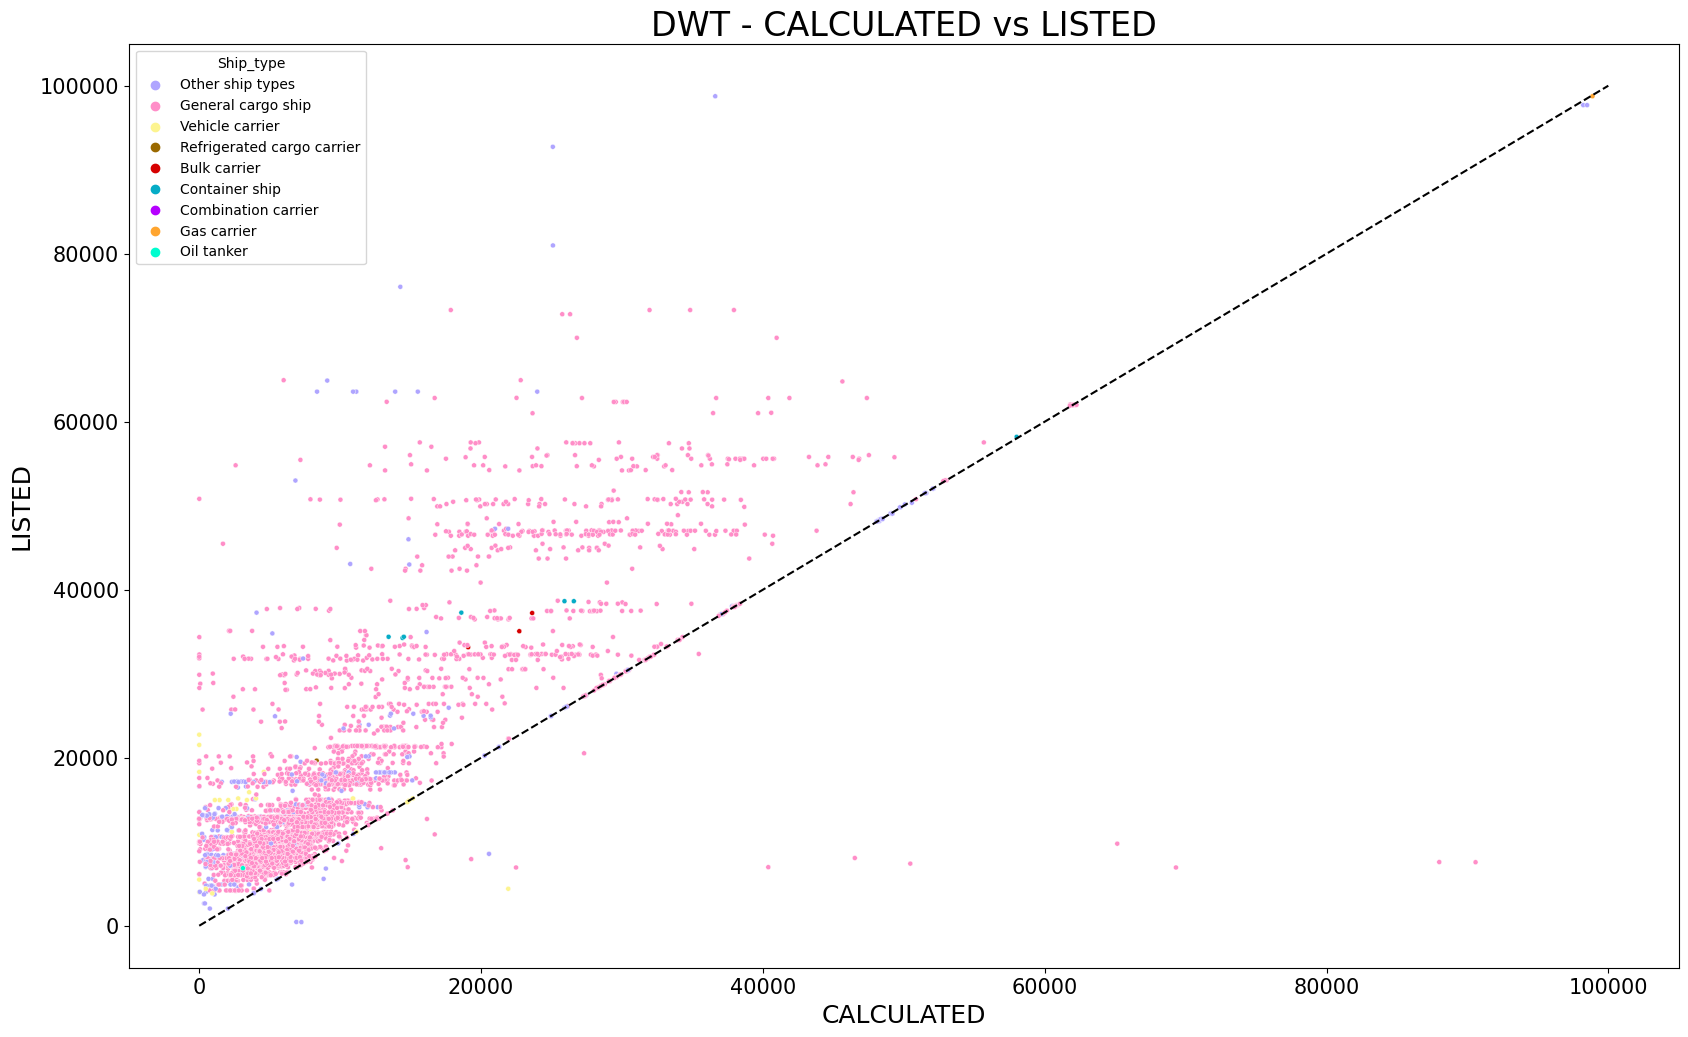

In [55]:
cdwt_lim = 100000
plt.figure(figsize=(20, 12))
plt.title("DWT - CALCULATED vs LISTED", fontsize=24)
sns.scatterplot(data=mrv_dwt_df[(mrv_dwt_df.DWT_Calculated < cdwt_lim)
                                & (mrv_dwt_df.DWT_Listed < cdwt_lim)],
                x="DWT_Calculated",
                y="DWT_Listed",
                hue="Ship_type",
                palette=color_dict,
                s=13)
plt.ylabel("LISTED", fontsize=18)
plt.xlabel("CALCULATED", fontsize=18)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.plot([0, cdwt_lim], [0, cdwt_lim], linestyle='--', color="black")
plt.show()

From the above we see that (with some exceptions) listed deadweight is higher than the calculated number, indicating that the calculated number may represent the amount actually carried rather than the full carrying capacity, similar to listed vs measured technical efficiency. On this basis we will compare listed DWT vs listed TE and calculated DWT vs measured TE. Note that many ships calculated DWT is exactly the same as the listed DWT, indicating those entries may have used listed DWT rather than the amount actually carried, or operated at full capacity. 

## 4.2 Findings

Removing outliers we can plot the relationship between listed technical efficiency and listed deadweight using regplot, showing a negative linear relationship. 

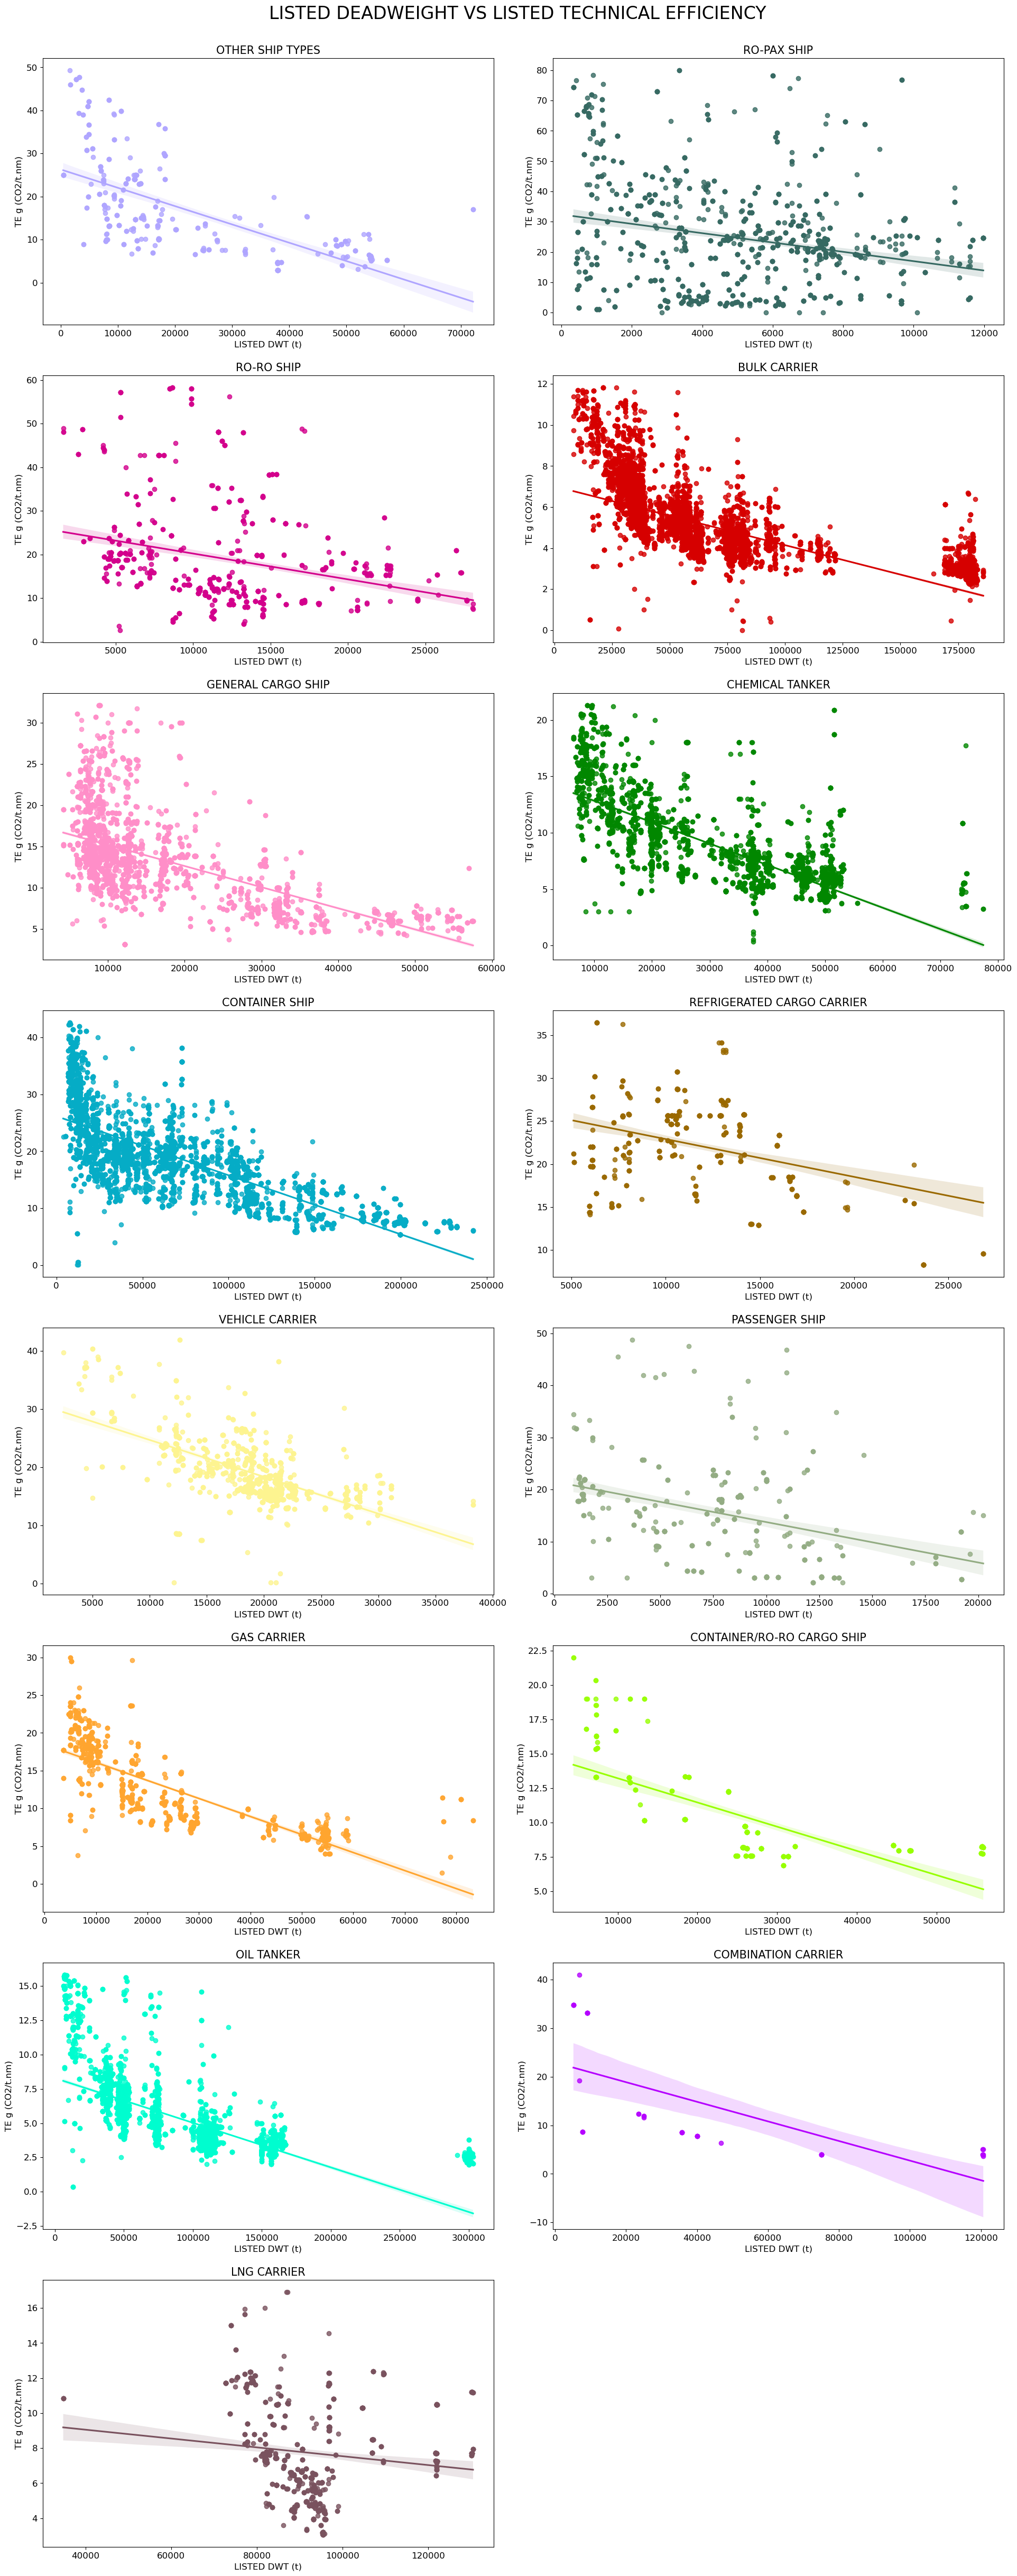

In [56]:
data = mrv_dwt_df[(mrv_dwt_df.Technical_efficiency < te_lim)]

fig, axs = plt.subplots(8, 2, figsize=(20, 50))
fig.tight_layout(pad=5)
types = data.Ship_type.unique()
fig.suptitle('LISTED DEADWEIGHT VS LISTED TECHNICAL EFFICIENCY', fontsize=24)
fig.subplots_adjust(top=0.96)

for idx in range(len(types)):
    i, j = idx // 2, idx % 2
    ax = axs[i, j]
    ax.set_title(types[idx].upper(), fontsize=15)
    data_stype = data[data.Ship_type == types[idx]]
    te_z_filter = (np.abs(stats.zscore(data_stype.Technical_efficiency)) < 3)
    dwt_z_filter = (np.abs(stats.zscore(data_stype.DWT_Listed)) < 3)
    data_stype_filtered = data_stype[(te_z_filter) & (dwt_z_filter)]
    sns.regplot(data=data_stype_filtered,
                x="DWT_Listed",
                y="Technical_efficiency",
                color=color_dict[types[idx]],
                ax=ax)
    ax.set_xlabel("LISTED DWT (t)", fontsize=12)
    ax.set_ylabel("TE g (CO2/t.nm)", fontsize=12)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.legend([], [], frameon=False)
fig.delaxes(axs[7, 1])

plt.show()

The identical operation is performed below for measured technical efficiency vs calculated deadweight. This process is limited due reduced data for both fields relative to the listed counterparts with most ship types having no data with outliers removed. 

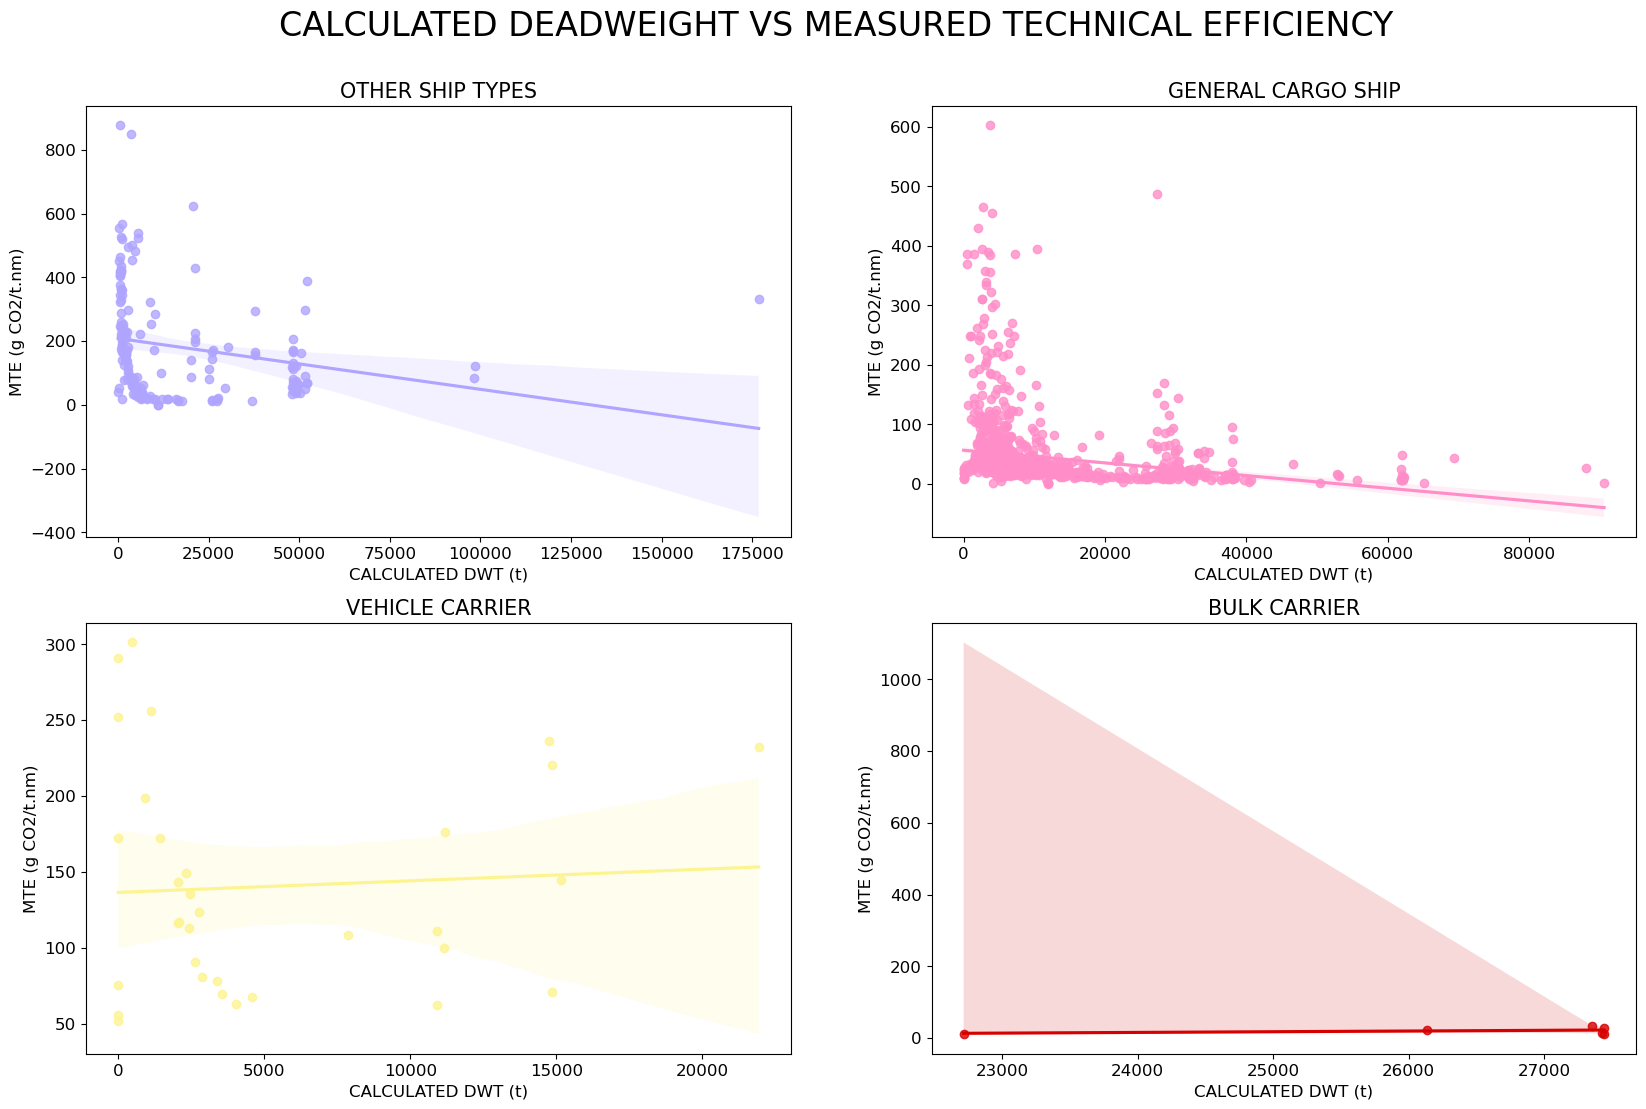

In [57]:
mte_lim = 5000
cdwt_lim = 3500000

mte_filter = mrv_dwt_df.Measured_Efficiency < mte_lim
cdwt_filter = mrv_dwt_df.DWT_Calculated < cdwt_lim

data = mrv_dwt_df[mte_filter & cdwt_filter]

fig.tight_layout(pad=5)
types = data.Ship_type.unique()
fig, axs = plt.subplots(2, 2, figsize=(20, 12))
fig.suptitle('CALCULATED DEADWEIGHT VS MEASURED TECHNICAL EFFICIENCY',
             fontsize=24)
fig.subplots_adjust(top=0.9)

for idx in range(len(types)):
    i, j = idx // 2, idx % 2
    data_stype = data[data.Ship_type == types[idx]]
    te_z_filter = (np.abs(stats.zscore(data_stype.Measured_Efficiency)) < 3)
    dwt_z_filter = (np.abs(stats.zscore(data_stype.DWT_Calculated)) < 3)
    data_stype_filtered = data_stype[(te_z_filter) & (dwt_z_filter)]
    if len(data_stype_filtered) != 0:
        ax = axs[i, j]
        ax.set_title(types[idx].upper(), fontsize=15)
        sns.regplot(data=data_stype_filtered,
                    x="DWT_Calculated",
                    y="Measured_Efficiency",
                    color=color_dict[types[idx]],
                    ax=ax)
        ax.set_xlabel("CALCULATED DWT (t)", fontsize=12)
        ax.set_ylabel("MTE (g CO2/t.nm)", fontsize=12)
        ax.tick_params(axis='both', which='major', labelsize=12)
        ax.legend([], [], frameon=False)

plt.show()

## 4.3 Additional Exploration

A less visual assessment of the relationship could also be achieved using a linear regression model from stats models as below, numerically representing the intercept, linear coeff, strength of correlation and various measures of the certainty of the model.

In [58]:
filter_1 = mrv_dwt_df.Technical_efficiency < te_lim
filter_2 = mrv_dwt_df.DWT_Listed.notna()
filter_3 = mrv_dwt_df.Technical_efficiency.notna()
filter_4 = mrv_dwt_df.Ship_type == "Container ship"


data = mrv_dwt_df[filter_1 & filter_2 & filter_3 & filter_4]
Y = data.Technical_efficiency
X = data.DWT_Listed
X = sm.add_constant(X)
model = sm.OLS(Y,X)
results = model.fit()

print(results.summary())

                             OLS Regression Results                             
Dep. Variable:     Technical_efficiency   R-squared:                       0.584
Model:                              OLS   Adj. R-squared:                  0.584
Method:                   Least Squares   F-statistic:                     9228.
Date:                  Mon, 24 Oct 2022   Prob (F-statistic):               0.00
Time:                          19:21:01   Log-Likelihood:                -20203.
No. Observations:                  6580   AIC:                         4.041e+04
Df Residuals:                      6578   BIC:                         4.042e+04
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         26.3665      0.103

# 5 - How many miles did each vessel in the database travel? 

## 5.1 Working and Exploration 

Distance traveled is not directly listed but can be calculated using total fuel used vs fuel consumption rates and CO2 emitted vs CO2 emission rates. We will use both to compare. 

In [59]:
# selecting data and calculating total distance travelled using both fuel and CO2 metrics

mrv_distance_calc_df = mrv_df[[
    "IMO_Number", "Reporting_Period", "Ship_type",
    "Total_fuel_consumption_[m_tonnes]",
    "Annual_average_Fuel_consumption_per_distance_[kg_/_n_mile]",
    'Total_CO₂_emissions_[m_tonnes]',
    "Annual_average_CO₂_emissions_per_distance_[kg_CO₂_/_n_mile]"
]].copy()
mrv_distance_calc_df.columns = [
    "IMO_Number", "Reporting_Period", "Ship_type", "Fuel_Consumption_t",
    "Fuel_Consumption_per_dist_kg/nm", "CO2_Emission_t",
    "CO2_Emission_per_dist_kg/nm"
]

mrv_distance_calc_df["Distance_Travelled_Fuel_Based"] = mrv_distance_calc_df[
    "Fuel_Consumption_t"] * 1000 / mrv_distance_calc_df[
        "Fuel_Consumption_per_dist_kg/nm"]
mrv_distance_calc_df["Distance_Travelled_CO2_Based"] = mrv_distance_calc_df[
    "CO2_Emission_t"] * 1000 / mrv_distance_calc_df[
        "CO2_Emission_per_dist_kg/nm"]
mrv_distance_calc_df["Difference"] = (
    mrv_distance_calc_df["Distance_Travelled_CO2_Based"] -
    mrv_distance_calc_df["Distance_Travelled_Fuel_Based"]
) / mrv_distance_calc_df["Distance_Travelled_CO2_Based"] * 100

mrv_distance_calc_df

IMO_Number  Reporting_Period         Ship_type  Fuel_Consumption_t  \
0         6703343              2021  Other ship types              373.50   
1         7037806              2021       Ro-pax ship             1902.00   
2         7043843              2021        Ro-ro ship             2081.79   
3         7128332              2021       Ro-pax ship             3299.89   
4         7226952              2021        Ro-ro ship             1670.56   
...           ...               ...               ...                 ...   
48815     9838199              2018   Chemical tanker              248.28   
48816     9839064              2018      Bulk carrier                0.00   
48817     9840790              2018      Bulk carrier                0.00   
48818     9847140              2018   Chemical tanker              496.60   
48819     9848467              2018        Ro-ro ship              116.33   

       Fuel_Consumption_per_dist_kg/nm  CO2_Emission_t  \
0                                70.25         1184.62   
1                                82.04         6097.81   
2                                57.72         6674.22   
3                                93.47        10454.38   
4                                49.13         5355.81   
...                                ...             ...   
48815                            35.99          776.86   
48816                              NaN            0.00   
48817                              NaN            0.00   
48818                           734.29         1551.75   
48819                           132.34          362.35   

       CO2_Emission_per_dist_kg/nm  Distance_Travelled_Fuel_Based  \
0                           222.80                    5316.725979   
1                           263.01                   23183.812774   
2                           185.05                   36067.047817   
3                           296.12                   35304.268749   
4                           157.51                   34002.849583   
...                            ...                            ...   
48815                       112.60                    6898.582940   
48816                          NaN                            NaN   
48817                          NaN                            NaN   
48818                      2294.47                     676.299555   
48819                       412.23                     879.023727   

       Distance_Travelled_CO2_Based  Difference  
0                       5316.965889    0.004512  
1                      23184.707806    0.003860  
2                      36067.116995    0.000192  
3                      35304.538701    0.000765  
4                      34002.983938    0.000395  
...                             ...         ...  
48815                   6899.289520    0.010241  
48816                           NaN         NaN  
48817                           NaN         NaN  
48818                    676.299973    0.000062  
48819                    878.999588   -0.002746  

[48820 rows x 10 columns]

In [60]:
# Testing for differences of over 1% between approaches 

(mrv_distance_calc_df.Difference > 1).sum()

0

In [61]:
# Reducing to a simplified df given no significant differences between calcs

mrv_distance_traveled_df = mrv_distance_calc_df[[
    "IMO_Number", "Reporting_Period", "Ship_type",
    "Distance_Travelled_Fuel_Based"
]].copy()
mrv_distance_traveled_df

IMO_Number  Reporting_Period         Ship_type  \
0         6703343              2021  Other ship types   
1         7037806              2021       Ro-pax ship   
2         7043843              2021        Ro-ro ship   
3         7128332              2021       Ro-pax ship   
4         7226952              2021        Ro-ro ship   
...           ...               ...               ...   
48815     9838199              2018   Chemical tanker   
48816     9839064              2018      Bulk carrier   
48817     9840790              2018      Bulk carrier   
48818     9847140              2018   Chemical tanker   
48819     9848467              2018        Ro-ro ship   

       Distance_Travelled_Fuel_Based  
0                        5316.725979  
1                       23183.812774  
2                       36067.047817  
3                       35304.268749  
4                       34002.849583  
...                              ...  
48815                    6898.582940  
48816                            NaN  
48817                            NaN  
48818                     676.299555  
48819                     879.023727  

[48820 rows x 4 columns]

## 5.2 Findings

The below cell can be used to find distance traveled for vessels. Enter desired IMOs into the below IMOs list.

In [62]:
#fill IMOs list to search by IMO

IMOs = [7128332, 9847140]

mrv_distance_traveled_df[mrv_distance_traveled_df.IMO_Number.isin(
    IMOs)].sort_values("IMO_Number")

IMO_Number  Reporting_Period        Ship_type  \
3         7128332              2021      Ro-pax ship   
12133     7128332              2020      Ro-pax ship   
24178     7128332              2019      Ro-pax ship   
36572     7128332              2018      Ro-pax ship   
11449     9847140              2021  Chemical tanker   
23862     9847140              2020  Chemical tanker   
36481     9847140              2019  Chemical tanker   
48818     9847140              2018  Chemical tanker   

       Distance_Travelled_Fuel_Based  
3                       35304.268749  
12133                   47931.440443  
24178                   49154.644092  
36572                   48724.590947  
11449                   42056.724138  
23862                   40216.666667  
36481                   50011.066027  
48818                     676.299555

FREQUENCY OF DISTANCES TRAVELED BY VESSELS IN A YEAR

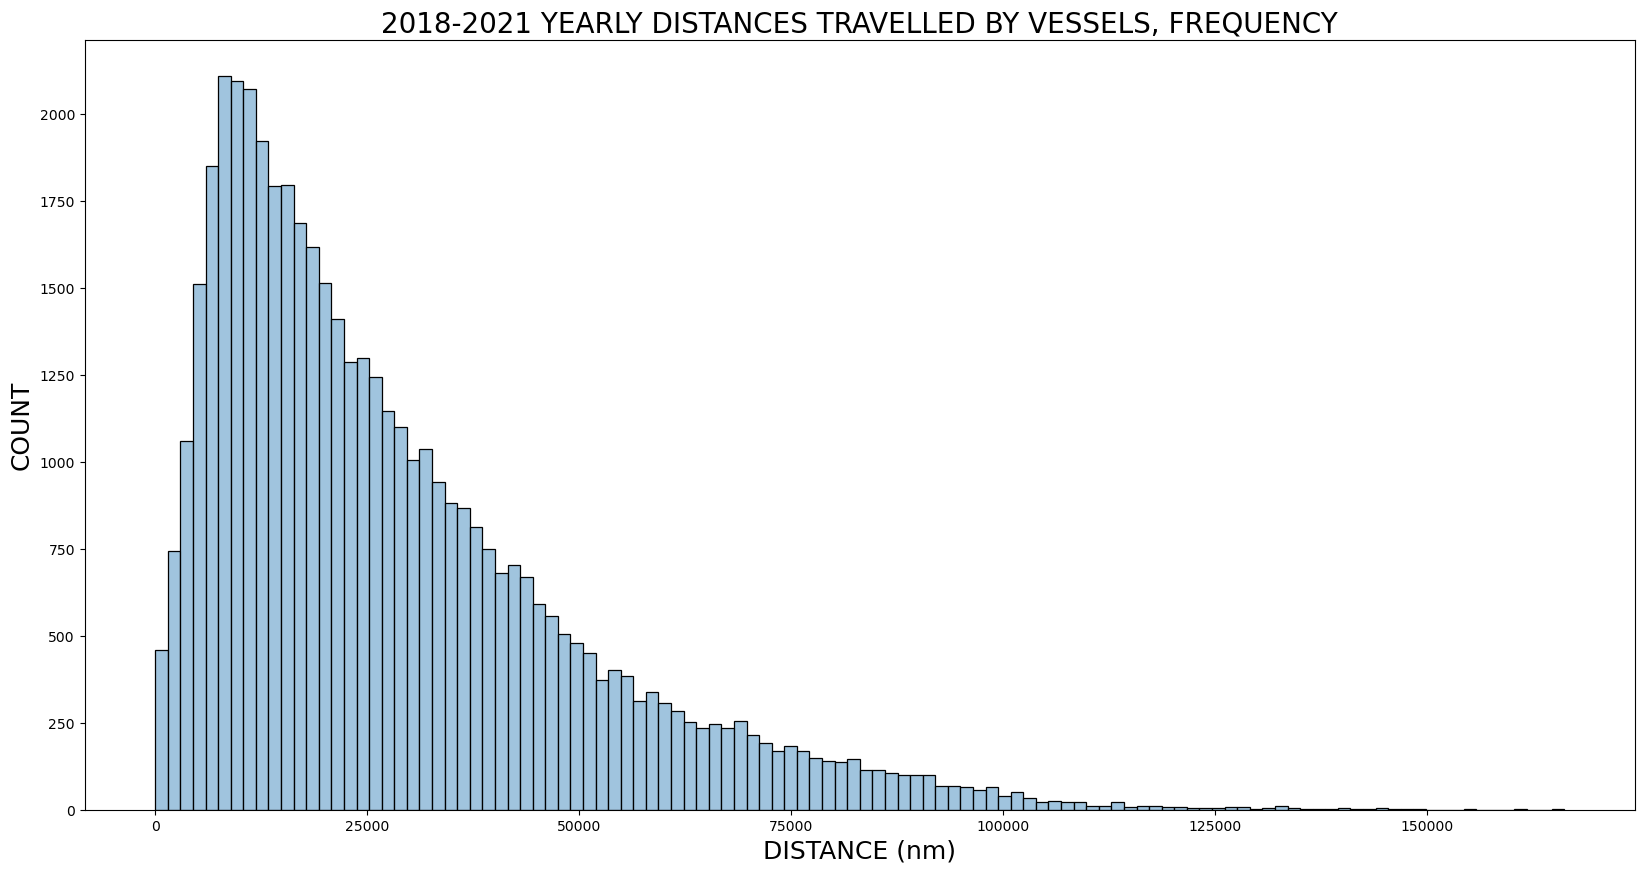

In [63]:
plt.figure(figsize=(20, 10))
plt.title("2018-2021 YEARLY DISTANCES TRAVELLED BY VESSELS, FREQUENCY",
          fontsize=20)
plt.xlabel("DISTANCE (nm)", fontsize=18)
plt.ylabel("COUNT", fontsize=18)
sns.histplot(data=mrv_distance_traveled_df[
    mrv_distance_traveled_df.Distance_Travelled_Fuel_Based < 300000],
             x="Distance_Travelled_Fuel_Based",
             color=clrs[3])

plt.show()

DISTANCES TRAVELED BY VESSELS IN A YEAR BY SHIP TYPE

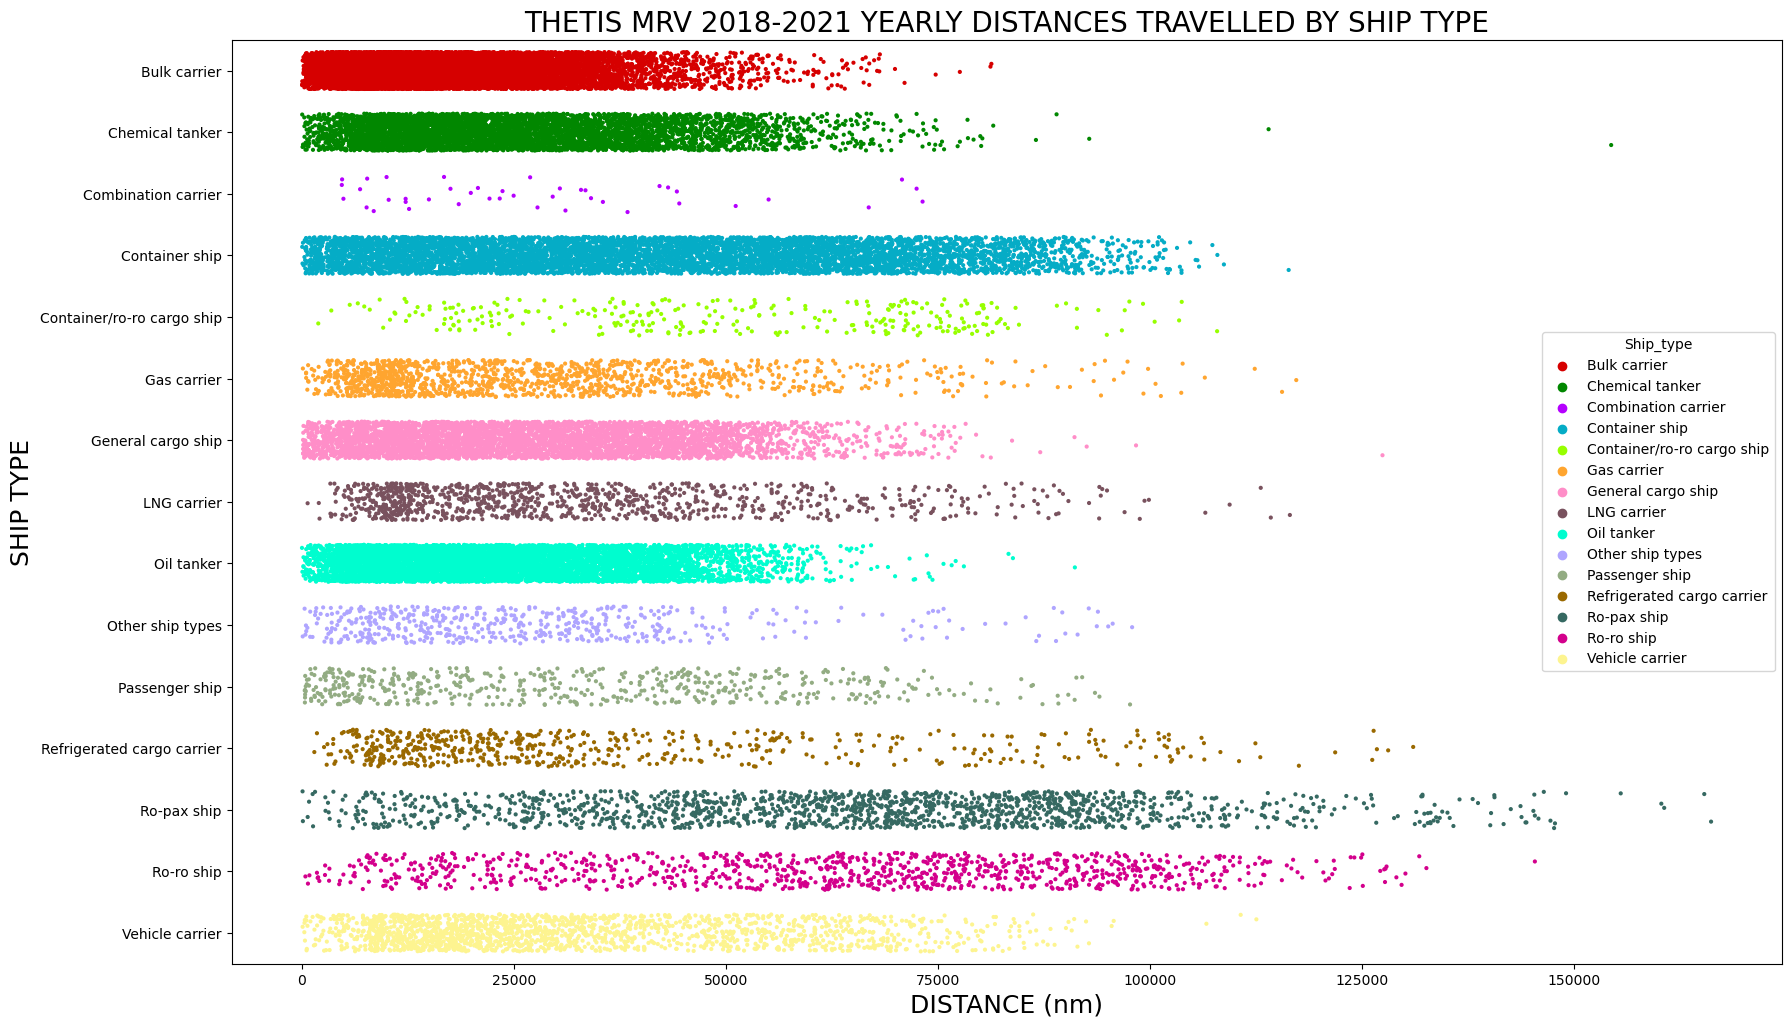

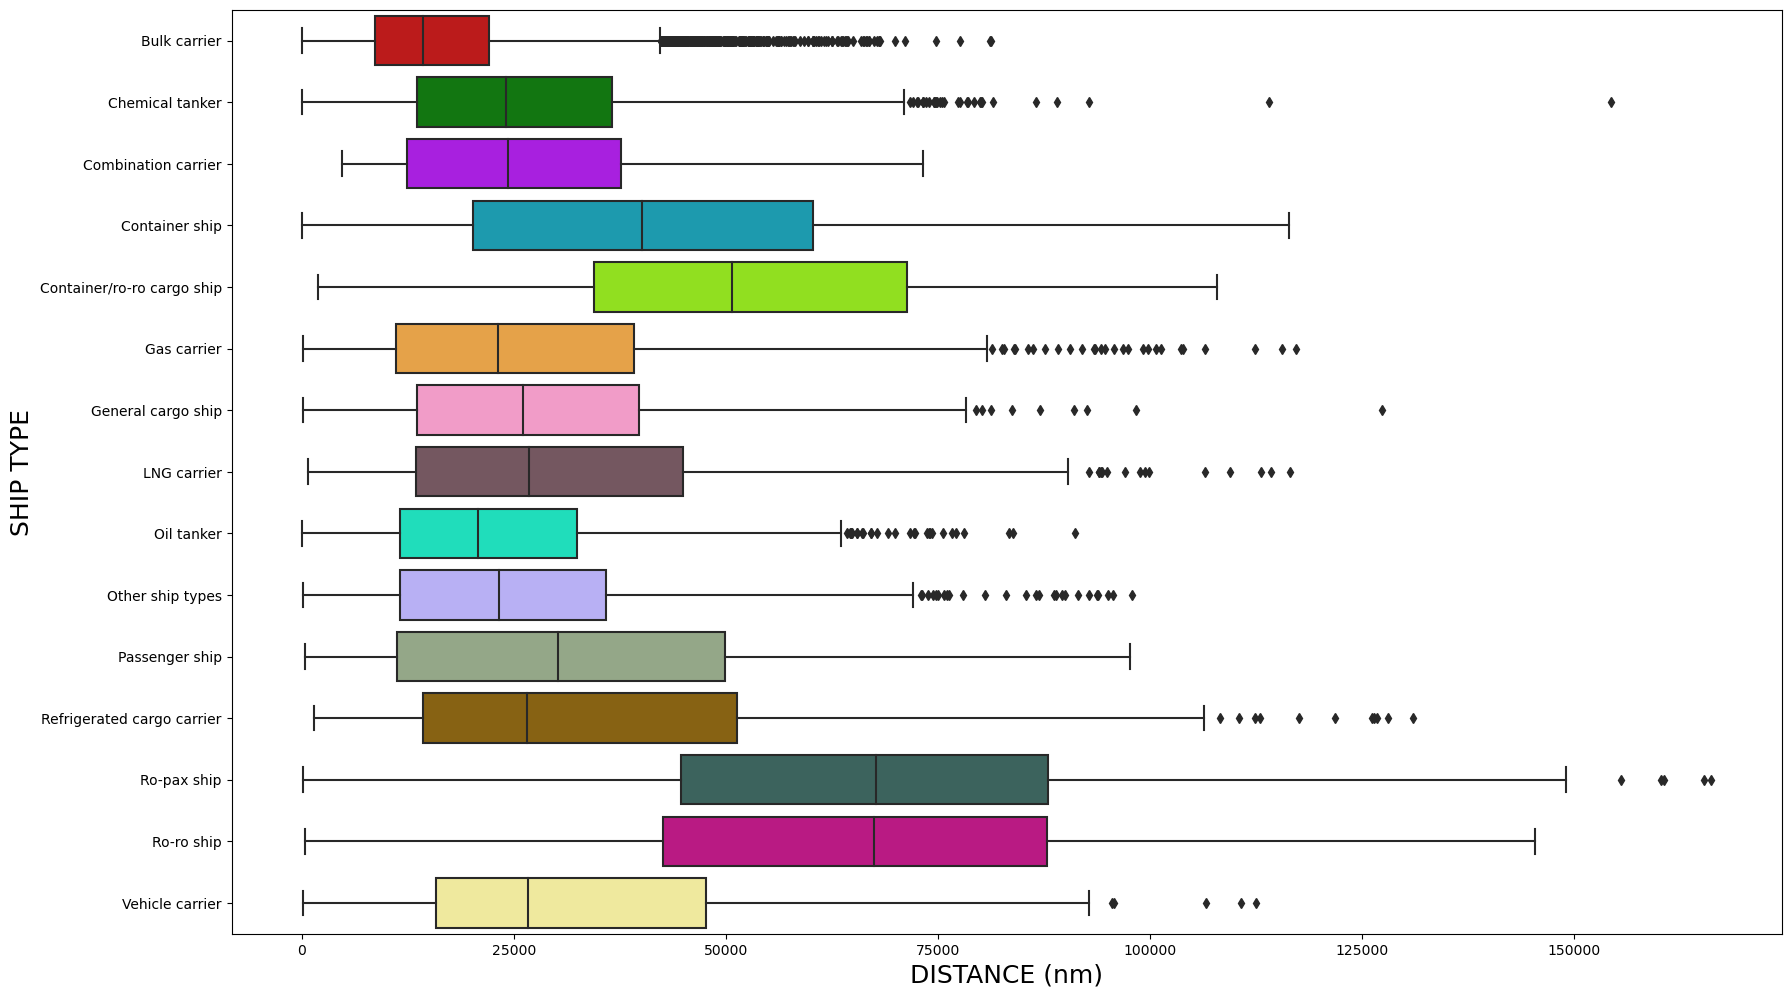

In [64]:
plt.figure(figsize=(20, 12))
plt.title("THETIS MRV 2018-2021 YEARLY DISTANCES TRAVELLED BY SHIP TYPE",
          fontsize=20)
sns.stripplot(data=mrv_distance_traveled_df[
    mrv_distance_traveled_df.Distance_Travelled_Fuel_Based < 300000].
              sort_values("Ship_type"),
              x="Distance_Travelled_Fuel_Based",
              y="Ship_type",
              hue="Ship_type",
              jitter=0.3,
              palette=color_dict,
              s=3)
plt.ylabel("SHIP TYPE", fontsize=18)
plt.xlabel("DISTANCE (nm)", fontsize=18)

plt.show()

plt.figure(figsize=(20, 12))
sns.boxplot(data=mrv_distance_traveled_df[
    mrv_distance_traveled_df.Distance_Travelled_Fuel_Based < 300000].
            sort_values("Ship_type"),
            x="Distance_Travelled_Fuel_Based",
            y="Ship_type",
            palette=color_dict)
plt.ylabel("SHIP TYPE", fontsize=18)
plt.xlabel("DISTANCE (nm)", fontsize=18)

plt.show()